In [10]:
#general imports

In [1]:
import pandas as pd
import pickle
pd.set_option("display.max_colwidth", None)
#pd.set_option("display.max_rows", None)
import logging
from time import time
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)
import numpy as np
import os
import re
import csv
from emot.emo_unicode import UNICODE_EMOJI, EMOTICONS_EMO
from gensim.models import Word2Vec
import multiprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.svm import SVC
import ruptures as rpt
import matplotlib.pyplot as plt
from math import sqrt
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import itertools
from collections import defaultdict
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf

In [9]:
#imports for the scraper

In [ ]:
import pandas as pd
from os import mkdir, path
from datetime import timedelta
import time
import twint
import nest_asyncio
nest_asyncio.apply()

In [11]:
#defining parameters of the twint search

In [ ]:
def twint_search(since, until, csv_name, coordinate):
    c = twint.Config()
    c.Since = since
    c.Until = until
    c.Geo = coordinate
    c.Count = True
    c.Lang = "en"
    c.Hide_output = True
    c.Store_csv = True
    c.Output = csv_name
    c.Debug = True
    
    try:
        twint.run.Search(c)
    except(KeyboardInterrupt, SystemExit):
        raise
    except:
        print("Problem with %s"%since)

In [12]:
#function for the scraping

In [ ]:
def my_scraper(since, until, state_name, coordinates):
    
    dirname = state_name
    try:
        mkdir(dirname)
        print("Directory", dirname, "created")
    except FileExistsError:
        print("Directory", dirname, "exists")
    
    daterange = pd.date_range(since, until)
    for start_date in daterange:
        since = start_date.strftime("%Y-%m-%d")
        until = (start_date + timedelta(1)).strftime("%Y-%m-%d")
        
        
        print("Getting data for %s"%since)
        csv_name = "%s.csv"%since
        csv_name = path.join(dirname, csv_name)
        
        for coordinate in coordinates:
            twint_search(since, until, csv_name, coordinate)
            
        time.sleep(60)

In [13]:
#running the scraper

In [ ]:
list_of_coordinates = ["31.873260,77.218891,100km", "30.744087,77.442958,25km"]
my_scraper("2020-01-22","2020-05-30","Himachal",list_of_coordinates)

In [5]:
#importing list of slang words and their full forms

In [2]:
slang_list = []
slang_dict = {}

with open("slang.txt", "r") as f:
    file_data = csv.reader(f, delimiter = "=")
    for _row in file_data:
        if _row != "":
            slang_word = _row[0]
            slang_list.append(slang_word)
            slang_meaning = _row[1]
            slang_dict[slang_word] = slang_meaning

In [6]:
#defining list of punctuation marks that we wan't to remove

In [3]:
punctuation_list = [",", ".", "!", "?", "$", "%", "^", "&", "*", ")", "(", "=", \
                    ":", "|", ";", "<", ">", "~", "‚Äò", "'", "/", "\\", "‚Äô", "-"]

In [8]:
#function for cleaning tweets that have been scraped

In [7]:
class tweet_cleaner:
    
    def __init__(self, _file, _folder, save_folder, necessary_columns = ["id", "conversation_id", "date", "time", \
                                                            "user_id", "tweet", "retweets_count",\
                                                            "replies_count", "likes_count", "retweet"]):
        self.folder = _folder
        self.file = _file
        self.save_folder = save_folder
        self.necessary_columns = necessary_columns
        self.df = pd.read_csv(os.path.join(os.path.abspath(self.folder), self.file))
        self.cleaned_df = self.clean_tweet()
        self.output = self.save_output()
        
        
    
    @staticmethod
    def find_caps_share(tweet):
        caps_length = len(re.findall(r"[A-Z]", tweet))
        tweet_length = len(re.sub(r"\s", "", tweet))
        
        return caps_length/(1 + tweet_length)
    
    @staticmethod
    def remove_contractions(tweet):
        tweet = tweet.lower()
        tweet = re.sub(r"can\s?'\s?t", "cannot", tweet)
        tweet = re.sub(r"won\s?'\s?t", "will not", tweet)
        tweet = re.sub(r"n\s?'\s?t", " not", tweet)
        tweet = re.sub(r"'\s?ve", " have", tweet)
        tweet = re.sub(r"'\s?ll", " will", tweet)
        tweet = re.sub(r"'\s?re", " are", tweet)
        tweet = re.sub(r"'\s?m", " am", tweet)
        tweet = re.sub(r"'\s?d", " would", tweet)
        
        tweet = re.sub(r"can\s?‚Äò\s?t", "cannot", tweet)
        tweet = re.sub(r"won\s?‚Äò\s?t", "will not", tweet)
        tweet = re.sub(r"n\s?‚Äò\s?t", " not", tweet)
        tweet = re.sub(r"‚Äò\s?ve", " have", tweet)
        tweet = re.sub(r"‚Äò\s?ll", " will", tweet)
        tweet = re.sub(r"‚Äò\s?re", " are", tweet)
        tweet = re.sub(r"‚Äò\s?m", " am", tweet)
        tweet = re.sub(r"‚Äò\s?d", " would", tweet)
        
        tweet = re.sub(r"can\s?‚Äô\s?t", "cannot", tweet)
        tweet = re.sub(r"won\s?‚Äô\s?t", "will not", tweet)
        tweet = re.sub(r"n\s?‚Äô\s?t", " not", tweet)
        tweet = re.sub(r"‚Äô\s?ve", " have", tweet)
        tweet = re.sub(r"‚Äô\s?ll", " will", tweet)
        tweet = re.sub(r"‚Äô\s?re", " are", tweet)
        tweet = re.sub(r"‚Äô\s?m", " am", tweet)
        tweet = re.sub(r"‚Äô\s?d", " would", tweet)
        
        return " ".join(tweet.split())
    
    @staticmethod
    def remove_punctuation(tweet):
        for _punct in punctuation_list:
            tweet = tweet.replace(_punct, " ")
        return " ".join(tweet.split())
    
    @staticmethod
    def tweet_hashtag(tweet):
        splits = tweet.split()
        splits = [split[1:] for split in splits if split[0] == "#"]
        return " ".join(splits)
    
    @staticmethod
    def tweet_target(tweet):
        splits = tweet.split()
        splits = [split[1:] for split in splits if split[0] == "@"]
        return " ".join(splits)
    
    @staticmethod
    def remove_targets(tweet):
        tweet = re.sub(r"@_*\w+(_+\w+)*_*", " ", tweet)
        return " ".join(tweet.split())
    
    @staticmethod
    def remove_hashtags(tweet):
        tweet = re.sub(r"#\w+", " ", tweet)
        return " ".join(tweet.split())
    
    @staticmethod
    def remove_url(tweet):
        tweet = re.sub(r"https?://t.co/\w+", " ", tweet)
        return " ".join(tweet.split())
    
    @staticmethod
    def find_emojis(tweet):
        emojis = []
        for _emoji in UNICODE_EMOJI:
            if _emoji in tweet:
                for i in range(len((re.findall(_emoji, tweet)))):
                    emojis.append(UNICODE_EMOJI[_emoji].replace(":", ""))
            else:
                pass
        
        return " ".join(emojis)
    
    @staticmethod
    def remove_emojis(tweet):
        for _emoji in UNICODE_EMOJI:
            tweet = tweet.replace(_emoji, " ")
        return " ".join(tweet.split())
    
    @staticmethod
    def remove_slang(tweet):
        new_text = []
        for _word in tweet.split():
            if _word.upper() in slang_list:
                new_text.append(slang_dict[_word.upper()])
            else:
                new_text.append(_word)
        
        return " ".join(new_text)
    
    @staticmethod
    def make_alphabetic(tweet):
        tweet = tweet.replace("‚Ä¶", " ")
        tweet = tweet.replace("_", " ")
        tweet = tweet.replace("@", " ")
        tweet = tweet.replace("#", " ")
        return " ".join([_word for _word in tweet.split() if _word.isalpha() and len(_word) > 1 \
                        and _word != "rt"])
    
    def clean_tweet(self):
        _cleaned = self.df.copy()
        _cleaned = _cleaned.where(_cleaned.language == "en").dropna(subset = ["language"])
        _cleaned.reset_index(drop = True, inplace = True)
        _cleaned = _cleaned[self.necessary_columns]
        _cleaned["caps_share"] = _cleaned["tweet"].apply(self.find_caps_share)
        _cleaned["cleaned_tweet"] = _cleaned["tweet"].apply(self.remove_contractions)
        _cleaned["cleaned_tweet"] = _cleaned["cleaned_tweet"].apply(self.remove_url)
        _cleaned["cleaned_tweet"] = _cleaned["cleaned_tweet"].apply(self.remove_punctuation)
        _cleaned["target"] = _cleaned["cleaned_tweet"].apply(self.tweet_target)
        _cleaned["hashtag"] = _cleaned["cleaned_tweet"].apply(self.tweet_hashtag)
        _cleaned["cleaned_tweet"] = _cleaned["cleaned_tweet"].apply(self.remove_targets)
        _cleaned["cleaned_tweet"] = _cleaned["cleaned_tweet"].apply(self.remove_hashtags)
        _cleaned["emojis"] = _cleaned["cleaned_tweet"].apply(self.find_emojis)
        _cleaned["cleaned_tweet"] = _cleaned["cleaned_tweet"].apply(self.remove_emojis)
        _cleaned["cleaned_tweet"] = _cleaned["cleaned_tweet"].apply(self.remove_slang)
        _cleaned["cleaned_tweet"] = _cleaned["cleaned_tweet"].apply(self.make_alphabetic)
        _cleaned.dropna(subset = ["cleaned_tweet"], inplace = True)
        _cleaned.reset_index(drop = True, inplace = True)
        return _cleaned
    
    def save_output(self):
        try:
            state_name = self.folder.rpartition("\\")[-1]
            dirname = "august cleaned {}".format(state_name)
            folder_name = self.save_folder + dirname
            os.mkdir(folder_name)
            print("Folder {} created".format(dirname))
        except FileExistsError:
            pass
        with open(os.path.join(os.path.abspath(folder_name), "cleaned {}.pkl".format(self.file)), "wb") as f:
            pickle.dump(self.cleaned_df, f)

In [5]:
#cleaning data from all states

In [8]:
t = time()
folder_list = ["Andhra_Pradesh", "Arunachal", "Assam", "Bengal", "Bihar", "Chandigarh", "Chattisgarh", \
               "Delhi", "Goa", "Gujarat", "Haryana","Himachal", "Jharkhand", "Karnataka", "Kerala", "Maharashtra", \
               "Manipur", "Meghalaya", "Mizoram", "MP", "Nagaland", "Odisha", "Punjab", "Rajasthan", \
               "Sikkim", "Telangana", "TN", "Tripura", "UP", "Uttarakhand"]
for _folder in folder_list:
    wd = "C:\\Users\\rahul\\Complete thesis data\\Raw data\\"
    folder_name = wd + _folder
    t_1 = time()
    file_list = [_file for _file in os.listdir(folder_name) if ".csv" in _file]
    for _file in file_list:
        tweet_cleaner(_file, folder_name, wd)
    print("{} completed".format(_folder))
    print("time taken: {} mins".format(round((time() - t_1)/60, 2)))
print("time taken: {} mins".format(round((time() - t)/60, 2)))

Folder august cleaned Andhra_Pradesh created
Andhra_Pradesh completed
time taken: 3.14 mins
Folder august cleaned Arunachal created
Arunachal completed
time taken: 0.12 mins
Folder august cleaned Assam created
Assam completed
time taken: 1.11 mins
Folder august cleaned Bengal created
Bengal completed
time taken: 2.84 mins
Folder august cleaned Bihar created
Bihar completed
time taken: 2.51 mins
Folder august cleaned Chandigarh created
Chandigarh completed
time taken: 0.73 mins
Folder august cleaned Chattisgarh created
Chattisgarh completed
time taken: 1.56 mins
Folder august cleaned Delhi created
Delhi completed
time taken: 10.8 mins
Folder august cleaned Goa created
Goa completed
time taken: 0.4 mins
Folder august cleaned Gujarat created
Gujarat completed
time taken: 4.01 mins
Folder august cleaned Haryana created
Haryana completed
time taken: 8.64 mins
Folder august cleaned Himachal created
Himachal completed
time taken: 0.1 mins
Folder august cleaned Jharkhand created
Jharkhand comp

C:\Users\rahul\AppData\Local\Temp/ipykernel_15724/2020945075.py:10: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  self.df = pd.read_csv(os.path.join(os.path.abspath(self.folder), self.file))


Maharashtra completed
time taken: 13.84 mins
Folder august cleaned Manipur created
Manipur completed
time taken: 0.23 mins
Folder august cleaned Meghalaya created
Meghalaya completed
time taken: 0.1 mins
Folder august cleaned Mizoram created
Mizoram completed
time taken: 0.09 mins
Folder august cleaned MP created
MP completed
time taken: 3.24 mins
Folder august cleaned Nagaland created
Nagaland completed
time taken: 0.11 mins
Folder august cleaned Odisha created
Odisha completed
time taken: 3.41 mins
Folder august cleaned Punjab created
Punjab completed
time taken: 1.06 mins
Folder august cleaned Rajasthan created


C:\Users\rahul\AppData\Local\Temp/ipykernel_15724/2020945075.py:10: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  self.df = pd.read_csv(os.path.join(os.path.abspath(self.folder), self.file))


Rajasthan completed
time taken: 4.51 mins
Folder august cleaned Sikkim created
Sikkim completed
time taken: 0.11 mins
Folder august cleaned Telangana created
Telangana completed
time taken: 3.59 mins
Folder august cleaned TN created
TN completed
time taken: 5.67 mins
Folder august cleaned Tripura created
Tripura completed
time taken: 0.16 mins
Folder august cleaned UP created


C:\Users\rahul\AppData\Local\Temp/ipykernel_15724/2020945075.py:10: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  self.df = pd.read_csv(os.path.join(os.path.abspath(self.folder), self.file))
C:\Users\rahul\AppData\Local\Temp/ipykernel_15724/2020945075.py:10: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  self.df = pd.read_csv(os.path.join(os.path.abspath(self.folder), self.file))
C:\Users\rahul\AppData\Local\Temp/ipykernel_15724/2020945075.py:10: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  self.df = pd.read_csv(os.path.join(os.path.abspath(self.folder), self.file))


UP completed
time taken: 7.24 mins
Folder august cleaned Uttarakhand created
Uttarakhand completed
time taken: 0.69 mins
time taken: 95.38 mins


In [48]:
#collecting all the tweets in Roman script for training word2vec model

In [4]:
class tweet_collecter:
    
    def __init__(self, folder):
        self.folder = folder
        self.file_list = [_file for _file in os.listdir(self.folder) if ".csv" in _file]
        self.tweets = self.extract_tweets()
        
        
    @staticmethod
    def push_to_csv(df):
        df.to_csv("C:\\Users\\rahul\\Complete thesis data\\all tweets for word2vec.csv", mode = "a", header = False, index = False)
        with open("C:\\Users\\rahul\\Complete thesis data\\all tweets for word2vec.csv") as f:
            f.close()
            
    def extract_tweets(self):
        for _file in self.file_list:
            _filepath = os.path.join(os.path.abspath(self.folder), _file)
            with open(_filepath, "rb") as f:
                _df = pickle.load(f)
                _df = _df.dropna(subset = ["cleaned_tweet"])
                _df.drop_duplicates(subset = ["cleaned_tweet"], inplace = True)
                _df.drop_duplicates(subset = ["id"], inplace = True)
                _df.reset_index(inplace = True, drop = True)
                self.push_to_csv(_df.loc[:, ["cleaned_tweet", "id"]])

In [5]:
t_1 = time()
folder_list = ["Andhra_Pradesh", "Arunachal", "Assam", "Bengal", "Bihar", "Chandigarh", "Chattisgarh", \
               "Delhi", "Goa", "Gujarat", "Haryana", "Himachal", "Jharkhand", "Karnataka", "Kerala", \
               "Maharashtra","Manipur", "Meghalaya", "Mizoram", "MP", "Nagaland", "Odisha", "Punjab", "Rajasthan", \
               "Sikkim", "Telangana", "TN", "Tripura", "UP", "Uttarakhand"]
for _folder in folder_list:
    wd = "C:\\Users\\rahul\\Complete thesis data\\Cleaned data\\"
    foldername = wd + "complete cleaned " + _folder
    t_2 = time()
    tweet_collecter(foldername)
    print("completed {}".format(_folder))
    print("time taken to complete: {} mins".format(round((time() - t_2)/60, 2)))
print("time taken to complete program: {} mins".format(round((time() - t_1)/60, 2)))

completed Andhra_Pradesh
time taken to complete: 0.08 mins
completed Arunachal
time taken to complete: 0.04 mins
completed Assam
time taken to complete: 0.06 mins
completed Bengal
time taken to complete: 0.1 mins
completed Bihar
time taken to complete: 0.08 mins
completed Chandigarh
time taken to complete: 0.06 mins
completed Chattisgarh
time taken to complete: 0.09 mins
completed Delhi
time taken to complete: 0.24 mins
completed Goa
time taken to complete: 0.06 mins
completed Gujarat
time taken to complete: 0.12 mins
completed Haryana
time taken to complete: 0.23 mins
completed Himachal
time taken to complete: 0.05 mins
completed Jharkhand
time taken to complete: 0.07 mins
completed Karnataka
time taken to complete: 0.21 mins
completed Kerala
time taken to complete: 0.08 mins
completed Maharashtra
time taken to complete: 0.31 mins
completed Manipur
time taken to complete: 0.06 mins
completed Meghalaya
time taken to complete: 0.04 mins
completed Mizoram
time taken to complete: 0.04 min

In [ ]:
#dropping duplicate tweets

In [ ]:
tweets = pd.read_csv("C:\\Users\\rahul\\Complete thesis data\\all tweets for word2vec.csv", header = None)

In [16]:
tweets.head()

follow on youtube thanks so much dossier perfumes the fair alternative to luxury perfumes psa this perfume scent is inspired by chanel no it smells so amazing omg check  \
0                                                                                                                                                                    enjoy   
1     sir what is You stands on caa while ago You had experienced the situation between mumbai nd india at the words of bala takhrey now what is You opinion on this bills   
2                                                                                                                          thinking of sea change here is your opportunity   
3                                                                          ok how deciding there in andhra three capital you jagan reddy how dare you bloody decide stupid   
4                                                                                                                                                               good night   

   1.220133440185688e+18  
0           1.220077e+18  
1           1.220059e+18  
2           1.220054e+18  
3           1.220051e+18  
4           1.220047e+18

In [13]:
with open("C:\\Users\\rahul\\Complete thesis data\\word2vec_tweets_2.txt", "w", encoding = "utf-8") as f:
    for _row in tweets[0]:
        f.write(str(_row).encode("utf-8"))
        f.write("\n")

KeyError: 0

In [17]:
#defining iterator to feed text one sentence at a time to the word2vec model

In [19]:
class MyCorpus:
    
    def __init__(self, file):
        self.file = file
        
    def __iter__(self):
        with open(self.file, encoding = "utf-8") as f:
            for row in f:
                _row = row.lower().split()
                yield _row

In [33]:
sentences = MyCorpus("C:\\Users\\rahul\\Complete thesis data\\word2vec_tweets.txt")

In [20]:
#initializing the word2vec model

In [31]:
cores = multiprocessing.cpu_count()
w2v_model = Word2Vec(
    min_count = 20,
    window = 1,
    vector_size = 300,
    sample = 6e-05,
    alpha = 0.03,
    min_alpha = 0.0007,
    negative = 20,
    workers = cores - 2,
    ns_exponent = 0.75,
    sg = 1)

INFO - 12:21:45: Word2Vec lifecycle event {'params': 'Word2Vec(vocab=0, vector_size=300, alpha=0.03)', 'datetime': '2022-06-20T12:21:45.527021', 'gensim': '4.0.1', 'python': '3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'created'}


In [32]:
#building vocabulary for the model

In [34]:
t = time()
w2v_model.build_vocab(sentences, progress_per = 10000)

print("time to build vocab: {} mins".format(round((time() - t)/60, 2)))

INFO - 12:23:56: collecting all words and their counts
INFO - 12:23:56: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 12:23:57: PROGRESS: at sentence #10000, processed 133543 words, keeping 16127 word types
INFO - 12:23:57: PROGRESS: at sentence #20000, processed 268382 words, keeping 24156 word types
INFO - 12:23:57: PROGRESS: at sentence #30000, processed 406570 words, keeping 30617 word types
INFO - 12:23:57: PROGRESS: at sentence #40000, processed 546710 words, keeping 36117 word types
INFO - 12:23:57: PROGRESS: at sentence #50000, processed 689132 words, keeping 41262 word types
INFO - 12:23:57: PROGRESS: at sentence #60000, processed 837726 words, keeping 45253 word types
INFO - 12:23:57: PROGRESS: at sentence #70000, processed 984773 words, keeping 49023 word types
INFO - 12:23:57: PROGRESS: at sentence #80000, processed 1123420 words, keeping 52680 word types
INFO - 12:23:57: PROGRESS: at sentence #90000, processed 1269111 words, keeping 56296 word ty

INFO - 12:24:05: PROGRESS: at sentence #830000, processed 13719029 words, keeping 209203 word types
INFO - 12:24:05: PROGRESS: at sentence #840000, processed 13891571 words, keeping 210491 word types
INFO - 12:24:05: PROGRESS: at sentence #850000, processed 14072228 words, keeping 212041 word types
INFO - 12:24:05: PROGRESS: at sentence #860000, processed 14245071 words, keeping 213588 word types
INFO - 12:24:05: PROGRESS: at sentence #870000, processed 14422755 words, keeping 215199 word types
INFO - 12:24:05: PROGRESS: at sentence #880000, processed 14600327 words, keeping 216738 word types
INFO - 12:24:05: PROGRESS: at sentence #890000, processed 14781640 words, keeping 218304 word types
INFO - 12:24:05: PROGRESS: at sentence #900000, processed 14958445 words, keeping 219495 word types
INFO - 12:24:06: PROGRESS: at sentence #910000, processed 15142777 words, keeping 220725 word types
INFO - 12:24:06: PROGRESS: at sentence #920000, processed 15325371 words, keeping 222153 word types


INFO - 12:24:11: PROGRESS: at sentence #1650000, processed 28532072 words, keeping 302311 word types
INFO - 12:24:11: PROGRESS: at sentence #1660000, processed 28695186 words, keeping 303647 word types
INFO - 12:24:11: PROGRESS: at sentence #1670000, processed 28860653 words, keeping 304928 word types
INFO - 12:24:11: PROGRESS: at sentence #1680000, processed 29023753 words, keeping 306181 word types
INFO - 12:24:11: PROGRESS: at sentence #1690000, processed 29189225 words, keeping 307395 word types
INFO - 12:24:11: PROGRESS: at sentence #1700000, processed 29352294 words, keeping 308556 word types
INFO - 12:24:11: PROGRESS: at sentence #1710000, processed 29528947 words, keeping 309515 word types
INFO - 12:24:11: PROGRESS: at sentence #1720000, processed 29706537 words, keeping 310430 word types
INFO - 12:24:11: PROGRESS: at sentence #1730000, processed 29880544 words, keeping 311465 word types
INFO - 12:24:11: PROGRESS: at sentence #1740000, processed 30052114 words, keeping 312546 w

INFO - 12:24:16: PROGRESS: at sentence #2470000, processed 42913387 words, keeping 395879 word types
INFO - 12:24:16: PROGRESS: at sentence #2480000, processed 43099155 words, keeping 396942 word types
INFO - 12:24:16: PROGRESS: at sentence #2490000, processed 43280313 words, keeping 398016 word types
INFO - 12:24:16: PROGRESS: at sentence #2500000, processed 43458563 words, keeping 399018 word types
INFO - 12:24:16: PROGRESS: at sentence #2510000, processed 43637231 words, keeping 400092 word types
INFO - 12:24:16: PROGRESS: at sentence #2520000, processed 43823239 words, keeping 401148 word types
INFO - 12:24:16: PROGRESS: at sentence #2530000, processed 44008443 words, keeping 402214 word types
INFO - 12:24:16: PROGRESS: at sentence #2540000, processed 44187440 words, keeping 403334 word types
INFO - 12:24:16: PROGRESS: at sentence #2550000, processed 44365612 words, keeping 404444 word types
INFO - 12:24:16: PROGRESS: at sentence #2560000, processed 44546506 words, keeping 405520 w

INFO - 12:24:21: PROGRESS: at sentence #3290000, processed 57374695 words, keeping 477230 word types
INFO - 12:24:21: PROGRESS: at sentence #3300000, processed 57553843 words, keeping 478127 word types
INFO - 12:24:21: PROGRESS: at sentence #3310000, processed 57739106 words, keeping 478995 word types
INFO - 12:24:21: PROGRESS: at sentence #3320000, processed 57919906 words, keeping 479865 word types
INFO - 12:24:21: PROGRESS: at sentence #3330000, processed 58103201 words, keeping 480748 word types
INFO - 12:24:21: PROGRESS: at sentence #3340000, processed 58280466 words, keeping 481606 word types
INFO - 12:24:21: PROGRESS: at sentence #3350000, processed 58463554 words, keeping 482435 word types
INFO - 12:24:21: PROGRESS: at sentence #3360000, processed 58645375 words, keeping 483263 word types
INFO - 12:24:21: PROGRESS: at sentence #3370000, processed 58826474 words, keeping 484079 word types
INFO - 12:24:22: PROGRESS: at sentence #3380000, processed 59010741 words, keeping 484814 w

INFO - 12:24:26: PROGRESS: at sentence #4110000, processed 71769297 words, keeping 554363 word types
INFO - 12:24:26: PROGRESS: at sentence #4120000, processed 71917686 words, keeping 555773 word types
INFO - 12:24:26: PROGRESS: at sentence #4130000, processed 72070451 words, keeping 557202 word types
INFO - 12:24:26: PROGRESS: at sentence #4140000, processed 72238504 words, keeping 558419 word types
INFO - 12:24:26: PROGRESS: at sentence #4150000, processed 72407394 words, keeping 559439 word types
INFO - 12:24:26: PROGRESS: at sentence #4160000, processed 72566527 words, keeping 560530 word types
INFO - 12:24:26: PROGRESS: at sentence #4170000, processed 72722042 words, keeping 561753 word types
INFO - 12:24:27: PROGRESS: at sentence #4180000, processed 72887409 words, keeping 562950 word types
INFO - 12:24:27: PROGRESS: at sentence #4190000, processed 73051636 words, keeping 564111 word types
INFO - 12:24:27: PROGRESS: at sentence #4200000, processed 73212323 words, keeping 565429 w

time to build vocab: 0.57 mins


In [35]:
#training the word2vec model

In [36]:
t = time()
w2v_model.train(sentences, total_examples = w2v_model.corpus_count, epochs = 30, report_delay = 1)

print("time taken to train model: {} mins".format(round((time() - t)/60, 2)))

INFO - 12:25:38: Word2Vec lifecycle event {'msg': 'training model with 6 workers on 54797 vocabulary and 300 features, using sg=1 hs=0 sample=6e-05 negative=20 window=1', 'datetime': '2022-06-20T12:25:38.761884', 'gensim': '4.0.1', 'python': '3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
INFO - 12:25:39: EPOCH 1 - PROGRESS: at 0.20% examples, 59593 words/s, in_qsize 7, out_qsize 0
INFO - 12:25:40: EPOCH 1 - PROGRESS: at 0.73% examples, 112300 words/s, in_qsize 12, out_qsize 0
INFO - 12:25:41: EPOCH 1 - PROGRESS: at 1.26% examples, 129367 words/s, in_qsize 12, out_qsize 0
INFO - 12:25:42: EPOCH 1 - PROGRESS: at 1.86% examples, 143434 words/s, in_qsize 11, out_qsize 0
INFO - 12:25:44: EPOCH 1 - PROGRESS: at 2.51% examples, 155341 words/s, in_qsize 11, out_qsize 1
INFO - 12:25:45: EPOCH 1 - PROGRESS: at 3.00% examples, 155052 words/s, in_qsize 10, out_qsize 1
INFO - 12:25:46: EPOCH 1 - PROGRESS: at 3.62% ex

INFO - 12:27:02: EPOCH 1 - PROGRESS: at 43.12% examples, 194655 words/s, in_qsize 11, out_qsize 0
INFO - 12:27:04: EPOCH 1 - PROGRESS: at 43.70% examples, 194882 words/s, in_qsize 12, out_qsize 0
INFO - 12:27:05: EPOCH 1 - PROGRESS: at 44.23% examples, 194829 words/s, in_qsize 12, out_qsize 0
INFO - 12:27:06: EPOCH 1 - PROGRESS: at 44.79% examples, 195025 words/s, in_qsize 9, out_qsize 0
INFO - 12:27:07: EPOCH 1 - PROGRESS: at 45.33% examples, 195124 words/s, in_qsize 12, out_qsize 0
INFO - 12:27:08: EPOCH 1 - PROGRESS: at 45.87% examples, 195255 words/s, in_qsize 11, out_qsize 0
INFO - 12:27:09: EPOCH 1 - PROGRESS: at 46.41% examples, 195381 words/s, in_qsize 9, out_qsize 0
INFO - 12:27:10: EPOCH 1 - PROGRESS: at 46.92% examples, 195371 words/s, in_qsize 12, out_qsize 0
INFO - 12:27:11: EPOCH 1 - PROGRESS: at 47.42% examples, 195302 words/s, in_qsize 10, out_qsize 0
INFO - 12:27:12: EPOCH 1 - PROGRESS: at 47.87% examples, 194966 words/s, in_qsize 11, out_qsize 0
INFO - 12:27:13: EPOCH

INFO - 12:28:28: EPOCH 1 - PROGRESS: at 88.90% examples, 200118 words/s, in_qsize 12, out_qsize 0
INFO - 12:28:29: EPOCH 1 - PROGRESS: at 89.50% examples, 200204 words/s, in_qsize 9, out_qsize 0
INFO - 12:28:30: EPOCH 1 - PROGRESS: at 90.11% examples, 200246 words/s, in_qsize 12, out_qsize 0
INFO - 12:28:31: EPOCH 1 - PROGRESS: at 90.72% examples, 200306 words/s, in_qsize 9, out_qsize 0
INFO - 12:28:32: EPOCH 1 - PROGRESS: at 91.33% examples, 200389 words/s, in_qsize 11, out_qsize 0
INFO - 12:28:33: EPOCH 1 - PROGRESS: at 91.92% examples, 200379 words/s, in_qsize 11, out_qsize 0
INFO - 12:28:34: EPOCH 1 - PROGRESS: at 92.53% examples, 200482 words/s, in_qsize 11, out_qsize 0
INFO - 12:28:35: EPOCH 1 - PROGRESS: at 93.12% examples, 200517 words/s, in_qsize 11, out_qsize 0
INFO - 12:28:36: EPOCH 1 - PROGRESS: at 93.70% examples, 200593 words/s, in_qsize 11, out_qsize 0
INFO - 12:28:38: EPOCH 1 - PROGRESS: at 94.26% examples, 200642 words/s, in_qsize 11, out_qsize 0
INFO - 12:28:39: EPOCH

INFO - 12:29:49: EPOCH 2 - PROGRESS: at 31.34% examples, 195156 words/s, in_qsize 10, out_qsize 1
INFO - 12:29:50: EPOCH 2 - PROGRESS: at 31.79% examples, 195013 words/s, in_qsize 12, out_qsize 0
INFO - 12:29:51: EPOCH 2 - PROGRESS: at 32.24% examples, 194707 words/s, in_qsize 10, out_qsize 1
INFO - 12:29:52: EPOCH 2 - PROGRESS: at 32.74% examples, 194550 words/s, in_qsize 11, out_qsize 1
INFO - 12:29:53: EPOCH 2 - PROGRESS: at 33.26% examples, 194767 words/s, in_qsize 11, out_qsize 0
INFO - 12:29:54: EPOCH 2 - PROGRESS: at 33.77% examples, 194916 words/s, in_qsize 11, out_qsize 0
INFO - 12:29:55: EPOCH 2 - PROGRESS: at 34.26% examples, 194988 words/s, in_qsize 10, out_qsize 0
INFO - 12:29:56: EPOCH 2 - PROGRESS: at 34.74% examples, 195012 words/s, in_qsize 12, out_qsize 0
INFO - 12:29:57: EPOCH 2 - PROGRESS: at 35.22% examples, 194950 words/s, in_qsize 11, out_qsize 1
INFO - 12:29:58: EPOCH 2 - PROGRESS: at 35.71% examples, 194837 words/s, in_qsize 11, out_qsize 0
INFO - 12:29:59: EPO

INFO - 12:31:15: EPOCH 2 - PROGRESS: at 77.04% examples, 201484 words/s, in_qsize 11, out_qsize 0
INFO - 12:31:16: EPOCH 2 - PROGRESS: at 77.56% examples, 201538 words/s, in_qsize 10, out_qsize 0
INFO - 12:31:17: EPOCH 2 - PROGRESS: at 78.10% examples, 201600 words/s, in_qsize 11, out_qsize 0
INFO - 12:31:18: EPOCH 2 - PROGRESS: at 78.64% examples, 201668 words/s, in_qsize 10, out_qsize 0
INFO - 12:31:19: EPOCH 2 - PROGRESS: at 79.18% examples, 201748 words/s, in_qsize 12, out_qsize 0
INFO - 12:31:20: EPOCH 2 - PROGRESS: at 79.71% examples, 201812 words/s, in_qsize 11, out_qsize 1
INFO - 12:31:21: EPOCH 2 - PROGRESS: at 80.23% examples, 201766 words/s, in_qsize 11, out_qsize 0
INFO - 12:31:22: EPOCH 2 - PROGRESS: at 80.82% examples, 201871 words/s, in_qsize 9, out_qsize 1
INFO - 12:31:23: EPOCH 2 - PROGRESS: at 81.43% examples, 201950 words/s, in_qsize 11, out_qsize 1
INFO - 12:31:24: EPOCH 2 - PROGRESS: at 82.01% examples, 202085 words/s, in_qsize 11, out_qsize 0
INFO - 12:31:25: EPOC

INFO - 12:32:35: EPOCH 3 - PROGRESS: at 22.27% examples, 207482 words/s, in_qsize 12, out_qsize 0
INFO - 12:32:36: EPOCH 3 - PROGRESS: at 22.83% examples, 207377 words/s, in_qsize 8, out_qsize 2
INFO - 12:32:37: EPOCH 3 - PROGRESS: at 23.34% examples, 207044 words/s, in_qsize 8, out_qsize 0
INFO - 12:32:38: EPOCH 3 - PROGRESS: at 23.86% examples, 206655 words/s, in_qsize 12, out_qsize 0
INFO - 12:32:39: EPOCH 3 - PROGRESS: at 24.27% examples, 205490 words/s, in_qsize 11, out_qsize 0
INFO - 12:32:40: EPOCH 3 - PROGRESS: at 24.75% examples, 205034 words/s, in_qsize 10, out_qsize 2
INFO - 12:32:41: EPOCH 3 - PROGRESS: at 25.30% examples, 205244 words/s, in_qsize 12, out_qsize 0
INFO - 12:32:42: EPOCH 3 - PROGRESS: at 25.85% examples, 205344 words/s, in_qsize 12, out_qsize 0
INFO - 12:32:43: EPOCH 3 - PROGRESS: at 26.43% examples, 205460 words/s, in_qsize 11, out_qsize 0
INFO - 12:32:44: EPOCH 3 - PROGRESS: at 26.97% examples, 205665 words/s, in_qsize 10, out_qsize 0
INFO - 12:32:45: EPOCH

INFO - 12:34:00: EPOCH 3 - PROGRESS: at 68.09% examples, 207557 words/s, in_qsize 12, out_qsize 0
INFO - 12:34:01: EPOCH 3 - PROGRESS: at 68.64% examples, 207574 words/s, in_qsize 11, out_qsize 0
INFO - 12:34:02: EPOCH 3 - PROGRESS: at 69.21% examples, 207604 words/s, in_qsize 12, out_qsize 0
INFO - 12:34:04: EPOCH 3 - PROGRESS: at 69.80% examples, 207647 words/s, in_qsize 11, out_qsize 1
INFO - 12:34:05: EPOCH 3 - PROGRESS: at 70.39% examples, 207745 words/s, in_qsize 12, out_qsize 0
INFO - 12:34:06: EPOCH 3 - PROGRESS: at 70.95% examples, 207742 words/s, in_qsize 11, out_qsize 0
INFO - 12:34:07: EPOCH 3 - PROGRESS: at 71.47% examples, 207628 words/s, in_qsize 11, out_qsize 1
INFO - 12:34:08: EPOCH 3 - PROGRESS: at 72.04% examples, 207752 words/s, in_qsize 12, out_qsize 0
INFO - 12:34:09: EPOCH 3 - PROGRESS: at 72.60% examples, 207790 words/s, in_qsize 11, out_qsize 0
INFO - 12:34:10: EPOCH 3 - PROGRESS: at 73.14% examples, 207821 words/s, in_qsize 12, out_qsize 0
INFO - 12:34:11: EPO

INFO - 12:35:21: EPOCH 4 - PROGRESS: at 13.87% examples, 210734 words/s, in_qsize 11, out_qsize 1
INFO - 12:35:22: EPOCH 4 - PROGRESS: at 14.42% examples, 210878 words/s, in_qsize 11, out_qsize 1
INFO - 12:35:23: EPOCH 4 - PROGRESS: at 15.02% examples, 211166 words/s, in_qsize 11, out_qsize 1
INFO - 12:35:24: EPOCH 4 - PROGRESS: at 15.59% examples, 211514 words/s, in_qsize 11, out_qsize 1
INFO - 12:35:25: EPOCH 4 - PROGRESS: at 16.16% examples, 212192 words/s, in_qsize 9, out_qsize 0
INFO - 12:35:26: EPOCH 4 - PROGRESS: at 16.67% examples, 211778 words/s, in_qsize 11, out_qsize 1
INFO - 12:35:27: EPOCH 4 - PROGRESS: at 17.22% examples, 211917 words/s, in_qsize 8, out_qsize 1
INFO - 12:35:28: EPOCH 4 - PROGRESS: at 17.73% examples, 211620 words/s, in_qsize 10, out_qsize 0
INFO - 12:35:29: EPOCH 4 - PROGRESS: at 18.30% examples, 211818 words/s, in_qsize 11, out_qsize 0
INFO - 12:35:30: EPOCH 4 - PROGRESS: at 18.85% examples, 211799 words/s, in_qsize 9, out_qsize 0
INFO - 12:35:31: EPOCH 

INFO - 12:36:47: EPOCH 4 - PROGRESS: at 60.21% examples, 210015 words/s, in_qsize 11, out_qsize 0
INFO - 12:36:48: EPOCH 4 - PROGRESS: at 60.77% examples, 209980 words/s, in_qsize 11, out_qsize 1
INFO - 12:36:49: EPOCH 4 - PROGRESS: at 61.35% examples, 210060 words/s, in_qsize 12, out_qsize 0
INFO - 12:36:50: EPOCH 4 - PROGRESS: at 61.91% examples, 210133 words/s, in_qsize 11, out_qsize 0
INFO - 12:36:51: EPOCH 4 - PROGRESS: at 62.44% examples, 210108 words/s, in_qsize 11, out_qsize 1
INFO - 12:36:52: EPOCH 4 - PROGRESS: at 62.98% examples, 210000 words/s, in_qsize 11, out_qsize 0
INFO - 12:36:53: EPOCH 4 - PROGRESS: at 63.54% examples, 210103 words/s, in_qsize 10, out_qsize 0
INFO - 12:36:54: EPOCH 4 - PROGRESS: at 64.08% examples, 210135 words/s, in_qsize 10, out_qsize 0
INFO - 12:36:55: EPOCH 4 - PROGRESS: at 64.62% examples, 210148 words/s, in_qsize 12, out_qsize 0
INFO - 12:36:56: EPOCH 4 - PROGRESS: at 65.18% examples, 210124 words/s, in_qsize 11, out_qsize 0
INFO - 12:36:57: EPO

INFO - 12:38:07: EPOCH 5 - PROGRESS: at 5.88% examples, 214203 words/s, in_qsize 11, out_qsize 0
INFO - 12:38:08: EPOCH 5 - PROGRESS: at 6.49% examples, 215209 words/s, in_qsize 12, out_qsize 0
INFO - 12:38:09: EPOCH 5 - PROGRESS: at 7.10% examples, 215326 words/s, in_qsize 11, out_qsize 0
INFO - 12:38:10: EPOCH 5 - PROGRESS: at 7.69% examples, 215848 words/s, in_qsize 10, out_qsize 0
INFO - 12:38:11: EPOCH 5 - PROGRESS: at 8.26% examples, 215355 words/s, in_qsize 12, out_qsize 0
INFO - 12:38:12: EPOCH 5 - PROGRESS: at 8.82% examples, 214881 words/s, in_qsize 11, out_qsize 0
INFO - 12:38:13: EPOCH 5 - PROGRESS: at 9.41% examples, 215116 words/s, in_qsize 11, out_qsize 0
INFO - 12:38:14: EPOCH 5 - PROGRESS: at 9.99% examples, 215424 words/s, in_qsize 9, out_qsize 0
INFO - 12:38:15: EPOCH 5 - PROGRESS: at 10.56% examples, 214895 words/s, in_qsize 11, out_qsize 0
INFO - 12:38:16: EPOCH 5 - PROGRESS: at 11.18% examples, 214843 words/s, in_qsize 11, out_qsize 0
INFO - 12:38:17: EPOCH 5 - PR

INFO - 12:39:33: EPOCH 5 - PROGRESS: at 53.35% examples, 213861 words/s, in_qsize 12, out_qsize 0
INFO - 12:39:34: EPOCH 5 - PROGRESS: at 53.90% examples, 213858 words/s, in_qsize 11, out_qsize 0
INFO - 12:39:35: EPOCH 5 - PROGRESS: at 54.44% examples, 213894 words/s, in_qsize 11, out_qsize 0
INFO - 12:39:36: EPOCH 5 - PROGRESS: at 54.97% examples, 213844 words/s, in_qsize 11, out_qsize 0
INFO - 12:39:37: EPOCH 5 - PROGRESS: at 55.51% examples, 213804 words/s, in_qsize 11, out_qsize 1
INFO - 12:39:38: EPOCH 5 - PROGRESS: at 56.05% examples, 213773 words/s, in_qsize 10, out_qsize 2
INFO - 12:39:39: EPOCH 5 - PROGRESS: at 56.59% examples, 213715 words/s, in_qsize 11, out_qsize 1
INFO - 12:39:40: EPOCH 5 - PROGRESS: at 57.14% examples, 213751 words/s, in_qsize 11, out_qsize 0
INFO - 12:39:41: EPOCH 5 - PROGRESS: at 57.69% examples, 213615 words/s, in_qsize 10, out_qsize 2
INFO - 12:39:42: EPOCH 5 - PROGRESS: at 58.32% examples, 213703 words/s, in_qsize 11, out_qsize 1
INFO - 12:39:43: EPO

INFO - 12:40:56: worker thread finished; awaiting finish of 2 more threads
INFO - 12:40:56: worker thread finished; awaiting finish of 1 more threads
INFO - 12:40:56: worker thread finished; awaiting finish of 0 more threads
INFO - 12:40:56: EPOCH - 5 : training on 78850440 raw words (38033601 effective words) took 177.8s, 213918 effective words/s
INFO - 12:40:57: EPOCH 6 - PROGRESS: at 0.61% examples, 178803 words/s, in_qsize 11, out_qsize 0
INFO - 12:40:58: EPOCH 6 - PROGRESS: at 1.34% examples, 203830 words/s, in_qsize 11, out_qsize 0
INFO - 12:40:59: EPOCH 6 - PROGRESS: at 2.04% examples, 209017 words/s, in_qsize 12, out_qsize 0
INFO - 12:41:00: EPOCH 6 - PROGRESS: at 2.75% examples, 212432 words/s, in_qsize 12, out_qsize 0
INFO - 12:41:01: EPOCH 6 - PROGRESS: at 3.45% examples, 215961 words/s, in_qsize 10, out_qsize 0
INFO - 12:41:02: EPOCH 6 - PROGRESS: at 4.02% examples, 212006 words/s, in_qsize 8, out_qsize 3
INFO - 12:41:03: EPOCH 6 - PROGRESS: at 4.65% examples, 213794 words/

INFO - 12:42:19: EPOCH 6 - PROGRESS: at 47.06% examples, 213896 words/s, in_qsize 11, out_qsize 0
INFO - 12:42:20: EPOCH 6 - PROGRESS: at 47.61% examples, 213837 words/s, in_qsize 11, out_qsize 1
INFO - 12:42:21: EPOCH 6 - PROGRESS: at 48.21% examples, 213830 words/s, in_qsize 11, out_qsize 0
INFO - 12:42:23: EPOCH 6 - PROGRESS: at 48.76% examples, 213546 words/s, in_qsize 7, out_qsize 4
INFO - 12:42:24: EPOCH 6 - PROGRESS: at 49.36% examples, 213716 words/s, in_qsize 12, out_qsize 0
INFO - 12:42:25: EPOCH 6 - PROGRESS: at 49.93% examples, 213666 words/s, in_qsize 11, out_qsize 0
INFO - 12:42:26: EPOCH 6 - PROGRESS: at 50.48% examples, 213576 words/s, in_qsize 10, out_qsize 2
INFO - 12:42:27: EPOCH 6 - PROGRESS: at 51.08% examples, 213599 words/s, in_qsize 12, out_qsize 0
INFO - 12:42:28: EPOCH 6 - PROGRESS: at 51.67% examples, 213615 words/s, in_qsize 10, out_qsize 2
INFO - 12:42:29: EPOCH 6 - PROGRESS: at 52.19% examples, 213461 words/s, in_qsize 10, out_qsize 2
INFO - 12:42:30: EPOC

INFO - 12:43:45: EPOCH 6 - PROGRESS: at 95.18% examples, 214007 words/s, in_qsize 12, out_qsize 0
INFO - 12:43:46: EPOCH 6 - PROGRESS: at 95.77% examples, 213999 words/s, in_qsize 11, out_qsize 1
INFO - 12:43:47: EPOCH 6 - PROGRESS: at 96.33% examples, 213930 words/s, in_qsize 11, out_qsize 1
INFO - 12:43:48: EPOCH 6 - PROGRESS: at 96.99% examples, 214033 words/s, in_qsize 11, out_qsize 0
INFO - 12:43:49: EPOCH 6 - PROGRESS: at 97.61% examples, 214044 words/s, in_qsize 10, out_qsize 1
INFO - 12:43:50: EPOCH 6 - PROGRESS: at 98.21% examples, 214066 words/s, in_qsize 11, out_qsize 0
INFO - 12:43:51: EPOCH 6 - PROGRESS: at 98.79% examples, 214074 words/s, in_qsize 11, out_qsize 0
INFO - 12:43:52: EPOCH 6 - PROGRESS: at 99.38% examples, 213981 words/s, in_qsize 7, out_qsize 2
INFO - 12:43:53: worker thread finished; awaiting finish of 5 more threads
INFO - 12:43:53: worker thread finished; awaiting finish of 4 more threads
INFO - 12:43:53: worker thread finished; awaiting finish of 3 more 

INFO - 12:45:06: EPOCH 7 - PROGRESS: at 41.01% examples, 214645 words/s, in_qsize 10, out_qsize 0
INFO - 12:45:07: EPOCH 7 - PROGRESS: at 41.58% examples, 214754 words/s, in_qsize 11, out_qsize 0
INFO - 12:45:08: EPOCH 7 - PROGRESS: at 42.14% examples, 214786 words/s, in_qsize 11, out_qsize 1
INFO - 12:45:09: EPOCH 7 - PROGRESS: at 42.73% examples, 214990 words/s, in_qsize 11, out_qsize 1
INFO - 12:45:10: EPOCH 7 - PROGRESS: at 43.28% examples, 215007 words/s, in_qsize 11, out_qsize 1
INFO - 12:45:11: EPOCH 7 - PROGRESS: at 43.88% examples, 215097 words/s, in_qsize 12, out_qsize 0
INFO - 12:45:12: EPOCH 7 - PROGRESS: at 44.44% examples, 215006 words/s, in_qsize 10, out_qsize 1
INFO - 12:45:13: EPOCH 7 - PROGRESS: at 45.01% examples, 215001 words/s, in_qsize 9, out_qsize 0
INFO - 12:45:14: EPOCH 7 - PROGRESS: at 45.58% examples, 214964 words/s, in_qsize 11, out_qsize 0
INFO - 12:45:15: EPOCH 7 - PROGRESS: at 46.15% examples, 215038 words/s, in_qsize 10, out_qsize 0
INFO - 12:45:16: EPOC

INFO - 12:46:32: EPOCH 7 - PROGRESS: at 82.95% examples, 200357 words/s, in_qsize 11, out_qsize 1
INFO - 12:46:33: EPOCH 7 - PROGRESS: at 83.55% examples, 200516 words/s, in_qsize 12, out_qsize 0
INFO - 12:46:34: EPOCH 7 - PROGRESS: at 84.13% examples, 200601 words/s, in_qsize 12, out_qsize 0
INFO - 12:46:35: EPOCH 7 - PROGRESS: at 84.70% examples, 200653 words/s, in_qsize 11, out_qsize 0
INFO - 12:46:36: EPOCH 7 - PROGRESS: at 85.27% examples, 200718 words/s, in_qsize 10, out_qsize 2
INFO - 12:46:37: EPOCH 7 - PROGRESS: at 85.87% examples, 200855 words/s, in_qsize 12, out_qsize 0
INFO - 12:46:38: EPOCH 7 - PROGRESS: at 86.47% examples, 200925 words/s, in_qsize 11, out_qsize 1
INFO - 12:46:39: EPOCH 7 - PROGRESS: at 87.03% examples, 200946 words/s, in_qsize 11, out_qsize 0
INFO - 12:46:40: EPOCH 7 - PROGRESS: at 87.57% examples, 200924 words/s, in_qsize 11, out_qsize 0
INFO - 12:46:41: EPOCH 7 - PROGRESS: at 88.12% examples, 200951 words/s, in_qsize 12, out_qsize 0
INFO - 12:46:42: EPO

INFO - 12:47:53: EPOCH 8 - PROGRESS: at 27.52% examples, 197821 words/s, in_qsize 11, out_qsize 1
INFO - 12:47:54: EPOCH 8 - PROGRESS: at 28.08% examples, 198264 words/s, in_qsize 11, out_qsize 0
INFO - 12:47:55: EPOCH 8 - PROGRESS: at 28.64% examples, 198510 words/s, in_qsize 11, out_qsize 0
INFO - 12:47:56: EPOCH 8 - PROGRESS: at 29.19% examples, 198788 words/s, in_qsize 12, out_qsize 0
INFO - 12:47:57: EPOCH 8 - PROGRESS: at 29.76% examples, 199132 words/s, in_qsize 11, out_qsize 0
INFO - 12:47:58: EPOCH 8 - PROGRESS: at 30.32% examples, 199438 words/s, in_qsize 11, out_qsize 1
INFO - 12:47:59: EPOCH 8 - PROGRESS: at 30.88% examples, 199896 words/s, in_qsize 12, out_qsize 0
INFO - 12:48:01: EPOCH 8 - PROGRESS: at 31.37% examples, 199949 words/s, in_qsize 10, out_qsize 0
INFO - 12:48:01: EPOCH 8 - PROGRESS: at 31.89% examples, 200128 words/s, in_qsize 11, out_qsize 0
INFO - 12:48:03: EPOCH 8 - PROGRESS: at 32.44% examples, 200312 words/s, in_qsize 12, out_qsize 0
INFO - 12:48:04: EPO

INFO - 12:49:19: EPOCH 8 - PROGRESS: at 75.29% examples, 208885 words/s, in_qsize 9, out_qsize 0
INFO - 12:49:20: EPOCH 8 - PROGRESS: at 75.81% examples, 208892 words/s, in_qsize 12, out_qsize 0
INFO - 12:49:21: EPOCH 8 - PROGRESS: at 76.30% examples, 208757 words/s, in_qsize 8, out_qsize 2
INFO - 12:49:22: EPOCH 8 - PROGRESS: at 76.88% examples, 208841 words/s, in_qsize 11, out_qsize 1
INFO - 12:49:23: EPOCH 8 - PROGRESS: at 77.45% examples, 208975 words/s, in_qsize 12, out_qsize 0
INFO - 12:49:24: EPOCH 8 - PROGRESS: at 78.01% examples, 209068 words/s, in_qsize 12, out_qsize 0
INFO - 12:49:25: EPOCH 8 - PROGRESS: at 78.55% examples, 209093 words/s, in_qsize 11, out_qsize 0
INFO - 12:49:26: EPOCH 8 - PROGRESS: at 79.11% examples, 209134 words/s, in_qsize 11, out_qsize 0
INFO - 12:49:27: EPOCH 8 - PROGRESS: at 79.66% examples, 209184 words/s, in_qsize 9, out_qsize 1
INFO - 12:49:28: EPOCH 8 - PROGRESS: at 80.18% examples, 209146 words/s, in_qsize 11, out_qsize 1
INFO - 12:49:29: EPOCH 

INFO - 12:50:40: EPOCH 9 - PROGRESS: at 22.22% examples, 217670 words/s, in_qsize 12, out_qsize 0
INFO - 12:50:41: EPOCH 9 - PROGRESS: at 22.79% examples, 217465 words/s, in_qsize 12, out_qsize 0
INFO - 12:50:42: EPOCH 9 - PROGRESS: at 23.37% examples, 217457 words/s, in_qsize 11, out_qsize 1
INFO - 12:50:43: EPOCH 9 - PROGRESS: at 23.98% examples, 217662 words/s, in_qsize 10, out_qsize 0
INFO - 12:50:44: EPOCH 9 - PROGRESS: at 24.55% examples, 217790 words/s, in_qsize 12, out_qsize 0
INFO - 12:50:45: EPOCH 9 - PROGRESS: at 25.12% examples, 217196 words/s, in_qsize 8, out_qsize 3
INFO - 12:50:46: EPOCH 9 - PROGRESS: at 25.70% examples, 217512 words/s, in_qsize 10, out_qsize 0
INFO - 12:50:47: EPOCH 9 - PROGRESS: at 26.29% examples, 217485 words/s, in_qsize 11, out_qsize 0
INFO - 12:50:48: EPOCH 9 - PROGRESS: at 26.84% examples, 217388 words/s, in_qsize 12, out_qsize 0
INFO - 12:50:49: EPOCH 9 - PROGRESS: at 27.43% examples, 217453 words/s, in_qsize 11, out_qsize 0
INFO - 12:50:50: EPOC

INFO - 12:52:06: EPOCH 9 - PROGRESS: at 70.06% examples, 216063 words/s, in_qsize 11, out_qsize 0
INFO - 12:52:07: EPOCH 9 - PROGRESS: at 70.58% examples, 215865 words/s, in_qsize 11, out_qsize 1
INFO - 12:52:08: EPOCH 9 - PROGRESS: at 71.17% examples, 215952 words/s, in_qsize 11, out_qsize 0
INFO - 12:52:09: EPOCH 9 - PROGRESS: at 71.75% examples, 215999 words/s, in_qsize 12, out_qsize 0
INFO - 12:52:10: EPOCH 9 - PROGRESS: at 72.31% examples, 216004 words/s, in_qsize 12, out_qsize 0
INFO - 12:52:11: EPOCH 9 - PROGRESS: at 72.86% examples, 216019 words/s, in_qsize 12, out_qsize 0
INFO - 12:52:12: EPOCH 9 - PROGRESS: at 73.42% examples, 216033 words/s, in_qsize 10, out_qsize 0
INFO - 12:52:13: EPOCH 9 - PROGRESS: at 73.91% examples, 215830 words/s, in_qsize 9, out_qsize 0
INFO - 12:52:14: EPOCH 9 - PROGRESS: at 74.49% examples, 215930 words/s, in_qsize 9, out_qsize 0
INFO - 12:52:15: EPOCH 9 - PROGRESS: at 75.01% examples, 215834 words/s, in_qsize 10, out_qsize 0
INFO - 12:52:16: EPOCH

INFO - 12:53:26: EPOCH 10 - PROGRESS: at 16.66% examples, 219754 words/s, in_qsize 11, out_qsize 1
INFO - 12:53:27: EPOCH 10 - PROGRESS: at 17.16% examples, 218877 words/s, in_qsize 11, out_qsize 1
INFO - 12:53:28: EPOCH 10 - PROGRESS: at 17.73% examples, 218905 words/s, in_qsize 11, out_qsize 1
INFO - 12:53:29: EPOCH 10 - PROGRESS: at 18.34% examples, 219165 words/s, in_qsize 11, out_qsize 0
INFO - 12:53:30: EPOCH 10 - PROGRESS: at 18.89% examples, 218955 words/s, in_qsize 11, out_qsize 1
INFO - 12:53:31: EPOCH 10 - PROGRESS: at 19.43% examples, 218893 words/s, in_qsize 11, out_qsize 0
INFO - 12:53:32: EPOCH 10 - PROGRESS: at 19.98% examples, 218913 words/s, in_qsize 11, out_qsize 0
INFO - 12:53:33: EPOCH 10 - PROGRESS: at 20.53% examples, 218958 words/s, in_qsize 11, out_qsize 0
INFO - 12:53:34: EPOCH 10 - PROGRESS: at 21.05% examples, 218581 words/s, in_qsize 11, out_qsize 0
INFO - 12:53:35: EPOCH 10 - PROGRESS: at 21.62% examples, 218570 words/s, in_qsize 12, out_qsize 0
INFO - 12:

INFO - 12:54:51: EPOCH 10 - PROGRESS: at 63.95% examples, 216905 words/s, in_qsize 12, out_qsize 0
INFO - 12:54:52: EPOCH 10 - PROGRESS: at 64.51% examples, 216903 words/s, in_qsize 11, out_qsize 0
INFO - 12:54:53: EPOCH 10 - PROGRESS: at 65.04% examples, 216789 words/s, in_qsize 10, out_qsize 1
INFO - 12:54:54: EPOCH 10 - PROGRESS: at 65.63% examples, 216838 words/s, in_qsize 12, out_qsize 0
INFO - 12:54:55: EPOCH 10 - PROGRESS: at 66.23% examples, 216846 words/s, in_qsize 12, out_qsize 0
INFO - 12:54:56: EPOCH 10 - PROGRESS: at 66.82% examples, 216903 words/s, in_qsize 11, out_qsize 0
INFO - 12:54:57: EPOCH 10 - PROGRESS: at 67.38% examples, 216899 words/s, in_qsize 11, out_qsize 0
INFO - 12:54:58: EPOCH 10 - PROGRESS: at 67.97% examples, 216924 words/s, in_qsize 12, out_qsize 0
INFO - 12:54:59: EPOCH 10 - PROGRESS: at 68.52% examples, 216878 words/s, in_qsize 11, out_qsize 0
INFO - 12:55:00: EPOCH 10 - PROGRESS: at 69.09% examples, 216877 words/s, in_qsize 11, out_qsize 0
INFO - 12:

INFO - 12:56:11: EPOCH 11 - PROGRESS: at 10.83% examples, 219006 words/s, in_qsize 12, out_qsize 0
INFO - 12:56:12: EPOCH 11 - PROGRESS: at 11.42% examples, 218219 words/s, in_qsize 12, out_qsize 0
INFO - 12:56:13: EPOCH 11 - PROGRESS: at 12.07% examples, 218923 words/s, in_qsize 9, out_qsize 0
INFO - 12:56:14: EPOCH 11 - PROGRESS: at 12.67% examples, 218873 words/s, in_qsize 11, out_qsize 0
INFO - 12:56:15: EPOCH 11 - PROGRESS: at 13.26% examples, 219146 words/s, in_qsize 11, out_qsize 0
INFO - 12:56:16: EPOCH 11 - PROGRESS: at 13.83% examples, 219013 words/s, in_qsize 12, out_qsize 0
INFO - 12:56:17: EPOCH 11 - PROGRESS: at 14.41% examples, 219425 words/s, in_qsize 11, out_qsize 0
INFO - 12:56:18: EPOCH 11 - PROGRESS: at 14.97% examples, 218864 words/s, in_qsize 11, out_qsize 1
INFO - 12:56:19: EPOCH 11 - PROGRESS: at 15.58% examples, 219396 words/s, in_qsize 12, out_qsize 0
INFO - 12:56:20: EPOCH 11 - PROGRESS: at 16.15% examples, 219609 words/s, in_qsize 12, out_qsize 0
INFO - 12:5

INFO - 12:57:36: EPOCH 11 - PROGRESS: at 57.51% examples, 214477 words/s, in_qsize 7, out_qsize 4
INFO - 12:57:37: EPOCH 11 - PROGRESS: at 58.17% examples, 214689 words/s, in_qsize 11, out_qsize 0
INFO - 12:57:38: EPOCH 11 - PROGRESS: at 58.81% examples, 214799 words/s, in_qsize 10, out_qsize 0
INFO - 12:57:39: EPOCH 11 - PROGRESS: at 59.40% examples, 214765 words/s, in_qsize 11, out_qsize 0
INFO - 12:57:40: EPOCH 11 - PROGRESS: at 59.98% examples, 214848 words/s, in_qsize 11, out_qsize 0
INFO - 12:57:41: EPOCH 11 - PROGRESS: at 60.53% examples, 214854 words/s, in_qsize 10, out_qsize 0
INFO - 12:57:42: EPOCH 11 - PROGRESS: at 61.05% examples, 214645 words/s, in_qsize 8, out_qsize 1
INFO - 12:57:43: EPOCH 11 - PROGRESS: at 61.67% examples, 214788 words/s, in_qsize 11, out_qsize 0
INFO - 12:57:44: EPOCH 11 - PROGRESS: at 62.25% examples, 214902 words/s, in_qsize 9, out_qsize 0
INFO - 12:57:45: EPOCH 11 - PROGRESS: at 62.79% examples, 214882 words/s, in_qsize 8, out_qsize 2
INFO - 12:57:4

INFO - 12:58:56: EPOCH 12 - PROGRESS: at 3.47% examples, 217382 words/s, in_qsize 10, out_qsize 2
INFO - 12:58:57: EPOCH 12 - PROGRESS: at 4.08% examples, 215693 words/s, in_qsize 7, out_qsize 2
INFO - 12:58:58: EPOCH 12 - PROGRESS: at 4.72% examples, 217612 words/s, in_qsize 12, out_qsize 0
INFO - 12:58:59: EPOCH 12 - PROGRESS: at 5.38% examples, 218778 words/s, in_qsize 11, out_qsize 0
INFO - 12:59:00: EPOCH 12 - PROGRESS: at 5.98% examples, 218028 words/s, in_qsize 11, out_qsize 1
INFO - 12:59:01: EPOCH 12 - PROGRESS: at 6.51% examples, 215638 words/s, in_qsize 11, out_qsize 1
INFO - 12:59:02: EPOCH 12 - PROGRESS: at 7.10% examples, 214817 words/s, in_qsize 11, out_qsize 1
INFO - 12:59:03: EPOCH 12 - PROGRESS: at 7.63% examples, 213374 words/s, in_qsize 4, out_qsize 5
INFO - 12:59:04: EPOCH 12 - PROGRESS: at 8.30% examples, 215621 words/s, in_qsize 10, out_qsize 0
INFO - 12:59:05: EPOCH 12 - PROGRESS: at 8.87% examples, 215532 words/s, in_qsize 11, out_qsize 1
INFO - 12:59:06: EPOCH

INFO - 13:00:20: EPOCH 12 - PROGRESS: at 51.52% examples, 217619 words/s, in_qsize 11, out_qsize 1
INFO - 13:00:22: EPOCH 12 - PROGRESS: at 52.06% examples, 217396 words/s, in_qsize 11, out_qsize 1
INFO - 13:00:23: EPOCH 12 - PROGRESS: at 52.65% examples, 217473 words/s, in_qsize 11, out_qsize 0
INFO - 13:00:24: EPOCH 12 - PROGRESS: at 53.24% examples, 217567 words/s, in_qsize 10, out_qsize 0
INFO - 13:00:25: EPOCH 12 - PROGRESS: at 53.80% examples, 217576 words/s, in_qsize 11, out_qsize 1
INFO - 13:00:26: EPOCH 12 - PROGRESS: at 54.36% examples, 217620 words/s, in_qsize 12, out_qsize 0
INFO - 13:00:27: EPOCH 12 - PROGRESS: at 54.90% examples, 217588 words/s, in_qsize 11, out_qsize 0
INFO - 13:00:28: EPOCH 12 - PROGRESS: at 55.49% examples, 217619 words/s, in_qsize 10, out_qsize 0
INFO - 13:00:29: EPOCH 12 - PROGRESS: at 56.03% examples, 217535 words/s, in_qsize 11, out_qsize 0
INFO - 13:00:30: EPOCH 12 - PROGRESS: at 56.60% examples, 217575 words/s, in_qsize 11, out_qsize 0
INFO - 13:

INFO - 13:01:45: worker thread finished; awaiting finish of 5 more threads
INFO - 13:01:45: worker thread finished; awaiting finish of 4 more threads
INFO - 13:01:45: worker thread finished; awaiting finish of 3 more threads
INFO - 13:01:45: worker thread finished; awaiting finish of 2 more threads
INFO - 13:01:45: worker thread finished; awaiting finish of 1 more threads
INFO - 13:01:45: worker thread finished; awaiting finish of 0 more threads
INFO - 13:01:45: EPOCH - 12 : training on 78850440 raw words (38036278 effective words) took 174.4s, 218068 effective words/s
INFO - 13:01:46: EPOCH 13 - PROGRESS: at 0.68% examples, 208436 words/s, in_qsize 10, out_qsize 0
INFO - 13:01:47: EPOCH 13 - PROGRESS: at 1.34% examples, 208100 words/s, in_qsize 6, out_qsize 1
INFO - 13:01:48: EPOCH 13 - PROGRESS: at 2.07% examples, 215176 words/s, in_qsize 11, out_qsize 0
INFO - 13:01:49: EPOCH 13 - PROGRESS: at 2.79% examples, 218301 words/s, in_qsize 11, out_qsize 0
INFO - 13:01:50: EPOCH 13 - PROGR

INFO - 13:03:05: EPOCH 13 - PROGRESS: at 46.06% examples, 217957 words/s, in_qsize 11, out_qsize 0
INFO - 13:03:06: EPOCH 13 - PROGRESS: at 46.64% examples, 217926 words/s, in_qsize 12, out_qsize 0
INFO - 13:03:07: EPOCH 13 - PROGRESS: at 47.17% examples, 217756 words/s, in_qsize 11, out_qsize 0
INFO - 13:03:08: EPOCH 13 - PROGRESS: at 47.77% examples, 217846 words/s, in_qsize 11, out_qsize 0
INFO - 13:03:09: EPOCH 13 - PROGRESS: at 48.35% examples, 217766 words/s, in_qsize 11, out_qsize 1
INFO - 13:03:10: EPOCH 13 - PROGRESS: at 48.95% examples, 217859 words/s, in_qsize 12, out_qsize 0
INFO - 13:03:11: EPOCH 13 - PROGRESS: at 49.52% examples, 217877 words/s, in_qsize 10, out_qsize 0
INFO - 13:03:12: EPOCH 13 - PROGRESS: at 50.09% examples, 217880 words/s, in_qsize 11, out_qsize 0
INFO - 13:03:13: EPOCH 13 - PROGRESS: at 50.68% examples, 217660 words/s, in_qsize 7, out_qsize 3
INFO - 13:03:15: EPOCH 13 - PROGRESS: at 51.31% examples, 217782 words/s, in_qsize 12, out_qsize 0
INFO - 13:0

INFO - 13:04:30: EPOCH 13 - PROGRESS: at 93.91% examples, 217434 words/s, in_qsize 12, out_qsize 0
INFO - 13:04:31: EPOCH 13 - PROGRESS: at 94.48% examples, 217400 words/s, in_qsize 12, out_qsize 0
INFO - 13:04:32: EPOCH 13 - PROGRESS: at 95.06% examples, 217348 words/s, in_qsize 10, out_qsize 0
INFO - 13:04:33: EPOCH 13 - PROGRESS: at 95.67% examples, 217381 words/s, in_qsize 11, out_qsize 0
INFO - 13:04:34: EPOCH 13 - PROGRESS: at 96.32% examples, 217443 words/s, in_qsize 11, out_qsize 0
INFO - 13:04:35: EPOCH 13 - PROGRESS: at 96.93% examples, 217395 words/s, in_qsize 11, out_qsize 1
INFO - 13:04:36: EPOCH 13 - PROGRESS: at 97.51% examples, 217327 words/s, in_qsize 9, out_qsize 0
INFO - 13:04:37: EPOCH 13 - PROGRESS: at 98.08% examples, 217277 words/s, in_qsize 11, out_qsize 0
INFO - 13:04:38: EPOCH 13 - PROGRESS: at 98.68% examples, 217211 words/s, in_qsize 12, out_qsize 0
INFO - 13:04:39: EPOCH 13 - PROGRESS: at 99.30% examples, 217290 words/s, in_qsize 11, out_qsize 0
INFO - 13:0

INFO - 13:05:49: EPOCH 14 - PROGRESS: at 40.11% examples, 219171 words/s, in_qsize 11, out_qsize 1
INFO - 13:05:50: EPOCH 14 - PROGRESS: at 40.71% examples, 219249 words/s, in_qsize 11, out_qsize 0
INFO - 13:05:51: EPOCH 14 - PROGRESS: at 41.20% examples, 218773 words/s, in_qsize 10, out_qsize 0
INFO - 13:05:52: EPOCH 14 - PROGRESS: at 41.66% examples, 218289 words/s, in_qsize 12, out_qsize 0
INFO - 13:05:53: EPOCH 14 - PROGRESS: at 42.07% examples, 217450 words/s, in_qsize 12, out_qsize 0
INFO - 13:05:54: EPOCH 14 - PROGRESS: at 42.53% examples, 216933 words/s, in_qsize 11, out_qsize 0
INFO - 13:05:55: EPOCH 14 - PROGRESS: at 42.99% examples, 216461 words/s, in_qsize 12, out_qsize 0
INFO - 13:05:56: EPOCH 14 - PROGRESS: at 43.58% examples, 216503 words/s, in_qsize 11, out_qsize 0
INFO - 13:05:57: EPOCH 14 - PROGRESS: at 44.17% examples, 216481 words/s, in_qsize 11, out_qsize 1
INFO - 13:05:59: EPOCH 14 - PROGRESS: at 44.79% examples, 216646 words/s, in_qsize 12, out_qsize 0
INFO - 13:

INFO - 13:07:14: EPOCH 14 - PROGRESS: at 87.70% examples, 217521 words/s, in_qsize 11, out_qsize 0
INFO - 13:07:15: EPOCH 14 - PROGRESS: at 88.24% examples, 217425 words/s, in_qsize 12, out_qsize 0
INFO - 13:07:16: EPOCH 14 - PROGRESS: at 88.83% examples, 217436 words/s, in_qsize 12, out_qsize 0
INFO - 13:07:17: EPOCH 14 - PROGRESS: at 89.44% examples, 217477 words/s, in_qsize 10, out_qsize 2
INFO - 13:07:18: EPOCH 14 - PROGRESS: at 90.11% examples, 217542 words/s, in_qsize 11, out_qsize 1
INFO - 13:07:19: EPOCH 14 - PROGRESS: at 90.76% examples, 217614 words/s, in_qsize 11, out_qsize 0
INFO - 13:07:20: EPOCH 14 - PROGRESS: at 91.39% examples, 217627 words/s, in_qsize 11, out_qsize 0
INFO - 13:07:21: EPOCH 14 - PROGRESS: at 92.00% examples, 217556 words/s, in_qsize 11, out_qsize 0
INFO - 13:07:22: EPOCH 14 - PROGRESS: at 92.65% examples, 217632 words/s, in_qsize 11, out_qsize 0
INFO - 13:07:23: EPOCH 14 - PROGRESS: at 93.27% examples, 217657 words/s, in_qsize 11, out_qsize 0
INFO - 13:

INFO - 13:08:34: EPOCH 15 - PROGRESS: at 34.26% examples, 219283 words/s, in_qsize 11, out_qsize 0
INFO - 13:08:35: EPOCH 15 - PROGRESS: at 34.83% examples, 219335 words/s, in_qsize 11, out_qsize 0
INFO - 13:08:36: EPOCH 15 - PROGRESS: at 35.35% examples, 219280 words/s, in_qsize 11, out_qsize 0
INFO - 13:08:37: EPOCH 15 - PROGRESS: at 35.89% examples, 219046 words/s, in_qsize 12, out_qsize 0
INFO - 13:08:38: EPOCH 15 - PROGRESS: at 36.53% examples, 219195 words/s, in_qsize 10, out_qsize 0
INFO - 13:08:39: EPOCH 15 - PROGRESS: at 37.15% examples, 219175 words/s, in_qsize 12, out_qsize 0
INFO - 13:08:40: EPOCH 15 - PROGRESS: at 37.77% examples, 219270 words/s, in_qsize 11, out_qsize 0
INFO - 13:08:41: EPOCH 15 - PROGRESS: at 38.39% examples, 219232 words/s, in_qsize 12, out_qsize 0
INFO - 13:08:42: EPOCH 15 - PROGRESS: at 39.02% examples, 219321 words/s, in_qsize 12, out_qsize 0
INFO - 13:08:43: EPOCH 15 - PROGRESS: at 39.61% examples, 219189 words/s, in_qsize 11, out_qsize 1
INFO - 13:

INFO - 13:09:59: EPOCH 15 - PROGRESS: at 82.18% examples, 218721 words/s, in_qsize 10, out_qsize 0
INFO - 13:10:00: EPOCH 15 - PROGRESS: at 82.74% examples, 218714 words/s, in_qsize 12, out_qsize 0
INFO - 13:10:01: EPOCH 15 - PROGRESS: at 83.33% examples, 218699 words/s, in_qsize 11, out_qsize 0
INFO - 13:10:02: EPOCH 15 - PROGRESS: at 83.88% examples, 218643 words/s, in_qsize 12, out_qsize 0
INFO - 13:10:03: EPOCH 15 - PROGRESS: at 84.45% examples, 218557 words/s, in_qsize 11, out_qsize 0
INFO - 13:10:04: EPOCH 15 - PROGRESS: at 85.03% examples, 218590 words/s, in_qsize 9, out_qsize 1
INFO - 13:10:05: EPOCH 15 - PROGRESS: at 85.57% examples, 218495 words/s, in_qsize 11, out_qsize 0
INFO - 13:10:06: EPOCH 15 - PROGRESS: at 86.18% examples, 218519 words/s, in_qsize 11, out_qsize 0
INFO - 13:10:07: EPOCH 15 - PROGRESS: at 86.78% examples, 218517 words/s, in_qsize 11, out_qsize 1
INFO - 13:10:08: EPOCH 15 - PROGRESS: at 87.41% examples, 218564 words/s, in_qsize 11, out_qsize 1
INFO - 13:1

INFO - 13:11:19: EPOCH 16 - PROGRESS: at 29.46% examples, 221144 words/s, in_qsize 10, out_qsize 0
INFO - 13:11:20: EPOCH 16 - PROGRESS: at 30.04% examples, 221199 words/s, in_qsize 10, out_qsize 0
INFO - 13:11:21: EPOCH 16 - PROGRESS: at 30.61% examples, 221198 words/s, in_qsize 12, out_qsize 0
INFO - 13:11:22: EPOCH 16 - PROGRESS: at 31.16% examples, 221220 words/s, in_qsize 11, out_qsize 0
INFO - 13:11:23: EPOCH 16 - PROGRESS: at 31.70% examples, 221238 words/s, in_qsize 12, out_qsize 0
INFO - 13:11:24: EPOCH 16 - PROGRESS: at 32.27% examples, 221250 words/s, in_qsize 12, out_qsize 0
INFO - 13:11:25: EPOCH 16 - PROGRESS: at 32.80% examples, 220992 words/s, in_qsize 11, out_qsize 0
INFO - 13:11:26: EPOCH 16 - PROGRESS: at 33.35% examples, 220985 words/s, in_qsize 10, out_qsize 0
INFO - 13:11:27: EPOCH 16 - PROGRESS: at 33.91% examples, 220982 words/s, in_qsize 12, out_qsize 0
INFO - 13:11:28: EPOCH 16 - PROGRESS: at 34.47% examples, 220997 words/s, in_qsize 12, out_qsize 0
INFO - 13:

INFO - 13:12:44: EPOCH 16 - PROGRESS: at 77.50% examples, 220386 words/s, in_qsize 12, out_qsize 0
INFO - 13:12:45: EPOCH 16 - PROGRESS: at 78.00% examples, 220214 words/s, in_qsize 8, out_qsize 4
INFO - 13:12:46: EPOCH 16 - PROGRESS: at 78.58% examples, 220281 words/s, in_qsize 11, out_qsize 1
INFO - 13:12:47: EPOCH 16 - PROGRESS: at 79.15% examples, 220317 words/s, in_qsize 11, out_qsize 0
INFO - 13:12:48: EPOCH 16 - PROGRESS: at 79.71% examples, 220368 words/s, in_qsize 10, out_qsize 0
INFO - 13:12:49: EPOCH 16 - PROGRESS: at 80.30% examples, 220331 words/s, in_qsize 10, out_qsize 2
INFO - 13:12:50: EPOCH 16 - PROGRESS: at 80.93% examples, 220383 words/s, in_qsize 11, out_qsize 1
INFO - 13:12:51: EPOCH 16 - PROGRESS: at 81.51% examples, 220232 words/s, in_qsize 8, out_qsize 3
INFO - 13:12:52: EPOCH 16 - PROGRESS: at 82.15% examples, 220270 words/s, in_qsize 9, out_qsize 3
INFO - 13:12:53: EPOCH 16 - PROGRESS: at 82.77% examples, 220373 words/s, in_qsize 12, out_qsize 0
INFO - 13:12:

INFO - 13:14:04: EPOCH 17 - PROGRESS: at 25.35% examples, 221666 words/s, in_qsize 12, out_qsize 0
INFO - 13:14:05: EPOCH 17 - PROGRESS: at 25.89% examples, 221288 words/s, in_qsize 11, out_qsize 1
INFO - 13:14:06: EPOCH 17 - PROGRESS: at 26.50% examples, 221410 words/s, in_qsize 8, out_qsize 0
INFO - 13:14:07: EPOCH 17 - PROGRESS: at 27.07% examples, 221293 words/s, in_qsize 10, out_qsize 1
INFO - 13:14:08: EPOCH 17 - PROGRESS: at 27.67% examples, 221450 words/s, in_qsize 11, out_qsize 1
INFO - 13:14:09: EPOCH 17 - PROGRESS: at 28.24% examples, 221477 words/s, in_qsize 12, out_qsize 0
INFO - 13:14:10: EPOCH 17 - PROGRESS: at 28.80% examples, 221431 words/s, in_qsize 12, out_qsize 0
INFO - 13:14:11: EPOCH 17 - PROGRESS: at 29.35% examples, 220967 words/s, in_qsize 11, out_qsize 1
INFO - 13:14:12: EPOCH 17 - PROGRESS: at 29.95% examples, 221149 words/s, in_qsize 12, out_qsize 0
INFO - 13:14:13: EPOCH 17 - PROGRESS: at 30.53% examples, 221255 words/s, in_qsize 11, out_qsize 0
INFO - 13:1

INFO - 13:15:29: EPOCH 17 - PROGRESS: at 72.59% examples, 218049 words/s, in_qsize 12, out_qsize 0
INFO - 13:15:30: EPOCH 17 - PROGRESS: at 73.17% examples, 218082 words/s, in_qsize 11, out_qsize 1
INFO - 13:15:31: EPOCH 17 - PROGRESS: at 73.75% examples, 218118 words/s, in_qsize 11, out_qsize 0
INFO - 13:15:32: EPOCH 17 - PROGRESS: at 74.27% examples, 217967 words/s, in_qsize 8, out_qsize 1
INFO - 13:15:33: EPOCH 17 - PROGRESS: at 74.87% examples, 218084 words/s, in_qsize 11, out_qsize 0
INFO - 13:15:34: EPOCH 17 - PROGRESS: at 75.43% examples, 218117 words/s, in_qsize 12, out_qsize 0
INFO - 13:15:35: EPOCH 17 - PROGRESS: at 75.99% examples, 218183 words/s, in_qsize 12, out_qsize 0
INFO - 13:15:36: EPOCH 17 - PROGRESS: at 76.55% examples, 218205 words/s, in_qsize 11, out_qsize 0
INFO - 13:15:37: EPOCH 17 - PROGRESS: at 77.10% examples, 218173 words/s, in_qsize 12, out_qsize 0
INFO - 13:15:38: EPOCH 17 - PROGRESS: at 77.67% examples, 218202 words/s, in_qsize 11, out_qsize 0
INFO - 13:1

INFO - 13:16:49: EPOCH 18 - PROGRESS: at 20.15% examples, 221097 words/s, in_qsize 11, out_qsize 0
INFO - 13:16:50: EPOCH 18 - PROGRESS: at 20.73% examples, 221257 words/s, in_qsize 11, out_qsize 0
INFO - 13:16:51: EPOCH 18 - PROGRESS: at 21.29% examples, 221216 words/s, in_qsize 11, out_qsize 0
INFO - 13:16:52: EPOCH 18 - PROGRESS: at 21.88% examples, 221292 words/s, in_qsize 11, out_qsize 0
INFO - 13:16:53: EPOCH 18 - PROGRESS: at 22.44% examples, 221246 words/s, in_qsize 12, out_qsize 0
INFO - 13:16:54: EPOCH 18 - PROGRESS: at 23.02% examples, 220834 words/s, in_qsize 8, out_qsize 2
INFO - 13:16:55: EPOCH 18 - PROGRESS: at 23.65% examples, 221204 words/s, in_qsize 12, out_qsize 0
INFO - 13:16:56: EPOCH 18 - PROGRESS: at 24.22% examples, 221073 words/s, in_qsize 12, out_qsize 0
INFO - 13:16:57: EPOCH 18 - PROGRESS: at 24.79% examples, 221097 words/s, in_qsize 11, out_qsize 0
INFO - 13:16:58: EPOCH 18 - PROGRESS: at 25.36% examples, 221198 words/s, in_qsize 11, out_qsize 0
INFO - 13:1

INFO - 13:18:14: EPOCH 18 - PROGRESS: at 68.32% examples, 220351 words/s, in_qsize 11, out_qsize 0
INFO - 13:18:15: EPOCH 18 - PROGRESS: at 68.92% examples, 220410 words/s, in_qsize 11, out_qsize 1
INFO - 13:18:16: EPOCH 18 - PROGRESS: at 69.50% examples, 220416 words/s, in_qsize 11, out_qsize 0
INFO - 13:18:17: EPOCH 18 - PROGRESS: at 70.11% examples, 220388 words/s, in_qsize 11, out_qsize 0
INFO - 13:18:18: EPOCH 18 - PROGRESS: at 70.71% examples, 220468 words/s, in_qsize 10, out_qsize 0
INFO - 13:18:19: EPOCH 18 - PROGRESS: at 71.30% examples, 220510 words/s, in_qsize 10, out_qsize 0
INFO - 13:18:20: EPOCH 18 - PROGRESS: at 71.84% examples, 220373 words/s, in_qsize 11, out_qsize 1
INFO - 13:18:21: EPOCH 18 - PROGRESS: at 72.43% examples, 220367 words/s, in_qsize 10, out_qsize 0
INFO - 13:18:22: EPOCH 18 - PROGRESS: at 72.98% examples, 220357 words/s, in_qsize 11, out_qsize 0
INFO - 13:18:23: EPOCH 18 - PROGRESS: at 73.55% examples, 220332 words/s, in_qsize 11, out_qsize 1
INFO - 13:

INFO - 13:19:33: EPOCH 19 - PROGRESS: at 15.59% examples, 220745 words/s, in_qsize 10, out_qsize 0
INFO - 13:19:34: EPOCH 19 - PROGRESS: at 16.15% examples, 220882 words/s, in_qsize 12, out_qsize 0
INFO - 13:19:35: EPOCH 19 - PROGRESS: at 16.72% examples, 220978 words/s, in_qsize 8, out_qsize 2
INFO - 13:19:36: EPOCH 19 - PROGRESS: at 17.27% examples, 220923 words/s, in_qsize 11, out_qsize 0
INFO - 13:19:37: EPOCH 19 - PROGRESS: at 17.83% examples, 220990 words/s, in_qsize 11, out_qsize 0
INFO - 13:19:38: EPOCH 19 - PROGRESS: at 18.42% examples, 220988 words/s, in_qsize 11, out_qsize 0
INFO - 13:19:39: EPOCH 19 - PROGRESS: at 18.95% examples, 220578 words/s, in_qsize 12, out_qsize 0
INFO - 13:19:40: EPOCH 19 - PROGRESS: at 19.50% examples, 220611 words/s, in_qsize 12, out_qsize 0
INFO - 13:19:41: EPOCH 19 - PROGRESS: at 20.05% examples, 220526 words/s, in_qsize 11, out_qsize 0
INFO - 13:19:42: EPOCH 19 - PROGRESS: at 20.61% examples, 220454 words/s, in_qsize 11, out_qsize 0
INFO - 13:1

INFO - 13:20:58: EPOCH 19 - PROGRESS: at 63.80% examples, 220472 words/s, in_qsize 11, out_qsize 0
INFO - 13:20:59: EPOCH 19 - PROGRESS: at 64.37% examples, 220502 words/s, in_qsize 12, out_qsize 0
INFO - 13:21:00: EPOCH 19 - PROGRESS: at 64.91% examples, 220369 words/s, in_qsize 12, out_qsize 0
INFO - 13:21:01: EPOCH 19 - PROGRESS: at 65.50% examples, 220385 words/s, in_qsize 11, out_qsize 0
INFO - 13:21:02: EPOCH 19 - PROGRESS: at 66.06% examples, 220340 words/s, in_qsize 12, out_qsize 0
INFO - 13:21:03: EPOCH 19 - PROGRESS: at 66.66% examples, 220404 words/s, in_qsize 11, out_qsize 0
INFO - 13:21:04: EPOCH 19 - PROGRESS: at 67.28% examples, 220444 words/s, in_qsize 12, out_qsize 0
INFO - 13:21:05: EPOCH 19 - PROGRESS: at 67.87% examples, 220470 words/s, in_qsize 11, out_qsize 0
INFO - 13:21:06: EPOCH 19 - PROGRESS: at 68.46% examples, 220430 words/s, in_qsize 10, out_qsize 0
INFO - 13:21:07: EPOCH 19 - PROGRESS: at 69.01% examples, 220313 words/s, in_qsize 11, out_qsize 0
INFO - 13:

INFO - 13:22:19: EPOCH 20 - PROGRESS: at 11.61% examples, 223208 words/s, in_qsize 11, out_qsize 0
INFO - 13:22:20: EPOCH 20 - PROGRESS: at 12.21% examples, 222632 words/s, in_qsize 12, out_qsize 0
INFO - 13:22:21: EPOCH 20 - PROGRESS: at 12.82% examples, 222921 words/s, in_qsize 11, out_qsize 0
INFO - 13:22:22: EPOCH 20 - PROGRESS: at 13.39% examples, 222641 words/s, in_qsize 11, out_qsize 0
INFO - 13:22:23: EPOCH 20 - PROGRESS: at 13.97% examples, 222770 words/s, in_qsize 12, out_qsize 0
INFO - 13:22:24: EPOCH 20 - PROGRESS: at 14.56% examples, 222586 words/s, in_qsize 12, out_qsize 0
INFO - 13:22:25: EPOCH 20 - PROGRESS: at 15.17% examples, 222980 words/s, in_qsize 10, out_qsize 0
INFO - 13:22:26: EPOCH 20 - PROGRESS: at 15.75% examples, 222933 words/s, in_qsize 11, out_qsize 0
INFO - 13:22:27: EPOCH 20 - PROGRESS: at 16.25% examples, 222304 words/s, in_qsize 11, out_qsize 0
INFO - 13:22:28: EPOCH 20 - PROGRESS: at 16.81% examples, 222251 words/s, in_qsize 11, out_qsize 0
INFO - 13:

INFO - 13:23:43: EPOCH 20 - PROGRESS: at 59.62% examples, 220691 words/s, in_qsize 11, out_qsize 0
INFO - 13:23:44: EPOCH 20 - PROGRESS: at 60.21% examples, 220757 words/s, in_qsize 11, out_qsize 0
INFO - 13:23:45: EPOCH 20 - PROGRESS: at 60.79% examples, 220748 words/s, in_qsize 10, out_qsize 0
INFO - 13:23:46: EPOCH 20 - PROGRESS: at 61.37% examples, 220764 words/s, in_qsize 10, out_qsize 0
INFO - 13:23:47: EPOCH 20 - PROGRESS: at 61.92% examples, 220593 words/s, in_qsize 12, out_qsize 0
INFO - 13:23:48: EPOCH 20 - PROGRESS: at 62.51% examples, 220635 words/s, in_qsize 11, out_qsize 1
INFO - 13:23:49: EPOCH 20 - PROGRESS: at 63.10% examples, 220672 words/s, in_qsize 11, out_qsize 1
INFO - 13:23:50: EPOCH 20 - PROGRESS: at 63.61% examples, 220462 words/s, in_qsize 12, out_qsize 0
INFO - 13:23:51: EPOCH 20 - PROGRESS: at 64.17% examples, 220405 words/s, in_qsize 12, out_qsize 0
INFO - 13:23:52: EPOCH 20 - PROGRESS: at 64.72% examples, 220364 words/s, in_qsize 12, out_qsize 0
INFO - 13:

INFO - 13:25:03: EPOCH 21 - PROGRESS: at 6.77% examples, 222269 words/s, in_qsize 11, out_qsize 1
INFO - 13:25:04: EPOCH 21 - PROGRESS: at 7.41% examples, 223418 words/s, in_qsize 11, out_qsize 0
INFO - 13:25:05: EPOCH 21 - PROGRESS: at 8.01% examples, 223056 words/s, in_qsize 11, out_qsize 1
INFO - 13:25:06: EPOCH 21 - PROGRESS: at 8.63% examples, 223320 words/s, in_qsize 11, out_qsize 0
INFO - 13:25:07: EPOCH 21 - PROGRESS: at 9.21% examples, 223146 words/s, in_qsize 9, out_qsize 0
INFO - 13:25:08: EPOCH 21 - PROGRESS: at 9.77% examples, 222104 words/s, in_qsize 12, out_qsize 0
INFO - 13:25:09: EPOCH 21 - PROGRESS: at 10.34% examples, 222083 words/s, in_qsize 11, out_qsize 0
INFO - 13:25:10: EPOCH 21 - PROGRESS: at 11.00% examples, 222405 words/s, in_qsize 12, out_qsize 0
INFO - 13:25:11: EPOCH 21 - PROGRESS: at 11.63% examples, 222495 words/s, in_qsize 10, out_qsize 0
INFO - 13:25:12: EPOCH 21 - PROGRESS: at 12.25% examples, 222503 words/s, in_qsize 10, out_qsize 0
INFO - 13:25:13: 

INFO - 13:26:28: EPOCH 21 - PROGRESS: at 55.30% examples, 221510 words/s, in_qsize 12, out_qsize 0
INFO - 13:26:29: EPOCH 21 - PROGRESS: at 55.87% examples, 221516 words/s, in_qsize 11, out_qsize 1
INFO - 13:26:30: EPOCH 21 - PROGRESS: at 56.44% examples, 221528 words/s, in_qsize 11, out_qsize 1
INFO - 13:26:31: EPOCH 21 - PROGRESS: at 57.01% examples, 221537 words/s, in_qsize 12, out_qsize 0
INFO - 13:26:32: EPOCH 21 - PROGRESS: at 57.58% examples, 221355 words/s, in_qsize 12, out_qsize 0
INFO - 13:26:33: EPOCH 21 - PROGRESS: at 58.23% examples, 221363 words/s, in_qsize 11, out_qsize 1
INFO - 13:26:34: EPOCH 21 - PROGRESS: at 58.90% examples, 221470 words/s, in_qsize 12, out_qsize 0
INFO - 13:26:35: EPOCH 21 - PROGRESS: at 59.50% examples, 221522 words/s, in_qsize 10, out_qsize 0
INFO - 13:26:36: EPOCH 21 - PROGRESS: at 60.08% examples, 221451 words/s, in_qsize 11, out_qsize 1
INFO - 13:26:37: EPOCH 21 - PROGRESS: at 60.63% examples, 221316 words/s, in_qsize 11, out_qsize 0
INFO - 13:

INFO - 13:27:46: EPOCH 22 - PROGRESS: at 1.37% examples, 207578 words/s, in_qsize 12, out_qsize 0
INFO - 13:27:48: EPOCH 22 - PROGRESS: at 2.13% examples, 214537 words/s, in_qsize 10, out_qsize 2
INFO - 13:27:49: EPOCH 22 - PROGRESS: at 2.87% examples, 219951 words/s, in_qsize 10, out_qsize 1
INFO - 13:27:50: EPOCH 22 - PROGRESS: at 3.63% examples, 224282 words/s, in_qsize 11, out_qsize 0
INFO - 13:27:51: EPOCH 22 - PROGRESS: at 4.25% examples, 223370 words/s, in_qsize 12, out_qsize 0
INFO - 13:27:52: EPOCH 22 - PROGRESS: at 4.83% examples, 220828 words/s, in_qsize 11, out_qsize 1
INFO - 13:27:53: EPOCH 22 - PROGRESS: at 5.49% examples, 222047 words/s, in_qsize 11, out_qsize 0
INFO - 13:27:54: EPOCH 22 - PROGRESS: at 6.12% examples, 223313 words/s, in_qsize 11, out_qsize 0
INFO - 13:27:55: EPOCH 22 - PROGRESS: at 6.70% examples, 221557 words/s, in_qsize 12, out_qsize 0
INFO - 13:27:56: EPOCH 22 - PROGRESS: at 7.29% examples, 219956 words/s, in_qsize 12, out_qsize 0
INFO - 13:27:57: EPO

INFO - 13:29:11: EPOCH 22 - PROGRESS: at 50.36% examples, 220481 words/s, in_qsize 12, out_qsize 0
INFO - 13:29:12: EPOCH 22 - PROGRESS: at 50.97% examples, 220431 words/s, in_qsize 11, out_qsize 1
INFO - 13:29:13: EPOCH 22 - PROGRESS: at 51.60% examples, 220527 words/s, in_qsize 12, out_qsize 0
INFO - 13:29:14: EPOCH 22 - PROGRESS: at 52.19% examples, 220626 words/s, in_qsize 12, out_qsize 0
INFO - 13:29:15: EPOCH 22 - PROGRESS: at 52.77% examples, 220630 words/s, in_qsize 12, out_qsize 0
INFO - 13:29:16: EPOCH 22 - PROGRESS: at 53.30% examples, 220450 words/s, in_qsize 11, out_qsize 0
INFO - 13:29:17: EPOCH 22 - PROGRESS: at 53.87% examples, 220406 words/s, in_qsize 11, out_qsize 1
INFO - 13:29:18: EPOCH 22 - PROGRESS: at 54.43% examples, 220465 words/s, in_qsize 10, out_qsize 0
INFO - 13:29:19: EPOCH 22 - PROGRESS: at 55.00% examples, 220487 words/s, in_qsize 12, out_qsize 0
INFO - 13:29:20: EPOCH 22 - PROGRESS: at 55.56% examples, 220512 words/s, in_qsize 12, out_qsize 0
INFO - 13:

INFO - 13:30:36: EPOCH 22 - PROGRESS: at 98.39% examples, 218292 words/s, in_qsize 11, out_qsize 1
INFO - 13:30:37: EPOCH 22 - PROGRESS: at 99.02% examples, 218347 words/s, in_qsize 12, out_qsize 0
INFO - 13:30:38: EPOCH 22 - PROGRESS: at 99.65% examples, 218400 words/s, in_qsize 12, out_qsize 0
INFO - 13:30:38: worker thread finished; awaiting finish of 5 more threads
INFO - 13:30:38: worker thread finished; awaiting finish of 4 more threads
INFO - 13:30:38: worker thread finished; awaiting finish of 3 more threads
INFO - 13:30:38: worker thread finished; awaiting finish of 2 more threads
INFO - 13:30:38: worker thread finished; awaiting finish of 1 more threads
INFO - 13:30:38: worker thread finished; awaiting finish of 0 more threads
INFO - 13:30:38: EPOCH - 22 : training on 78850440 raw words (38031045 effective words) took 174.1s, 218499 effective words/s
INFO - 13:30:40: EPOCH 23 - PROGRESS: at 0.70% examples, 209588 words/s, in_qsize 12, out_qsize 0
INFO - 13:30:41: EPOCH 23 - P

INFO - 13:31:56: EPOCH 23 - PROGRESS: at 45.09% examples, 221264 words/s, in_qsize 10, out_qsize 0
INFO - 13:31:57: EPOCH 23 - PROGRESS: at 45.66% examples, 221176 words/s, in_qsize 12, out_qsize 0
INFO - 13:31:58: EPOCH 23 - PROGRESS: at 46.25% examples, 221294 words/s, in_qsize 10, out_qsize 0
INFO - 13:31:59: EPOCH 23 - PROGRESS: at 46.79% examples, 221090 words/s, in_qsize 11, out_qsize 0
INFO - 13:32:00: EPOCH 23 - PROGRESS: at 47.37% examples, 221126 words/s, in_qsize 12, out_qsize 0
INFO - 13:32:01: EPOCH 23 - PROGRESS: at 47.96% examples, 221154 words/s, in_qsize 10, out_qsize 0
INFO - 13:32:02: EPOCH 23 - PROGRESS: at 48.55% examples, 221107 words/s, in_qsize 11, out_qsize 0
INFO - 13:32:03: EPOCH 23 - PROGRESS: at 49.15% examples, 221174 words/s, in_qsize 12, out_qsize 0
INFO - 13:32:04: EPOCH 23 - PROGRESS: at 49.74% examples, 221199 words/s, in_qsize 12, out_qsize 0
INFO - 13:32:05: EPOCH 23 - PROGRESS: at 50.33% examples, 221236 words/s, in_qsize 11, out_qsize 0
INFO - 13:

INFO - 13:33:20: EPOCH 23 - PROGRESS: at 93.63% examples, 220735 words/s, in_qsize 9, out_qsize 0
INFO - 13:33:21: EPOCH 23 - PROGRESS: at 94.22% examples, 220730 words/s, in_qsize 11, out_qsize 0
INFO - 13:33:22: EPOCH 23 - PROGRESS: at 94.82% examples, 220666 words/s, in_qsize 10, out_qsize 1
INFO - 13:33:23: EPOCH 23 - PROGRESS: at 95.46% examples, 220739 words/s, in_qsize 11, out_qsize 0
INFO - 13:33:24: EPOCH 23 - PROGRESS: at 96.08% examples, 220783 words/s, in_qsize 11, out_qsize 0
INFO - 13:33:25: EPOCH 23 - PROGRESS: at 96.73% examples, 220797 words/s, in_qsize 11, out_qsize 1
INFO - 13:33:26: EPOCH 23 - PROGRESS: at 97.37% examples, 220771 words/s, in_qsize 10, out_qsize 2
INFO - 13:33:27: EPOCH 23 - PROGRESS: at 97.98% examples, 220785 words/s, in_qsize 11, out_qsize 0
INFO - 13:33:28: EPOCH 23 - PROGRESS: at 98.60% examples, 220835 words/s, in_qsize 10, out_qsize 0
INFO - 13:33:29: EPOCH 23 - PROGRESS: at 99.20% examples, 220861 words/s, in_qsize 11, out_qsize 0
INFO - 13:3

INFO - 13:34:40: EPOCH 24 - PROGRESS: at 40.67% examples, 221654 words/s, in_qsize 12, out_qsize 0
INFO - 13:34:41: EPOCH 24 - PROGRESS: at 41.25% examples, 221622 words/s, in_qsize 11, out_qsize 0
INFO - 13:34:42: EPOCH 24 - PROGRESS: at 41.84% examples, 221663 words/s, in_qsize 11, out_qsize 0
INFO - 13:34:43: EPOCH 24 - PROGRESS: at 42.36% examples, 221456 words/s, in_qsize 5, out_qsize 0
INFO - 13:34:44: EPOCH 24 - PROGRESS: at 42.89% examples, 221391 words/s, in_qsize 11, out_qsize 0
INFO - 13:34:45: EPOCH 24 - PROGRESS: at 43.48% examples, 221389 words/s, in_qsize 12, out_qsize 0
INFO - 13:34:46: EPOCH 24 - PROGRESS: at 44.07% examples, 221319 words/s, in_qsize 10, out_qsize 1
INFO - 13:34:47: EPOCH 24 - PROGRESS: at 44.67% examples, 221331 words/s, in_qsize 12, out_qsize 0
INFO - 13:34:48: EPOCH 24 - PROGRESS: at 45.27% examples, 221355 words/s, in_qsize 11, out_qsize 0
INFO - 13:34:49: EPOCH 24 - PROGRESS: at 45.85% examples, 221422 words/s, in_qsize 10, out_qsize 0
INFO - 13:3

INFO - 13:36:05: EPOCH 24 - PROGRESS: at 89.09% examples, 220967 words/s, in_qsize 12, out_qsize 0
INFO - 13:36:06: EPOCH 24 - PROGRESS: at 89.67% examples, 220868 words/s, in_qsize 12, out_qsize 0
INFO - 13:36:07: EPOCH 24 - PROGRESS: at 90.26% examples, 220787 words/s, in_qsize 11, out_qsize 0
INFO - 13:36:08: EPOCH 24 - PROGRESS: at 90.89% examples, 220781 words/s, in_qsize 11, out_qsize 0
INFO - 13:36:09: EPOCH 24 - PROGRESS: at 91.44% examples, 220610 words/s, in_qsize 11, out_qsize 1
INFO - 13:36:10: EPOCH 24 - PROGRESS: at 92.10% examples, 220642 words/s, in_qsize 11, out_qsize 0
INFO - 13:36:11: EPOCH 24 - PROGRESS: at 92.73% examples, 220656 words/s, in_qsize 10, out_qsize 1
INFO - 13:36:12: EPOCH 24 - PROGRESS: at 93.34% examples, 220642 words/s, in_qsize 11, out_qsize 1
INFO - 13:36:13: EPOCH 24 - PROGRESS: at 93.97% examples, 220739 words/s, in_qsize 9, out_qsize 0
INFO - 13:36:14: EPOCH 24 - PROGRESS: at 94.57% examples, 220720 words/s, in_qsize 10, out_qsize 0
INFO - 13:3

INFO - 13:37:25: EPOCH 25 - PROGRESS: at 36.34% examples, 221349 words/s, in_qsize 11, out_qsize 0
INFO - 13:37:26: EPOCH 25 - PROGRESS: at 36.96% examples, 221429 words/s, in_qsize 9, out_qsize 0
INFO - 13:37:27: EPOCH 25 - PROGRESS: at 37.56% examples, 221385 words/s, in_qsize 10, out_qsize 0
INFO - 13:37:28: EPOCH 25 - PROGRESS: at 38.19% examples, 221504 words/s, in_qsize 10, out_qsize 0
INFO - 13:37:29: EPOCH 25 - PROGRESS: at 38.76% examples, 221194 words/s, in_qsize 10, out_qsize 1
INFO - 13:37:30: EPOCH 25 - PROGRESS: at 39.40% examples, 221335 words/s, in_qsize 10, out_qsize 0
INFO - 13:37:31: EPOCH 25 - PROGRESS: at 39.98% examples, 221212 words/s, in_qsize 11, out_qsize 0
INFO - 13:37:32: EPOCH 25 - PROGRESS: at 40.58% examples, 221387 words/s, in_qsize 11, out_qsize 0
INFO - 13:37:33: EPOCH 25 - PROGRESS: at 41.20% examples, 221367 words/s, in_qsize 11, out_qsize 0
INFO - 13:37:34: EPOCH 25 - PROGRESS: at 41.78% examples, 221532 words/s, in_qsize 11, out_qsize 0
INFO - 13:3

INFO - 13:38:50: EPOCH 25 - PROGRESS: at 84.63% examples, 220634 words/s, in_qsize 12, out_qsize 0
INFO - 13:38:51: EPOCH 25 - PROGRESS: at 85.22% examples, 220630 words/s, in_qsize 11, out_qsize 0
INFO - 13:38:52: EPOCH 25 - PROGRESS: at 85.83% examples, 220655 words/s, in_qsize 11, out_qsize 0
INFO - 13:38:53: EPOCH 25 - PROGRESS: at 86.48% examples, 220716 words/s, in_qsize 12, out_qsize 0
INFO - 13:38:54: EPOCH 25 - PROGRESS: at 87.04% examples, 220617 words/s, in_qsize 9, out_qsize 0
INFO - 13:38:55: EPOCH 25 - PROGRESS: at 87.69% examples, 220732 words/s, in_qsize 11, out_qsize 0
INFO - 13:38:56: EPOCH 25 - PROGRESS: at 88.29% examples, 220738 words/s, in_qsize 11, out_qsize 0
INFO - 13:38:57: EPOCH 25 - PROGRESS: at 88.88% examples, 220732 words/s, in_qsize 11, out_qsize 0
INFO - 13:38:58: EPOCH 25 - PROGRESS: at 89.51% examples, 220789 words/s, in_qsize 11, out_qsize 0
INFO - 13:38:59: EPOCH 25 - PROGRESS: at 90.16% examples, 220827 words/s, in_qsize 12, out_qsize 0
INFO - 13:3

INFO - 13:40:10: EPOCH 26 - PROGRESS: at 30.57% examples, 208441 words/s, in_qsize 11, out_qsize 0
INFO - 13:40:11: EPOCH 26 - PROGRESS: at 31.12% examples, 208684 words/s, in_qsize 10, out_qsize 0
INFO - 13:40:12: EPOCH 26 - PROGRESS: at 31.65% examples, 208834 words/s, in_qsize 11, out_qsize 0
INFO - 13:40:13: EPOCH 26 - PROGRESS: at 32.21% examples, 209117 words/s, in_qsize 12, out_qsize 0
INFO - 13:40:14: EPOCH 26 - PROGRESS: at 32.77% examples, 209319 words/s, in_qsize 12, out_qsize 0
INFO - 13:40:15: EPOCH 26 - PROGRESS: at 33.34% examples, 209554 words/s, in_qsize 11, out_qsize 1
INFO - 13:40:16: EPOCH 26 - PROGRESS: at 33.91% examples, 209678 words/s, in_qsize 11, out_qsize 1
INFO - 13:40:17: EPOCH 26 - PROGRESS: at 34.46% examples, 209741 words/s, in_qsize 12, out_qsize 0
INFO - 13:40:18: EPOCH 26 - PROGRESS: at 35.00% examples, 209988 words/s, in_qsize 12, out_qsize 0
INFO - 13:40:19: EPOCH 26 - PROGRESS: at 35.54% examples, 210096 words/s, in_qsize 11, out_qsize 1
INFO - 13:

INFO - 13:41:34: EPOCH 26 - PROGRESS: at 78.70% examples, 216112 words/s, in_qsize 12, out_qsize 0
INFO - 13:41:35: EPOCH 26 - PROGRESS: at 79.26% examples, 216180 words/s, in_qsize 10, out_qsize 0
INFO - 13:41:36: EPOCH 26 - PROGRESS: at 79.79% examples, 216042 words/s, in_qsize 11, out_qsize 0
INFO - 13:41:37: EPOCH 26 - PROGRESS: at 80.38% examples, 216088 words/s, in_qsize 11, out_qsize 1
INFO - 13:41:38: EPOCH 26 - PROGRESS: at 81.04% examples, 216248 words/s, in_qsize 9, out_qsize 0
INFO - 13:41:39: EPOCH 26 - PROGRESS: at 81.63% examples, 216287 words/s, in_qsize 11, out_qsize 0
INFO - 13:41:40: EPOCH 26 - PROGRESS: at 82.22% examples, 216348 words/s, in_qsize 11, out_qsize 0
INFO - 13:41:41: EPOCH 26 - PROGRESS: at 82.77% examples, 216309 words/s, in_qsize 5, out_qsize 0
INFO - 13:41:42: EPOCH 26 - PROGRESS: at 83.35% examples, 216308 words/s, in_qsize 11, out_qsize 0
INFO - 13:41:43: EPOCH 26 - PROGRESS: at 83.96% examples, 216414 words/s, in_qsize 11, out_qsize 0
INFO - 13:41

INFO - 13:42:55: EPOCH 27 - PROGRESS: at 26.45% examples, 220356 words/s, in_qsize 11, out_qsize 1
INFO - 13:42:56: EPOCH 27 - PROGRESS: at 27.01% examples, 220295 words/s, in_qsize 12, out_qsize 0
INFO - 13:42:57: EPOCH 27 - PROGRESS: at 27.60% examples, 220447 words/s, in_qsize 11, out_qsize 0
INFO - 13:42:58: EPOCH 27 - PROGRESS: at 28.13% examples, 219960 words/s, in_qsize 8, out_qsize 3
INFO - 13:42:59: EPOCH 27 - PROGRESS: at 28.74% examples, 220323 words/s, in_qsize 11, out_qsize 0
INFO - 13:43:00: EPOCH 27 - PROGRESS: at 29.31% examples, 220377 words/s, in_qsize 10, out_qsize 0
INFO - 13:43:01: EPOCH 27 - PROGRESS: at 29.88% examples, 220357 words/s, in_qsize 11, out_qsize 0
INFO - 13:43:02: EPOCH 27 - PROGRESS: at 30.46% examples, 220380 words/s, in_qsize 12, out_qsize 0
INFO - 13:43:03: EPOCH 27 - PROGRESS: at 31.04% examples, 220540 words/s, in_qsize 12, out_qsize 0
INFO - 13:43:04: EPOCH 27 - PROGRESS: at 31.58% examples, 220626 words/s, in_qsize 11, out_qsize 0
INFO - 13:4

INFO - 13:44:19: EPOCH 27 - PROGRESS: at 72.86% examples, 215179 words/s, in_qsize 11, out_qsize 0
INFO - 13:44:20: EPOCH 27 - PROGRESS: at 73.45% examples, 215255 words/s, in_qsize 12, out_qsize 0
INFO - 13:44:21: EPOCH 27 - PROGRESS: at 74.02% examples, 215316 words/s, in_qsize 11, out_qsize 0
INFO - 13:44:22: EPOCH 27 - PROGRESS: at 74.58% examples, 215368 words/s, in_qsize 10, out_qsize 0
INFO - 13:44:23: EPOCH 27 - PROGRESS: at 75.15% examples, 215416 words/s, in_qsize 10, out_qsize 0
INFO - 13:44:24: EPOCH 27 - PROGRESS: at 75.69% examples, 215470 words/s, in_qsize 11, out_qsize 0
INFO - 13:44:25: EPOCH 27 - PROGRESS: at 76.22% examples, 215408 words/s, in_qsize 11, out_qsize 0
INFO - 13:44:26: EPOCH 27 - PROGRESS: at 76.79% examples, 215418 words/s, in_qsize 12, out_qsize 0
INFO - 13:44:27: EPOCH 27 - PROGRESS: at 77.36% examples, 215491 words/s, in_qsize 12, out_qsize 0
INFO - 13:44:28: EPOCH 27 - PROGRESS: at 77.93% examples, 215509 words/s, in_qsize 10, out_qsize 2
INFO - 13:

INFO - 13:45:39: EPOCH 28 - PROGRESS: at 20.27% examples, 222163 words/s, in_qsize 11, out_qsize 0
INFO - 13:45:40: EPOCH 28 - PROGRESS: at 20.85% examples, 222090 words/s, in_qsize 12, out_qsize 0
INFO - 13:45:41: EPOCH 28 - PROGRESS: at 21.43% examples, 222136 words/s, in_qsize 11, out_qsize 0
INFO - 13:45:42: EPOCH 28 - PROGRESS: at 21.99% examples, 221886 words/s, in_qsize 9, out_qsize 2
INFO - 13:45:43: EPOCH 28 - PROGRESS: at 22.57% examples, 221605 words/s, in_qsize 10, out_qsize 1
INFO - 13:45:44: EPOCH 28 - PROGRESS: at 23.16% examples, 221656 words/s, in_qsize 11, out_qsize 0
INFO - 13:45:45: EPOCH 28 - PROGRESS: at 23.75% examples, 221752 words/s, in_qsize 12, out_qsize 0
INFO - 13:45:46: EPOCH 28 - PROGRESS: at 24.32% examples, 221643 words/s, in_qsize 12, out_qsize 0
INFO - 13:45:47: EPOCH 28 - PROGRESS: at 24.89% examples, 221466 words/s, in_qsize 11, out_qsize 1
INFO - 13:45:48: EPOCH 28 - PROGRESS: at 25.41% examples, 220991 words/s, in_qsize 5, out_qsize 5
INFO - 13:45

INFO - 13:47:03: EPOCH 28 - PROGRESS: at 68.29% examples, 220560 words/s, in_qsize 12, out_qsize 0
INFO - 13:47:05: EPOCH 28 - PROGRESS: at 68.88% examples, 220576 words/s, in_qsize 11, out_qsize 0
INFO - 13:47:06: EPOCH 28 - PROGRESS: at 69.46% examples, 220615 words/s, in_qsize 12, out_qsize 0
INFO - 13:47:07: EPOCH 28 - PROGRESS: at 70.05% examples, 220577 words/s, in_qsize 12, out_qsize 0
INFO - 13:47:08: EPOCH 28 - PROGRESS: at 70.61% examples, 220536 words/s, in_qsize 10, out_qsize 0
INFO - 13:47:09: EPOCH 28 - PROGRESS: at 71.20% examples, 220541 words/s, in_qsize 10, out_qsize 1
INFO - 13:47:10: EPOCH 28 - PROGRESS: at 71.77% examples, 220540 words/s, in_qsize 11, out_qsize 0
INFO - 13:47:11: EPOCH 28 - PROGRESS: at 72.31% examples, 220392 words/s, in_qsize 12, out_qsize 0
INFO - 13:47:12: EPOCH 28 - PROGRESS: at 72.88% examples, 220369 words/s, in_qsize 12, out_qsize 0
INFO - 13:47:13: EPOCH 28 - PROGRESS: at 73.43% examples, 220331 words/s, in_qsize 11, out_qsize 0
INFO - 13:

INFO - 13:48:23: EPOCH 29 - PROGRESS: at 15.76% examples, 222860 words/s, in_qsize 11, out_qsize 1
INFO - 13:48:24: EPOCH 29 - PROGRESS: at 16.31% examples, 222980 words/s, in_qsize 11, out_qsize 0
INFO - 13:48:25: EPOCH 29 - PROGRESS: at 16.91% examples, 223226 words/s, in_qsize 12, out_qsize 0
INFO - 13:48:26: EPOCH 29 - PROGRESS: at 17.45% examples, 222876 words/s, in_qsize 12, out_qsize 0
INFO - 13:48:27: EPOCH 29 - PROGRESS: at 18.04% examples, 222855 words/s, in_qsize 11, out_qsize 1
INFO - 13:48:28: EPOCH 29 - PROGRESS: at 18.60% examples, 222368 words/s, in_qsize 11, out_qsize 0
INFO - 13:48:29: EPOCH 29 - PROGRESS: at 19.17% examples, 222474 words/s, in_qsize 11, out_qsize 0
INFO - 13:48:30: EPOCH 29 - PROGRESS: at 19.75% examples, 222658 words/s, in_qsize 11, out_qsize 0
INFO - 13:48:31: EPOCH 29 - PROGRESS: at 20.28% examples, 222400 words/s, in_qsize 11, out_qsize 0
INFO - 13:48:32: EPOCH 29 - PROGRESS: at 20.88% examples, 222571 words/s, in_qsize 11, out_qsize 0
INFO - 13:

INFO - 13:49:48: EPOCH 29 - PROGRESS: at 63.88% examples, 220838 words/s, in_qsize 10, out_qsize 0
INFO - 13:49:49: EPOCH 29 - PROGRESS: at 64.42% examples, 220748 words/s, in_qsize 11, out_qsize 0
INFO - 13:49:50: EPOCH 29 - PROGRESS: at 65.00% examples, 220781 words/s, in_qsize 11, out_qsize 0
INFO - 13:49:51: EPOCH 29 - PROGRESS: at 65.58% examples, 220698 words/s, in_qsize 10, out_qsize 2
INFO - 13:49:52: EPOCH 29 - PROGRESS: at 66.17% examples, 220768 words/s, in_qsize 10, out_qsize 0
INFO - 13:49:53: EPOCH 29 - PROGRESS: at 66.75% examples, 220801 words/s, in_qsize 11, out_qsize 0
INFO - 13:49:54: EPOCH 29 - PROGRESS: at 67.34% examples, 220814 words/s, in_qsize 12, out_qsize 0
INFO - 13:49:55: EPOCH 29 - PROGRESS: at 67.90% examples, 220785 words/s, in_qsize 8, out_qsize 0
INFO - 13:49:56: EPOCH 29 - PROGRESS: at 68.46% examples, 220721 words/s, in_qsize 12, out_qsize 0
INFO - 13:49:57: EPOCH 29 - PROGRESS: at 69.05% examples, 220713 words/s, in_qsize 11, out_qsize 0
INFO - 13:4

INFO - 13:51:08: EPOCH 30 - PROGRESS: at 11.62% examples, 222806 words/s, in_qsize 11, out_qsize 1
INFO - 13:51:09: EPOCH 30 - PROGRESS: at 12.26% examples, 223241 words/s, in_qsize 11, out_qsize 0
INFO - 13:51:10: EPOCH 30 - PROGRESS: at 12.88% examples, 223458 words/s, in_qsize 10, out_qsize 0
INFO - 13:51:11: EPOCH 30 - PROGRESS: at 13.41% examples, 222276 words/s, in_qsize 11, out_qsize 0
INFO - 13:51:12: EPOCH 30 - PROGRESS: at 13.99% examples, 222224 words/s, in_qsize 9, out_qsize 2
INFO - 13:51:13: EPOCH 30 - PROGRESS: at 14.58% examples, 222515 words/s, in_qsize 9, out_qsize 1
INFO - 13:51:14: EPOCH 30 - PROGRESS: at 15.20% examples, 223052 words/s, in_qsize 11, out_qsize 0
INFO - 13:51:15: EPOCH 30 - PROGRESS: at 15.80% examples, 223042 words/s, in_qsize 11, out_qsize 0
INFO - 13:51:16: EPOCH 30 - PROGRESS: at 16.33% examples, 222940 words/s, in_qsize 12, out_qsize 0
INFO - 13:51:17: EPOCH 30 - PROGRESS: at 16.91% examples, 222762 words/s, in_qsize 11, out_qsize 0
INFO - 13:51

INFO - 13:52:33: EPOCH 30 - PROGRESS: at 59.91% examples, 220954 words/s, in_qsize 12, out_qsize 0
INFO - 13:52:34: EPOCH 30 - PROGRESS: at 60.52% examples, 221041 words/s, in_qsize 12, out_qsize 0
INFO - 13:52:35: EPOCH 30 - PROGRESS: at 61.11% examples, 221100 words/s, in_qsize 11, out_qsize 0
INFO - 13:52:36: EPOCH 30 - PROGRESS: at 61.70% examples, 221059 words/s, in_qsize 11, out_qsize 0
INFO - 13:52:37: EPOCH 30 - PROGRESS: at 62.26% examples, 221074 words/s, in_qsize 12, out_qsize 0
INFO - 13:52:38: EPOCH 30 - PROGRESS: at 62.83% examples, 221063 words/s, in_qsize 6, out_qsize 0
INFO - 13:52:39: EPOCH 30 - PROGRESS: at 63.39% examples, 221023 words/s, in_qsize 12, out_qsize 0
INFO - 13:52:40: EPOCH 30 - PROGRESS: at 63.96% examples, 221056 words/s, in_qsize 11, out_qsize 0
INFO - 13:52:41: EPOCH 30 - PROGRESS: at 64.51% examples, 221005 words/s, in_qsize 11, out_qsize 0
INFO - 13:52:42: EPOCH 30 - PROGRESS: at 65.08% examples, 220981 words/s, in_qsize 11, out_qsize 0
INFO - 13:5

time taken to train model: 88.06 mins


In [45]:
w2v_model.wv.most_similar(positive = ["zaruri"])

[('glti', 0.5106657147407532),
 ('hota', 0.4897913932800293),
 ('saktey', 0.4849543869495392),
 ('zaroori', 0.4844813048839569),
 ('chij', 0.48212727904319763),
 ('jaroori', 0.47350481152534485),
 ('puchte', 0.47266972064971924),
 ('sikhata', 0.4682685136795044),
 ('chahti', 0.46751564741134644),
 ('horaha', 0.4673989713191986)]

In [46]:
wv_model.wv.most_similar(positive = ["zaruri"])

[('jaroori', 0.6698861122131348),
 ('zaroori', 0.6426801681518555),
 ('jaruri', 0.6271241307258606),
 ('jaante', 0.6128720045089722),
 ('ladna', 0.606598436832428),
 ('maloom', 0.6032601594924927),
 ('seekha', 0.6007622480392456),
 ('padhta', 0.5984784364700317),
 ('horaha', 0.5967725515365601),
 ('chaiya', 0.5928100347518921)]

In [21]:
with open("C:\\Users\\rahul\\Final models\\wv_model.pkl", "rb") as f:
    wv_model = pickle.load(f)

In [30]:
wv_model.sg

0

In [37]:
#calculating total tweets for all states

In [6]:
with open("C:\\Users\\rahul\\Complete thesis data\\unique tweet ids.pkl", "rb") as f:
    unique_ids = pickle.load(f)

In [7]:
len(unique_ids)

4537085

In [8]:
t = time()
with open("C:\\Users\\rahul\\Complete thesis data\\tweet ids of same tweets.pkl", "rb") as f:
    same_text_ids = pickle.load(f)
state_list = ["Andhra_Pradesh", "Arunachal", "Assam", "Bengal", "Bihar", "Chandigarh", "Chattisgarh", \
              "Delhi", "Goa", "Gujarat", "Haryana", "Himachal", "Jharkhand", "Karnataka", "Kerala", \
              "Maharashtra","Manipur", "Meghalaya", "Mizoram", "MP", "Nagaland", "Odisha", "Punjab", "Rajasthan", \
              "Sikkim", "Telangana", "TN", "Tripura", "UP", "Uttarakhand"]
for state in state_list:
    state_id_list = []
    wd = "C:\\Users\\rahul\\Complete thesis data\\Cleaned data\\"
    folder = wd + "complete cleaned " + state
    file_list = [file for file in os.listdir(folder) if ".csv" in file]
    for _file in file_list:
        _filepath = os.path.join(os.path.abspath(folder), _file)
        with open(_filepath, "rb") as f:
            _df = pickle.load(f)
        _df = _df.where(_df["id"].isin(unique_ids)).dropna(subset = ["id"])
        _df.drop_duplicates(subset = ["cleaned_tweet"], inplace = True)
        _df.drop_duplicates(subset = ["id"], inplace = True)
        _df.reset_index(drop = True, inplace = True)
        for _id in _df["id"]:
            state_id_list.append(_id)
    with open(os.path.join(os.path.abspath(folder), "{} all tweet ids.pkl".format(state)), "wb") as f:
        pickle.dump(state_id_list, f)
print("time taken: {} mins".format(round((time() - t)/60, 2)))

time taken: 15.3 mins


In [9]:
count = 0
for state in state_list:
    wd = "C:\\Users\\rahul\\Complete thesis data\\Cleaned data\\"
    folder =wd + "complete cleaned " + state
    with open(os.path.join(os.path.abspath(folder), "{} all tweet ids.pkl".format(state)), "rb") as f:
        all_ids = pickle.load(f)
        print("{} : {}".format(state, len(all_ids)))
    count += len(all_ids)
print(count)

Andhra_Pradesh : 163918
Arunachal : 2568
Assam : 72556
Bengal : 201620
Bihar : 90378
Chandigarh : 50702
Chattisgarh : 95890
Delhi : 826763
Goa : 26886
Gujarat : 246650
Haryana : 667474
Himachal : 1561
Jharkhand : 62259
Karnataka : 626052
Kerala : 90397
Maharashtra : 897959
Manipur : 12097
Meghalaya : 2849
Mizoram : 1310
MP : 128752
Nagaland : 2779
Odisha : 168579
Punjab : 72253
Rajasthan : 261067
Sikkim : 2484
Telangana : 244507
TN : 302091
Tripura : 5313
UP : 238680
Uttarakhand : 39476
5605870


In [44]:
#removing tweets with the same tweet id's

In [10]:
t = time()
state_list = ["Andhra_Pradesh", "Arunachal", "Assam", "Bengal", "Bihar", "Chandigarh", "Chattisgarh", \
              "Delhi", "Goa", "Gujarat", "Haryana", "Himachal", "Jharkhand", "Karnataka", "Kerala", \
              "Maharashtra","Manipur", "Meghalaya", "Mizoram", "MP", "Nagaland", "Odisha", "Punjab", "Rajasthan", \
              "Sikkim", "Telangana", "TN", "Tripura", "UP", "Uttarakhand"]
for state in state_list:
    search_list = state_list[state_list.index(state) + 1: ]
    wd = "C:\\Users\\rahul\\Complete thesis data\\Cleaned data\\"
    folder = wd + "complete cleaned " + state
    with open(os.path.join(os.path.abspath(folder), "{} all tweet ids.pkl".format(state)), "rb") as f:
        state_ids = pickle.load(f)
    state_ids = np.asarray(state_ids)
    t_1 = time()
    for _state in search_list:
        t_2 = time()
        _folder = wd + "complete cleaned " + _state
        with open(os.path.join(os.path.abspath(_folder), "{} all tweet ids.pkl".format(_state)), "rb") as f:
            _state_ids = pickle.load(f)
        _state_ids = np.asarray(_state_ids)
        mask = np.isin(_state_ids, state_ids, invert = True)
        _state_ids = _state_ids[mask]
        with open(os.path.join(os.path.abspath(_folder), "{} all tweet ids.pkl".format(_state)), "wb") as f:
            pickle.dump(_state_ids, f)
        print("Tallied {} with {}".format(state, _state))
        print("Time taken: {} mins".format(round((time() - t_2)/60, 2)))
    with open(os.path.join(os.path.abspath(folder), "{} all tweet ids.pkl".format(state)), "wb") as f:
        pickle.dump(state_ids, f)
    print("Completed for {}".format(state))
    print("Time taken: {} mins".format(round((time() - t_1)/60, 2)))
print("Completed program. Time taken: {} mins".format(round((time() - t)/60, 2)))

Tallied Andhra_Pradesh with Arunachal
Time taken: 0.0 mins
Tallied Andhra_Pradesh with Assam
Time taken: 0.0 mins
Tallied Andhra_Pradesh with Bengal
Time taken: 0.0 mins
Tallied Andhra_Pradesh with Bihar
Time taken: 0.0 mins
Tallied Andhra_Pradesh with Chandigarh
Time taken: 0.0 mins
Tallied Andhra_Pradesh with Chattisgarh
Time taken: 0.0 mins
Tallied Andhra_Pradesh with Delhi
Time taken: 0.0 mins
Tallied Andhra_Pradesh with Goa
Time taken: 0.0 mins
Tallied Andhra_Pradesh with Gujarat
Time taken: 0.0 mins
Tallied Andhra_Pradesh with Haryana
Time taken: 0.0 mins
Tallied Andhra_Pradesh with Himachal
Time taken: 0.0 mins
Tallied Andhra_Pradesh with Jharkhand
Time taken: 0.0 mins
Tallied Andhra_Pradesh with Karnataka
Time taken: 0.0 mins
Tallied Andhra_Pradesh with Kerala
Time taken: 0.0 mins
Tallied Andhra_Pradesh with Maharashtra
Time taken: 0.0 mins
Tallied Andhra_Pradesh with Manipur
Time taken: 0.0 mins
Tallied Andhra_Pradesh with Meghalaya
Time taken: 0.0 mins
Tallied Andhra_Pradesh 

Tallied Chattisgarh with Haryana
Time taken: 0.0 mins
Tallied Chattisgarh with Himachal
Time taken: 0.0 mins
Tallied Chattisgarh with Jharkhand
Time taken: 0.0 mins
Tallied Chattisgarh with Karnataka
Time taken: 0.0 mins
Tallied Chattisgarh with Kerala
Time taken: 0.0 mins
Tallied Chattisgarh with Maharashtra
Time taken: 0.0 mins
Tallied Chattisgarh with Manipur
Time taken: 0.0 mins
Tallied Chattisgarh with Meghalaya
Time taken: 0.0 mins
Tallied Chattisgarh with Mizoram
Time taken: 0.0 mins
Tallied Chattisgarh with MP
Time taken: 0.0 mins
Tallied Chattisgarh with Nagaland
Time taken: 0.0 mins
Tallied Chattisgarh with Odisha
Time taken: 0.0 mins
Tallied Chattisgarh with Punjab
Time taken: 0.0 mins
Tallied Chattisgarh with Rajasthan
Time taken: 0.0 mins
Tallied Chattisgarh with Sikkim
Time taken: 0.0 mins
Tallied Chattisgarh with Telangana
Time taken: 0.0 mins
Tallied Chattisgarh with TN
Time taken: 0.0 mins
Tallied Chattisgarh with Tripura
Time taken: 0.0 mins
Tallied Chattisgarh with U

Tallied Kerala with Uttarakhand
Time taken: 0.0 mins
Completed for Kerala
Time taken: 0.01 mins
Tallied Maharashtra with Manipur
Time taken: 0.0 mins
Tallied Maharashtra with Meghalaya
Time taken: 0.0 mins
Tallied Maharashtra with Mizoram
Time taken: 0.0 mins
Tallied Maharashtra with MP
Time taken: 0.0 mins
Tallied Maharashtra with Nagaland
Time taken: 0.0 mins
Tallied Maharashtra with Odisha
Time taken: 0.0 mins
Tallied Maharashtra with Punjab
Time taken: 0.0 mins
Tallied Maharashtra with Rajasthan
Time taken: 0.0 mins
Tallied Maharashtra with Sikkim
Time taken: 0.0 mins
Tallied Maharashtra with Telangana
Time taken: 0.0 mins
Tallied Maharashtra with TN
Time taken: 0.0 mins
Tallied Maharashtra with Tripura
Time taken: 0.0 mins
Tallied Maharashtra with UP
Time taken: 0.0 mins
Tallied Maharashtra with Uttarakhand
Time taken: 0.0 mins
Completed for Maharashtra
Time taken: 0.01 mins
Tallied Manipur with Meghalaya
Time taken: 0.0 mins
Tallied Manipur with Mizoram
Time taken: 0.0 mins
Talli

In [11]:
count = 0
for state in state_list:
    wd = "C:\\Users\\rahul\\Complete thesis data\\Cleaned data\\"
    folder =wd + "complete cleaned " + state
    with open(os.path.join(os.path.abspath(folder), "{} all tweet ids.pkl".format(state)), "rb") as f:
        all_ids = pickle.load(f)
        print("{} : {}".format(state, len(all_ids)))
    count += len(all_ids)
print(count)

Andhra_Pradesh : 163918
Arunachal : 2568
Assam : 72538
Bengal : 201619
Bihar : 90165
Chandigarh : 50702
Chattisgarh : 95887
Delhi : 826756
Goa : 18390
Gujarat : 246643
Haryana : 54016
Himachal : 1439
Jharkhand : 42746
Karnataka : 553361
Kerala : 90297
Maharashtra : 881713
Manipur : 5199
Meghalaya : 2848
Mizoram : 1310
MP : 67509
Nagaland : 2562
Odisha : 98707
Punjab : 57371
Rajasthan : 146766
Sikkim : 2484
Telangana : 13496
TN : 206622
Tripura : 4434
UP : 206317
Uttarakhand : 38055
4246438


In [8]:
tweets = pd.read_csv("C:\\Users\\rahul\\Complete thesis data\\all tweets for word2vec.csv", header = None)

In [3]:
tweets.head()

0  \
0  follow on youtube thanks so much dossier perfumes the fair alternative to luxury perfumes psa this perfume scent is inspired by chanel no it smells so amazing omg check   
1                                                                                                                                                                     enjoy   
2      sir what is You stands on caa while ago You had experienced the situation between mumbai nd india at the words of bala takhrey now what is You opinion on this bills   
3                                                                                                                           thinking of sea change here is your opportunity   
4                                                                           ok how deciding there in andhra three capital you jagan reddy how dare you bloody decide stupid   

              1  
0  1.220133e+18  
1  1.220077e+18  
2  1.220059e+18  
3  1.220054e+18  
4  1.220051e+18

In [9]:
tweets.shape

(6899984, 2)

In [10]:
tweets_ct = tweets.drop_duplicates(subset = [0])

In [11]:
tweets_ct.shape

(4537085, 2)

In [13]:
tweets_id = tweets_ct.drop_duplicates(subset = [1])

In [14]:
tweets_id.shape

(4537007, 2)

In [7]:
with open("C:\\Users\\rahul\\Complete thesis data\\unique tweet ids.pkl", "wb") as f:
    pickle.dump(tweets_ct[1].values, f)

In [15]:
#loading data from competetition text files into csv

In [31]:
class Data_Loader:
    
    def __init__(self, _folder, _file):
        self.filename = _file
        self.folder = _folder
        self.filepath = os.path.join(os.path.abspath(self.folder), self.filename)
        self.df_1 = pd.read_csv(self.filepath, sep = "\\t", header = None)
        self.list_1 = list(self.df_1[0].values)
        self.list_2 = list(self.df_1[1].values)
        self.list_3 = list(self.df_1[2].values)
        self.meta_counter = self.id_finder()
        self.tweets_df = self.tweet_collater()
        self.push_output = self.push_output()
    
    @staticmethod
    def give_update(_index, _time):
        if _index%1000 == 0:
            print("Found {} tweets".format(_index + 1))
            print("Time taken: {} mins".format(round((time() - _time)/60),2))
            
    def id_finder(self):
        meta_counter = []
        for i in range(len(self.list_1)):
            if self.list_1[i] == "meta":
                meta_counter.append(i)
        
        return meta_counter
            
    def tweet_collater(self):
        tweets = []
        t = time()
        for i in range(len(self.meta_counter)):
            tweets_data = {}
            if i < len(self.meta_counter) - 1:
                tweets_data["id"] = self.list_2[self.meta_counter[i]]
                tweets_data["polarity"] = self.list_3[self.meta_counter[i]]
                tweets_data["tweet"] = self.list_1[self.meta_counter[i] + 1 : self.meta_counter[i + 1] ]
                tweets_data["tweet"] = [_word for _word in tweets_data["tweet"] if type(_word) == str]
                tweets_data["tweet"] = " ".join(tweets_data["tweet"])
            elif i == len(self.meta_counter) - 1:
                tweets_data["id"] = self.list_2[self.meta_counter[i]]
                tweets_data["polarity"] = self.list_3[self.meta_counter[i]]
                tweets_data["tweet"] = self.list_1[self.meta_counter[i] + 1: ]
                tweets_data["tweet"] = [_word for _word in tweets_data["tweet"] if type(_word) == str]
                tweets_data["tweet"] = " ".join(tweets_data["tweet"])
            tweets.append(tweets_data)
            self.give_update(i, t)
        
        tweets_df = pd.DataFrame.from_dict(tweets)
        return tweets_df
    
    def push_output(self):
        self.tweets_df.to_csv(os.path.join(os.path.abspath(self.folder), "converted_%s.csv"%self.filename))

In [34]:
data_new = Data_Loader("C:\\Users\\rahul\\Complete thesis data\\Training data", "dev_3k_split_conll.txt")

C:\Users\rahul\AppData\Local\Temp/ipykernel_6716/3649496891.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  self.df_1 = pd.read_csv(self.filepath, sep = "\\t", header = None)


Found 1 tweets
Time taken: 0 mins
Found 1001 tweets
Time taken: 0 mins
Found 2001 tweets
Time taken: 0 mins


In [35]:
data_new.tweets_df.shape

(3000, 3)

In [27]:
#cleaning tweets in the training data, as the format is slightly different from the scraped data

In [36]:
punctuation_list = [",", ".", "!", "?", "$", "%", "^", "&", "*", ")", "(", "=", \
                    ":", "|", ";", "<", ">", "~", "‚Äò", "'", "/", "\\", "‚Äô", "-"] 

class Preprocessor:
    
    def __init__(self, folder, file):
        self.folder = folder
        self.file = file
        self.filepath = os.path.join(os.path.abspath(folder), file)
        self.dataframe = pd.read_csv(self.filepath)
        self.preprocessed = self.preprocess()
        self.save_output = self.save_output()
        
        
    @staticmethod
    def find_capital_share(tweet):
        caps_length = len(re.findall(r"[A-Z]", tweet))
        tweet_length = len(re.sub(r"\s", "", tweet))
        return caps_length/(1 + tweet_length)
        
    @staticmethod
    def remove_punctuation(tweet):
        for _punct in punctuation_list:
            tweet = tweet.replace(_punct, " ")
        return " ".join(tweet.split())
        
    @staticmethod
    def remove_contractions(tweet):
        tweet = tweet.lower()
        tweet = re.sub(r"can\s?'\s?t", "cannot", tweet)
        tweet = re.sub(r"won\s?'\s?t", "will not", tweet)
        tweet = re.sub(r"'\s?ll", " will", tweet)
        tweet = re.sub(r"n\s?'\s?t", " not", tweet)
        tweet = re.sub(r"'\s?ve", " have", tweet)
        tweet = re.sub(r"'\s?re", " are", tweet)
        tweet = re.sub(r"'\s?m", " am", tweet)
        tweet = re.sub(r"'\s?d", " would", tweet)
        
        tweet = re.sub(r"can\s?‚Äô\s?t", "cannot", tweet)
        tweet = re.sub(r"won\s?‚Äô\s?t", "will not", tweet)
        tweet = re.sub(r"‚Äô\s?ll", " will", tweet)
        tweet = re.sub(r"n\s?‚Äô\s?t", " not", tweet)
        tweet = re.sub(r"‚Äô\s?ve", " have", tweet)
        tweet = re.sub(r"‚Äô\s?re", " are", tweet)
        tweet = re.sub(r"‚Äô\s?m", " am", tweet)
        tweet = re.sub(r"‚Äô\s?d", " would", tweet)
        
        tweet = re.sub(r"can\s?‚Äò\s?t", "cannot", tweet)
        tweet = re.sub(r"won\s?‚Äò\s?t", "will not", tweet)
        tweet = re.sub(r"‚Äò\s?ll", " will", tweet)
        tweet = re.sub(r"n\s?‚Äò\s?t", " not", tweet)
        tweet = re.sub(r"‚Äò\s?ve", " have", tweet)
        tweet = re.sub(r"‚Äò\s?re", " are", tweet)
        tweet = re.sub(r"‚Äò\s?m", " am", tweet)
        tweet = re.sub(r"‚Äò\s?d", " would", tweet)
        
        return " ".join(tweet.split())
    
    @staticmethod
    def remove_targets(tweet):
        tweet = re.sub(r"@(\s?_*)*(\s?\w+)((\s?_+)+\s?\w+)*", " ", tweet)
        return " ".join(tweet.split())
    
    @staticmethod
    def remove_hashtags(tweet):
        tweet = re.sub(r"#\s?\w+", " ", tweet)
        return " ".join(tweet.split())
    
    @staticmethod
    def remove_url(tweet):
        if "http" in tweet:
            _index = tweet.find("http")
            tweet = tweet[:_index]
        else:
            pass
        return " ".join(tweet.split())
    
    @staticmethod
    def find_emojis(tweet):
        emojis = []
        for _emoji in UNICODE_EMOJI:
            if _emoji in tweet:
                for i in range(len((re.findall(_emoji, tweet)))):
                    emojis.append(UNICODE_EMOJI[_emoji].replace(":", ""))
            else:
                pass
        
        return " ".join(emojis)
    
    @staticmethod
    def remove_emojis(tweet):
        for _emoji in UNICODE_EMOJI:
            tweet = tweet.replace(_emoji, " ")
        return " ".join(tweet.split())
       
    
    @staticmethod
    def remove_slang(tweet):
        new_text = []
        for _word in tweet.split():
            if _word.upper() in slang_list:
                new_text.append(slang_dict[_word.upper()])
            else:
                new_text.append(_word)
                
        return " ".join(new_text)
    
    @staticmethod
    def make_alphabetic(tweet):
        tweet = tweet.replace("‚Ä¶", " ")
        tweet = tweet.replace("_", " ")
        tweet = tweet.replace("@", " ")
        tweet = tweet.replace("#", " ")
        new_text = [_word for _word in tweet.split() if _word.isalpha() and len(_word) > 1 and _word != "rt"]
        return " ".join(new_text)
    
    def preprocess(self):
        _df = self.dataframe.copy()
        _df.drop(_df.columns[[0]], axis = 1, inplace = True)
        _df["caps_share"] = _df["tweet"].apply(self.find_capital_share)
        _df["cleaned_tweet"] = _df["tweet"].apply(self.remove_contractions)
        _df["cleaned_tweet"] = _df["cleaned_tweet"].apply(self.remove_url)
        _df["cleaned_tweet"] = _df["cleaned_tweet"].apply(self.remove_punctuation)
        _df["cleaned_tweet"] = _df["cleaned_tweet"].apply(self.remove_targets)
        _df["cleaned_tweet"] = _df["cleaned_tweet"].apply(self.remove_hashtags)
        _df["emojis"] = _df["cleaned_tweet"].apply(self.find_emojis)
        _df["cleaned_tweet"] = _df["cleaned_tweet"].apply(self.remove_emojis)
        _df["cleaned_tweet"] = _df["cleaned_tweet"].apply(self.remove_slang)
        _df["cleaned_tweet"] = _df["cleaned_tweet"].apply(self.make_alphabetic)
        _df.dropna(subset = ["cleaned_tweet"], inplace = True)
        _df.reset_index(drop = True, inplace = True)
        return _df
        
    def save_output(self):
        self.preprocessed.to_pickle(os.path.join(os.path.abspath(self.folder), "processed {}.pkl".format(self.file)))

In [39]:
p_1 = Preprocessor("C:\\Users\\rahul\\Complete thesis data\\Training data", "converted_dev_3k_split_conll.txt.csv")

In [42]:
p_1.preprocessed.head()

id  polarity  \
0  30258  positive   
1  16648  negative   
2  28511  negative   
3  10466   neutral   
4  19266  positive   

                                                                                                                                                       tweet  \
0                                                                                  @ prahladspatel modi mantrimandal may samil honay par badhai narmaday har   
1  @ bkunalraj @ TajinderBagga @ NikhilJakhar14 @ JammuPalchhin @ Shehla _ Rashid @ TajinderBagga Tu toh naamakool hai Mare h ‚Ä¶ https // t . co / P003zxqUtP   
2                       @ waglenikhil U saw caste and religion in them ... nation saw talent and trust in them !! .. problem is tum paida hi ulte hue the !!   
3       @ DelhiPolice sir local police station pe complaint krne par bi sunwai nhi hai .. mene 5 may 2019 Ko complaint karwai ‚Ä¶ https // t . co / YUFZvNNfUz   
4     Ve Maahi song from # Kesari is current favourite ! # Music # Melody # ArijitSingh @ AseesKaur you are becoming my favouri ‚Ä¶ https // t co / FYouCHfEIH   

   caps_share  \
0    0.000000   
1    0.118110   
2    0.009434   
3    0.083333   
4    0.131148   

                                                                                                 cleaned_tweet  \
0                                                    modi mantrimandal may samil honay par badhai narmaday har   
1                                                                                    tu toh naamakool hai mare   
2  You saw caste and religion in them nation saw talent and trust in them problem is tum paida hi ulte hue the   
3                sir local police station pe complaint krne par bi sunwai nhi hai mene may ko complaint karwai   
4                                          ve maahi song from is current favourite you are becoming my favouri   

  emojis  
0         
1         
2         
3         
4

In [43]:
p_2 = Preprocessor("C:\\Users\\rahul\\Complete thesis data\\Training data", "converted_train_14k_split_conll.txt.csv")

In [44]:
p_2.preprocessed.head()

id  polarity  \
0   4330   neutral   
1  41616   neutral   
2   6648  negative   
3   2512  positive   
4    610   neutral   

                                                                                                                                                   tweet  \
0                                      nen √° vist bolest vztek smutek zmatek osam ƒõ lost beznad ƒõ j a nakonec jen klid Asi takhle vypad √° m ≈Ø j life ...   
1        @ nehantics Haan yaar neha üòîüòî kab karega woh post üò≠ Usne na sach mein photoshoot karna chahiye phir woh post karega ‚Ä¶ https // tco / 5RSlSbZNtt   
2  @ RahulGandhi television media congress ke liye nhi h . Ye toh aapko pata chal hi gya hoga . Achha hoga ki Congress ke ‚Ä¶ https // t . co / HmH8M7PTaK   
3                             @ AmitShah @ narendramodi All India me nrc lagu kare w Kashmir se dhara 370ko khatam kare ham Indian ko apse yahi umid hai   
4                    @ Nehr _ who @ TypoMantri @ anjanaomkashyap Pagal hai kya ? They aren ‚Äô t real issues Mandir is important Hindu khatre mei jo hai !   

   caps_share  \
0    0.011236   
1    0.059829   
2    0.092437   
3    0.060000   
4    0.066038   

                                                                                        cleaned_tweet  \
0         nen vist bolest vztek smutek zmatek osam lost beznad nakonec jen klid asi takhle vypad life   
1  haan yaar neha kab karega woh post usne na sach mein photoshoot karna chahiye phir woh post karega   
2  television media congress ke liye nhi ye toh aapko pata chal hi gya hoga achha hoga ki congress ke   
3            all india me nrc lagu kare kashmir se dhara khatam kare ham indian ko apse yahi umid hai   
4                  pagal hai kya they are not real issues mandir is important hindu khatre mei jo hai   

                                         emojis  
0                                                
1  loudly_crying_face pensive_face pensive_face  
2                                                
3                                                
4

In [45]:
p_3 = Preprocessor("C:\\Users\\rahul\\Complete thesis data\\Training data", "converted_Hindi_test_unalbelled_conll_updated.txt.csv")

In [46]:
p_3.preprocessed.head()

id  \
0  20803   
1  20187   
2  20953   
3  13777   
4  20990   

                                                                                                                                                                                                tweet  \
0                                                                                                                            @ 454dkhan @ Heisunberg _ Agr kse ko itni importantce chaeay ni tou √∞≈∏Àú‚Ä¶   
1                                                 logon ko alloo pyaz tomator me toh allah pak ka naam nazar aa jata hai pr aankhon k samne allah pak ke bande nazar √¢‚Ç¨¬¶ https // t . co / hBg7zS0viy   
2                                               @ LambaAlka Wafadaar bane rahane ka nayab tarika hai lamba ji aap us party se Judi hai jiska sardar @ ArvindKejriwal √¢‚Ç¨¬¶ https // t . co / krVTd1ZAEK   
3                                                                       @ varnishant @ narendramodi Chup bhosdike . He has been exonerated of all the charges . Tum log ghanta prove nahi kar paaye .   
4  RT @ HardeepSPuri √†¬®¬¶√†¬®¬æ√†¬®¬§√†¬®¬æ √†¬®¬∏√†¬©‚Äπ √†¬®¬∏√†¬®¬æ√†¬®¬≤√†¬®¬æ√†¬®¬π√†¬©‚Ç¨√†¬®¬ê √†¬®≈ì√†¬®¬ø √†¬®¬∏√†¬®¬≠√†¬®¬∏√†¬©ÀÜ √†¬®¬¶√†¬©‚Ä° √†¬®‚Ä†√†¬®¬ß√†¬®¬æ√†¬®¬∞√†¬©¬Å √†¬•¬• Praise the Great Giver who gives sustenance to all . Paid obeisance at Gurudwara Sr √¢‚Ç¨¬¶   

   caps_share  \
0    0.033333   
1    0.017094   
2    0.098361   
3    0.029126   
4    0.065089   

                                                                                                      cleaned_tweet  \
0                                                                             kse ko itni importantce chaeay ni tou   
1  logon ko alloo pyaz tomator me toh allah pak ka naam nazar aa jata hai pr aankhon samne allah pak ke bande nazar   
2                           wafadaar bane rahane ka nayab tarika hai lamba ji aap us party se judi hai jiska sardar   
3                       chup bhosdike he has been exonerated of all the charges tum log ghanta prove nahi kar paaye   
4                                 praise the great giver who gives sustenance to all paid obeisance at gurudwara sr   

                                              emojis  
0                                                     
1                                                     
2                                                     
3                                                     
4  copyright copyright copyright copyright copyright

In [47]:
all_training_data = pd.concat((p_2.preprocessed, p_1.preprocessed), axis = 0, join = "outer", ignore_index = True)

In [49]:
all_training_data.head()

id  polarity  \
0   4330   neutral   
1  41616   neutral   
2   6648  negative   
3   2512  positive   
4    610   neutral   

                                                                                                                                                   tweet  \
0                                      nen √° vist bolest vztek smutek zmatek osam ƒõ lost beznad ƒõ j a nakonec jen klid Asi takhle vypad √° m ≈Ø j life ...   
1        @ nehantics Haan yaar neha üòîüòî kab karega woh post üò≠ Usne na sach mein photoshoot karna chahiye phir woh post karega ‚Ä¶ https // tco / 5RSlSbZNtt   
2  @ RahulGandhi television media congress ke liye nhi h . Ye toh aapko pata chal hi gya hoga . Achha hoga ki Congress ke ‚Ä¶ https // t . co / HmH8M7PTaK   
3                             @ AmitShah @ narendramodi All India me nrc lagu kare w Kashmir se dhara 370ko khatam kare ham Indian ko apse yahi umid hai   
4                    @ Nehr _ who @ TypoMantri @ anjanaomkashyap Pagal hai kya ? They aren ‚Äô t real issues Mandir is important Hindu khatre mei jo hai !   

   caps_share  \
0    0.011236   
1    0.059829   
2    0.092437   
3    0.060000   
4    0.066038   

                                                                                        cleaned_tweet  \
0         nen vist bolest vztek smutek zmatek osam lost beznad nakonec jen klid asi takhle vypad life   
1  haan yaar neha kab karega woh post usne na sach mein photoshoot karna chahiye phir woh post karega   
2  television media congress ke liye nhi ye toh aapko pata chal hi gya hoga achha hoga ki congress ke   
3            all india me nrc lagu kare kashmir se dhara khatam kare ham indian ko apse yahi umid hai   
4                  pagal hai kya they are not real issues mandir is important hindu khatre mei jo hai   

                                         emojis  
0                                                
1  loudly_crying_face pensive_face pensive_face  
2                                                
3                                                
4

In [51]:
with open("C:\\Users\\rahul\\Complete thesis data\\Training data\\processed training data.pkl", "wb") as f:
    pickle.dump(all_training_data, f)

In [5]:
with open("C:\\Users\\rahul\\Complete thesis data\\Training data\\processed training data.pkl", "rb") as f:
    all_training_data = pickle.load(f)

In [57]:
#encoding categoral polarity column to numerical

In [7]:
from sklearn.preprocessing import LabelEncoder
LE = LabelEncoder()

In [8]:
all_training_data["polarity"] = LE.fit_transform(all_training_data["polarity"])

In [9]:
all_training_data.head()

id  polarity  \
0   4330         1   
1  41616         1   
2   6648         0   
3   2512         2   
4    610         1   

                                                                                                                                                   tweet  \
0                                      nen √° vist bolest vztek smutek zmatek osam ƒõ lost beznad ƒõ j a nakonec jen klid Asi takhle vypad √° m ≈Ø j life ...   
1        @ nehantics Haan yaar neha üòîüòî kab karega woh post üò≠ Usne na sach mein photoshoot karna chahiye phir woh post karega ‚Ä¶ https // tco / 5RSlSbZNtt   
2  @ RahulGandhi television media congress ke liye nhi h . Ye toh aapko pata chal hi gya hoga . Achha hoga ki Congress ke ‚Ä¶ https // t . co / HmH8M7PTaK   
3                             @ AmitShah @ narendramodi All India me nrc lagu kare w Kashmir se dhara 370ko khatam kare ham Indian ko apse yahi umid hai   
4                    @ Nehr _ who @ TypoMantri @ anjanaomkashyap Pagal hai kya ? They aren ‚Äô t real issues Mandir is important Hindu khatre mei jo hai !   

   caps_share  \
0    0.011236   
1    0.059829   
2    0.092437   
3    0.060000   
4    0.066038   

                                                                                        cleaned_tweet  \
0         nen vist bolest vztek smutek zmatek osam lost beznad nakonec jen klid asi takhle vypad life   
1  haan yaar neha kab karega woh post usne na sach mein photoshoot karna chahiye phir woh post karega   
2  television media congress ke liye nhi ye toh aapko pata chal hi gya hoga achha hoga ki congress ke   
3            all india me nrc lagu kare kashmir se dhara khatam kare ham indian ko apse yahi umid hai   
4                  pagal hai kya they are not real issues mandir is important hindu khatre mei jo hai   

                                         emojis  
0                                                
1  loudly_crying_face pensive_face pensive_face  
2                                                
3                                                
4

In [58]:
#converting emojis column into one hot encoding

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df = 5)

In [11]:
emojis = vectorizer.fit_transform(all_training_data["emojis"])
emojis_array = emojis.toarray()

In [12]:
emojis_array.shape

(17000, 162)

In [63]:
#vectorizing all training data

In [4]:
with open("C:\\Users\\rahul\\Final models\\wv_model.pkl", "rb") as f:
    wv_model = pickle.load(f)

In [5]:
wv = wv_model.wv

In [13]:
t = time()
corpus_mat = np.empty((0, 300))
for _sentence in all_training_data["cleaned_tweet"]:
    sentence_mat = np.empty((300, 0))
    for _word in _sentence.split():
        if _word in wv.key_to_index.keys():
            sentence_mat = np.column_stack([sentence_mat, wv[_word]])
        else:
            sentence_mat = np.column_stack([sentence_mat, np.zeros(300)])
    sentence_vec = np.mean(sentence_mat, axis = 1)
    corpus_mat = np.vstack([corpus_mat, sentence_vec])
corpus_mat = np.column_stack([corpus_mat, emojis_array])
corpus_mat = np.column_stack([corpus_mat, all_training_data["caps_share"].values])
corpus_mat = np.column_stack([corpus_mat, all_training_data["polarity"].values])

C:\Users\rahul\miniconda3\envs\thesis\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\rahul\miniconda3\envs\thesis\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


In [14]:
corpus_mat.shape

(17000, 464)

In [16]:
with open("C:\\Users\\rahul\\Complete thesis data\\Training data\\training data vectorized.pkl", "wb") as f:
    pickle.dump(corpus_mat, f)

In [74]:
#Defining our classifier pipeline which will normalise our data, train on it and predict the polarity when fed new data.
#We replace any missing values with 0.
#We use power transformation on the 300 columns which are the word2vec vectors to ensure they are as close to Gaussian
#as possible. This prevents the classifier from putting too much weight on features that have a much higher variance.
#We define a parameter grid on which to run Grid Search.

In [76]:
vector_preprocess = Pipeline(
    [("impute values", SimpleImputer(missing_values = np.nan, strategy = "constant", fill_value = 0)),
     ("scaler", PowerTransformer())])

preprocessor = ColumnTransformer(
    [("vector_preprocess", vector_preprocess, slice(0, 300))], remainder = "passthrough")

pipe = Pipeline(
    [("preprocessor", preprocessor), ("svc", SVC(class_weight = "balanced", random_state = 42))],
    memory = "C:\\Users\\rahul\\Complete thesis data\\SVC")

param_grid = [
    {"svc_kernel": ["rbf"],
    "svc_C": [0.01, 0.1, 0.5, 1, 2, 5, 10],
    "svc_gamma": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]},
    {"svc_kernel": ["linear"],
    "svc_C": [0.01, 0.1, 0.5, 1, 2, 5, 10]}
]

In [77]:
#defining x and y for training purposes

In [17]:
x = corpus_mat[:, : -1]
y = corpus_mat[:, -1]

In [18]:
x.shape, y.shape

((17000, 463), (17000,))

In [80]:
#Defining the nested CV method. The outer CV has 10 splits while the inner CV has 3 splits. The outer CV keeps 1 of
#the 10 folds back as a test set each round. The other 9 are split further into 3 folds as part of the inner CV and 1
#of the 3 is held back as a testing set. Each of our parameter combinations from the parameter grid is then used to
#train an SVM classifier on 2 of these folds and tested for accuracy on the third held back fold. The model giving the 
#best accuracy is then picked from among these and tested on the original fold held back during the outer CV. So we end
#up with 10 possible model combinations with 10 accuracy values for the outer CV.

In [ ]:
t = time()
cv_outer = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)
outer_results = []
for train_ix, test_ix in cv_outer.split(x, y):
    t_1 = time()
    inner_result = {}
    x_train, x_test = x[train_ix, :], x[test_ix, :]
    y_train, y_test = y[train_ix], y[test_ix]
    cv_inner = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42)
    search = GridSearchCV(
        pipe, 
        param_grid = param_grid, 
        scoring = "balanced_accuracy", 
        n_jobs = 1, 
        cv = cv_inner,
        refit = True
    )
    result = search.fit(x_train, y_train)
    best_model = result.best_estimator_
    best_params = result.best_params_
    y_predict = best_model.predict(x_test)
    accuracy = balanced_accuracy_score(y_test, y_predict)
    inner_result["accuracy"] = accuracy
    inner_result["params"] = best_params
    outer_results.append(inner_result)
    print("test_acc = %.3f, score = %.3f, best_params = %s"%(accuracy, result.best_score_, best_params))
    print("time taken for fold: {} mins".format(round((time() - t_1)/60, 2)))

print("time_taken: {} mins".format(round((time() - t)/60, 2)))

In [40]:
#Defining our final chosen classifier

In [22]:
vector_preprocess = Pipeline(
    [("impute_values", SimpleImputer(missing_values = np.nan, strategy = "constant", fill_value = 0)),
     ("scaler", PowerTransformer())])

preprocessor = ColumnTransformer(
    [("vector_preprocess", vector_preprocess, slice(0, 300))], remainder = "passthrough")

pipe = Pipeline(
    [("preprocessor", preprocessor),
     ("svc", SVC(C = 2, kernel = "rbf", gamma = 0.001, \
                 decision_function_shape = "ovr", \
                 break_ties = True, class_weight = "balanced", random_state = 42))],
    memory = "C:\\Users\\rahul\\Complete thesis data\\SVC"
)

In [83]:
#running grid search to find final validation accuracy of the model

In [19]:
from sklearn.metrics import ConfusionMatrixDisplay

In [3]:
with open("C:\\Users\\rahul\\Complete thesis data\\Training data\\training data vectorized.pkl", "rb") as f:
    data = pickle.load(f)

In [4]:
data.shape

(17000, 464)

In [5]:
x = data[:, :-1]
y = data[:, -1]

In [20]:
x.shape, y.shape

((17000, 463), (17000,))

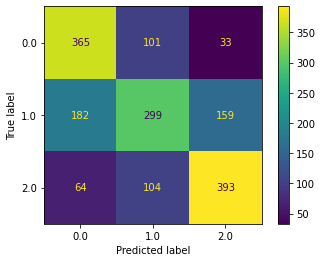

test accuracy  = 0.633
time taken for fold: 3.2 mins


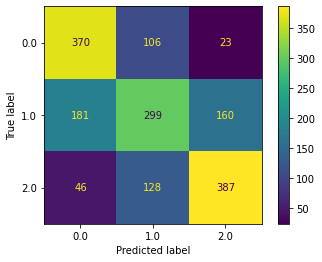

test accuracy  = 0.633
time taken for fold: 3.19 mins


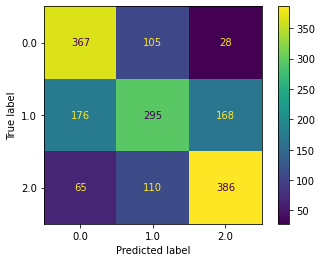

test accuracy  = 0.628
time taken for fold: 3.23 mins


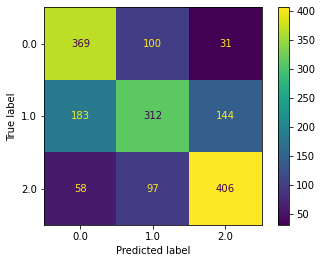

test accuracy  = 0.650
time taken for fold: 3.31 mins


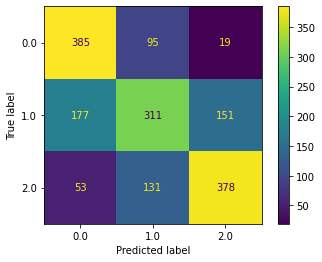

test accuracy  = 0.644
time taken for fold: 2.96 mins


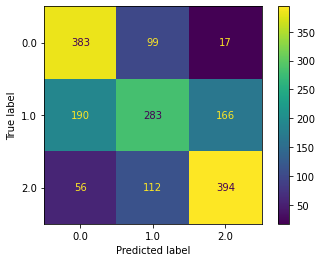

test accuracy  = 0.637
time taken for fold: 2.67 mins


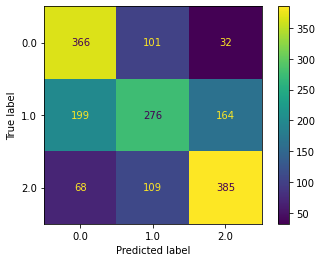

test accuracy  = 0.617
time taken for fold: 3.33 mins


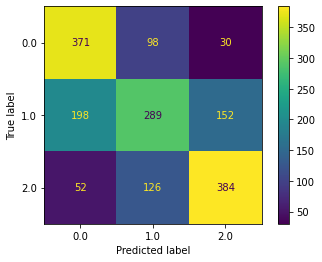

test accuracy  = 0.626
time taken for fold: 3.3 mins


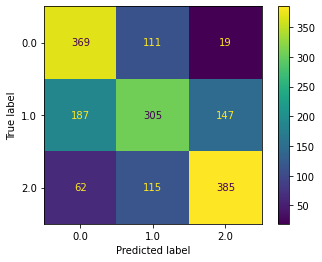

test accuracy  = 0.634
time taken for fold: 2.32 mins


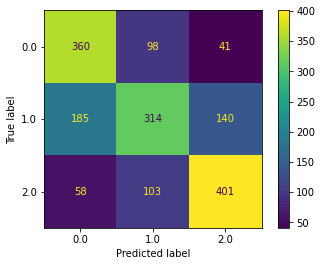

test accuracy  = 0.642
time taken for fold: 1.7 mins
time taken: 29.2 mins


In [23]:
t = time()
cv = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)
results = []
for train_ix, test_ix in cv.split(x, y):
    t_1 = time()
    x_train, x_test = x[train_ix, :], x[test_ix, :]
    y_train, y_test = y[train_ix], y[test_ix]
    result = pipe.fit(x_train, y_train)
    y_predict = result.predict(x_test)
    accuracy = balanced_accuracy_score(y_test, y_predict)
    results.append(accuracy)
    ConfusionMatrixDisplay.from_predictions(y_test, y_predict)
    plt.show()
    print("test accuracy  = %.3f"%(accuracy))
    print("time taken for fold: {} mins".format(round((time() - t_1)/60, 2)))
print("time taken: {} mins".format(round((time() - t)/60, 2)))

In [41]:
#training our classifier on the entire training data

In [42]:
t = time()
pipe.fit(x, y)
print("time taken: {} mins".format(round((time() - t)/60, 2)))

time taken: 1.99 mins


In [24]:
#vectorizing test dataset

In [25]:
with open("C:\\Users\\rahul\\training data\\processed_test.pkl", "rb") as f:
    test_data = pickle.load(f)

In [26]:
test_data.shape

(3000, 5)

In [27]:
test_data.head()

id  \
0  20803   
1  20187   
2  20953   
3  13777   
4  20990   

                                                                                                                                                                                                tweet  \
0                                                                                                                            @ 454dkhan @ Heisunberg _ Agr kse ko itni importantce chaeay ni tou √∞≈∏Àú‚Ä¶   
1                                                 logon ko alloo pyaz tomator me toh allah pak ka naam nazar aa jata hai pr aankhon k samne allah pak ke bande nazar √¢‚Ç¨¬¶ https // t . co / hBg7zS0viy   
2                                               @ LambaAlka Wafadaar bane rahane ka nayab tarika hai lamba ji aap us party se Judi hai jiska sardar @ ArvindKejriwal √¢‚Ç¨¬¶ https // t . co / krVTd1ZAEK   
3                                                                       @ varnishant @ narendramodi Chup bhosdike . He has been exonerated of all the charges . Tum log ghanta prove nahi kar paaye .   
4  RT @ HardeepSPuri √†¬®¬¶√†¬®¬æ√†¬®¬§√†¬®¬æ √†¬®¬∏√†¬©‚Äπ √†¬®¬∏√†¬®¬æ√†¬®¬≤√†¬®¬æ√†¬®¬π√†¬©‚Ç¨√†¬®¬ê √†¬®≈ì√†¬®¬ø √†¬®¬∏√†¬®¬≠√†¬®¬∏√†¬©ÀÜ √†¬®¬¶√†¬©‚Ä° √†¬®‚Ä†√†¬®¬ß√†¬®¬æ√†¬®¬∞√†¬©¬Å √†¬•¬• Praise the Great Giver who gives sustenance to all . Paid obeisance at Gurudwara Sr √¢‚Ç¨¬¶   

                                                                                                      cleaned_tweet  \
0                                                                             kse ko itni importantce chaeay ni tou   
1  logon ko alloo pyaz tomator me toh allah pak ka naam nazar aa jata hai pr aankhon samne allah pak ke bande nazar   
2                           wafadaar bane rahane ka nayab tarika hai lamba ji aap us party se judi hai jiska sardar   
3                       chup bhosdike he has been exonerated of all the charges tum log ghanta prove nahi kar paaye   
4                                 praise the great giver who gives sustenance to all paid obeisance at gurudwara sr   

                                              emojis  caps_share  
0                                                       0.000000  
1                                                       0.000000  
2                                                       0.026667  
3                                                       0.039474  
4  copyright copyright copyright copyright copyright    0.053333

In [9]:
with open("C:\\Users\\rahul\\Final models\\wv_model.pkl", "rb") as f:
    wv_model = pickle.load(f)
wv = wv_model.wv

In [3]:
with open("C:\\Users\\rahul\\Final models\\emoji_vectorizer.pkl", "rb") as f:
    vectorizer = pickle.load(f)

In [28]:
test_emojis = vectorizer.transform(test_data["emojis"])

In [29]:
test_emojis_array = test_emojis.toarray()

In [30]:
test_emojis_array.shape

(3000, 162)

In [31]:
t = time()
test_mat = np.empty((0, 300))
for _sentence in test_data["cleaned_tweet"]:
    sentence_mat = np.empty((300, 0))
    for _word in _sentence.split():
        if _word in wv.key_to_index.keys():
            sentence_mat = np.column_stack([sentence_mat, wv[_word]])
        else:
            sentence_mat = np.column_stack([sentence_mat, np.zeros(300)])
    sentence_vec = np.mean(sentence_mat, axis = 1)
    test_mat = np.vstack([test_mat, sentence_vec])
test_mat = np.column_stack([test_mat, test_emojis_array])
test_mat = np.column_stack([test_mat, test_data["caps_share"].values])

C:\Users\rahul\miniconda3\envs\thesis\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\rahul\miniconda3\envs\thesis\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


In [32]:
test_mat.shape

(3000, 463)

In [34]:
import csv

In [33]:
#loading the true labels for the test dataset

In [35]:
_truth = {}
_labels = []
with open("C:\\Users\\rahul\\training data\\test_labels.txt", "r") as f:
    _labels_file = csv.reader(f, delimiter = ",")
    for _row in _labels_file:
        if _row != "":
            _labels.append(_row[1])
            _truth[_row[0]] = _row[1]

In [36]:
y_true = np.array(_labels)

In [37]:
y_true

array(['neutral', 'neutral', 'neutral', ..., 'neutral', 'neutral',
       'negative'], dtype='<U8')

In [38]:
y_true = LE.fit_transform(y_true)

In [39]:
y_true

array([1, 1, 1, ..., 1, 1, 0], dtype=int64)

In [44]:
#predicting the labels

In [45]:
t = time()
y_predict = pipe.predict(test_mat)
print("time taken: {} mins".format(round((time() - t)/60, 2)))

time taken: 0.3 mins


In [46]:
score = balanced_accuracy_score(y_true, y_predict)

In [47]:
score

0.6896801346801347

In [52]:
#plotting confusion matrix

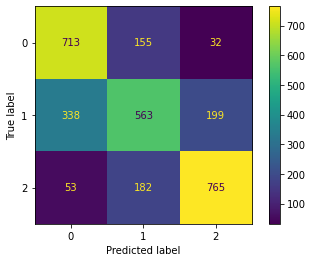

In [48]:
ConfusionMatrixDisplay.from_predictions(y_true, y_predict)

In [53]:
#classification report

In [50]:
from sklearn.metrics import classification_report

In [51]:
print(classification_report(y_true, y_predict))

              precision    recall  f1-score   support

           0       0.65      0.79      0.71       900
           1       0.63      0.51      0.56      1100
           2       0.77      0.77      0.77      1000

    accuracy                           0.68      3000
   macro avg       0.68      0.69      0.68      3000
weighted avg       0.68      0.68      0.68      3000



In [54]:
#adding true y labels to the testing set

In [55]:
test_mat = np.column_stack([test_mat, y_true])

In [56]:
test_mat.shape

(3000, 464)

In [58]:
x = test_mat[:, :-1]
y = test_mat[:, -1]

In [59]:
x.shape, y.shape

((3000, 463), (3000,))

In [57]:
#training our classifier on the test set too

In [60]:
t = time()
pipe.fit(x, y)
print("time taken: {} mins".format(round((time() - t)/60, 2)))

time taken: 0.07 mins


In [62]:
#saving pipeline and vectorizer

In [63]:
with open("C:\\Users\\rahul\\Complete thesis data\\Models\\classifier pipeline.pkl", "wb") as f:
    pickle.dump(pipe, f)

In [64]:
with open("C:\\Users\\rahul\\Complete thesis data\\Models\\emoji vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

In [6]:
with open("C:\\Users\\rahul\\Complete thesis data\\Models\\classifier pipeline.pkl", "rb") as f:
    pipe = pickle.load(f)

In [7]:
with open("C:\\Users\\rahul\\Complete thesis data\\Models\\emoji vectorizer.pkl", "rb") as f:
    vectorizer = pickle.load(f)

In [8]:
pipe

Pipeline(memory='C:\\Users\\rahul\\Complete thesis data\\SVC',
         steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('vector_preprocess',
                                                  Pipeline(steps=[('impute_values',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('scaler',
                                                                   PowerTransformer())]),
                                                  slice(0, 300, None))])),
                ('svc',
                 SVC(C=2, break_ties=True, class_weight='balanced', gamma=0.001,
                     random_state=42))])

In [65]:
#analyzing sentiment for all scraped data

In [9]:
class sentiment_analyzer:
    
    def __init__(self, _folder, _file, ids_list,_classifier):
        self.folder = _folder
        self.file = _file
        self.filepath = os.path.join(os.path.abspath(self.folder), self.file)
        self.pipe = _classifier
        self.ids_list = ids_list
        self.df = self.load_df()
        self.emojis_array = self.emoji_vectorize()
        self.corpus = self.vectorize_data()
        self.predicted = self.predict_score()
        self.output = self.save_output()
        
        
    def load_df(self):
        with open(self.filepath, "rb") as f:
            _df = pickle.load(f)
        _df = _df.where(_df["id"].isin(self.ids_list)).dropna(subset = ["id"])
        _df.reset_index(drop = True, inplace = True)
        return _df
    
    
    def emoji_vectorize(self):
        _emojis = vectorizer.transform(self.df["emojis"].values)
        return _emojis.toarray()
    
        
    def vectorize_data(self):
        corpus_mat = np.empty((0, 300))
        for _sentence in self.df["cleaned_tweet"]:
            sentence_mat = np.empty((300, 0))
            for _word in _sentence.split():
                if _word in wv.key_to_index.keys():
                    sentence_mat = np.column_stack([sentence_mat, wv[_word]])
                else:
                    sentence_mat = np.column_stack([sentence_mat, np.zeros(300)])
            sentence_vec = np.mean(sentence_mat, axis = 1)
            corpus_mat = np.vstack([corpus_mat, sentence_vec])
        
        corpus = np.column_stack([corpus_mat, self.emojis_array])
        corpus = np.column_stack([corpus, self.df["caps_share"].values])
        return corpus
    
    
    def predict_score(self):
        try:
            _predict = self.pipe.predict(self.corpus)
            self.df["polarity"] = _predict
        except:
            pass
        return self.df
    
    
    def save_output(self):
        with open(self.filepath, "wb") as f:
            pickle.dump(self.predicted, f)

In [13]:
t = time()
folder_list = ["Arunachal", "Assam", "Bengal", "Bihar", "Chandigarh", "Chattisgarh", \
               "Delhi", "Goa", "Gujarat", "Haryana", "Himachal","Jharkhand", "Karnataka", "Kerala", "Maharashtra", \
               "Manipur", "Meghalaya", "Mizoram", "MP", "Nagaland", "Odisha", "Punjab", "Rajasthan", \
               "Sikkim", "Telangana", "TN", "Tripura", "UP", "Uttarakhand"]
for _folder in folder_list:
    t_1 = time()
    wd = "C:\\Users\\rahul\\Complete thesis data\\Cleaned data\\"
    folder_name = wd + "complete cleaned " + _folder
    wd_2 = "C:\\Users\\rahul\\Complete thesis data\\Raw data\\"
    working_name = wd_2 + "august cleaned " + _folder
    with open(os.path.join(os.path.abspath(folder_name), "{} all tweet ids.pkl".format(_folder)), "rb") as f:
        ids_list = pickle.load(f)
    file_list = [_file for _file in os.listdir(working_name) if ".csv" in _file]
    for _file in file_list:
        sentiment_analyzer(working_name, _file, ids_list,pipe)
    print("time taken for {}: {} mins".format(_folder, round((time() - t_1)/60, 2)))
print("time taken: {} mins".format(round((time() - t)/60, 2)))

time taken for Arunachal: 0.15 mins
time taken for Assam: 2.11 mins
time taken for Bengal: 7.02 mins
time taken for Bihar: 4.29 mins
time taken for Chandigarh: 1.3 mins
time taken for Chattisgarh: 2.57 mins
time taken for Delhi: 61.79 mins
time taken for Goa: 0.72 mins
time taken for Gujarat: 9.84 mins
time taken for Haryana: 1.93 mins
time taken for Himachal: 0.17 mins
time taken for Jharkhand: 1.57 mins
time taken for Karnataka: 87.51 mins
time taken for Kerala: 2.92 mins
time taken for Maharashtra: 99.78 mins
time taken for Manipur: 0.25 mins
time taken for Meghalaya: 0.14 mins
time taken for Mizoram: 0.1 mins
time taken for MP: 2.49 mins
time taken for Nagaland: 0.13 mins
time taken for Odisha: 5.97 mins
time taken for Punjab: 1.38 mins
time taken for Rajasthan: 5.22 mins
time taken for Sikkim: 0.13 mins
time taken for Telangana: 0.72 mins
time taken for TN: 10.27 mins
time taken for Tripura: 0.24 mins
time taken for UP: 17.37 mins
time taken for Uttarakhand: 1.23 mins
time taken: 

In [12]:
t = time()
folder_list = ["Andhra_Pradesh"]
for _folder in folder_list:
    t_1 = time()
    wd = "C:\\Users\\rahul\\Complete thesis data\\Cleaned data\\"
    folder_name = wd + "complete cleaned " + _folder
    wd_2 = "C:\\Users\\rahul\\Complete thesis data\\Raw data\\"
    working_name = wd_2 + "august cleaned " + _folder
    with open(os.path.join(os.path.abspath(folder_name), "{} all tweet ids.pkl".format(_folder)), "rb") as f:
        ids_list = pickle.load(f)
    file_list = [_file for _file in os.listdir(working_name) if ".csv" in _file]
    for _file in file_list:
        sentiment_analyzer(working_name, _file, ids_list,pipe)
    print("time taken for {}: {} mins".format(_folder, round((time() - t_1)/60, 2)))
print("time taken: {} mins".format(round((time() - t)/60, 2)))

C:\Users\rahul\miniconda3\envs\thesis\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\rahul\miniconda3\envs\thesis\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


time taken for Andhra_Pradesh: 7.69 mins
time taken: 7.69 mins


In [8]:
#identifying terms similar to "muslim", "islam" and "islamic"

In [20]:
with open("C:\\Users\\rahul\\Final models\\new_search_terms.pkl", "rb") as f:
    new_search_terms = pickle.load(f)

In [21]:
len(new_search_terms)

175

In [9]:
terms = ["muslim", "islam", "islamic"]

In [10]:
import itertools
from collections import defaultdict

In [36]:
#Keeping only those words amongst the most similar which have a cosine distance of greater than or equal to 0.5 . 
#A cosine distance of 1.0 being exactly the same vector and 0.0 being completely orthogonal

In [31]:
search_terms = []
for _term in terms:
    similar_list = wv.most_similar(positive = [_term], topn = 100)
    for _tup in similar_list:
        if _tup[1] >= 0.5:
            search_terms.append(_tup[0])

In [32]:
search_terms

['hindu',
 'muslims',
 'sikh',
 'muzlim',
 'minority',
 'islamic',
 'moslem',
 'dalit',
 'hindus',
 'christian',
 'brahmin',
 'hindhu',
 'amuslim',
 'christan',
 'mushlim',
 'arab',
 'minorities',
 'shia',
 'religion',
 'islamist',
 'secular',
 'hinduism',
 'religion',
 'islaam',
 'christianity',
 'islamic',
 'religions',
 'secularism',
 'muslims',
 'buddhism',
 'quran',
 'hindus',
 'islamist',
 'islaamic',
 'muslim',
 'islam',
 'hindu',
 'islamik',
 'deobandi',
 'jihadi',
 'wahabi',
 'wahhabi']

In [34]:
search_terms = list(set(search_terms))

In [37]:
with open("C:\\Users\\rahul\\Complete thesis data\\Models\\restricted search terms.pkl", "wb") as f:
    pickle.dump(search_terms, f)

In [38]:
#Finding conversations in which tweets contain the terms relevant to us

In [2]:
with open("C:\\Users\\rahul\\Complete thesis data\\Models\\restricted search terms.pkl", "rb") as f:
    search_terms = pickle.load(f)

In [30]:
class find_conversation_ids:
    
    def __init__(self, _folder, _terms):
        self.folder = _folder
        self.file_list = [_file for _file in os.listdir(self.folder) if ".csv" in _file]
        self.terms = _terms
        self.conversation_ids = self.find_conversations()
        self.save_output = self.save_output()
    
        
    def find_conversations(self):
        conversation_ids = []
        for _file in self.file_list:
            with open(os.path.join(os.path.abspath(self.folder), _file), "rb") as f:
                _df = pickle.load(f)
            for i in range(_df.shape[0]):
                for _term in self.terms:
                    if _term in _df.at[i, "cleaned_tweet"]:
                        conversation_ids.append(_df.at[i, "conversation_id"])
                    else:
                        pass
        return list(set(conversation_ids))
    
    def save_output(self):
        _name = self.folder.rpartition("complete cleaned ")[-1]
        with open(os.path.join(os.path.abspath(self.folder), "{} restricted_convos_ids.pkl".format(_name)), "wb") as f:
            pickle.dump(self.conversation_ids, f)

In [31]:
t = time()
state_list = ["Andhra_Pradesh", "Arunachal", "Assam", "Bengal", "Bihar", "Chandigarh", "Chattisgarh", \
              "Delhi", "Goa", "Gujarat", "Haryana", "Himachal", "Jharkhand", "Karnataka", "Kerala", \
              "Maharashtra","Manipur", "Meghalaya", "Mizoram", "MP", "Nagaland", "Odisha", "Punjab", "Rajasthan", \
              "Sikkim", "Telangana", "TN", "Tripura", "UP", "Uttarakhand"]
for _state in state_list:
    t_1 = time()
    wd = "C:\\Users\\rahul\\Complete thesis data\\Cleaned data\\"
    folder_name = wd + "complete cleaned " + _state
    find_conversation_ids(folder_name, search_terms)
    print("finished {}".format(_state))
    print("time taken: {} mins".format(round((time() - t_1)/60, 2)))
print("finished program. time taken: {} mins".format(round((time() - t)/60, 2)))

finished Andhra_Pradesh
time taken: 0.71 mins
finished Arunachal
time taken: 0.03 mins
finished Assam
time taken: 0.28 mins
finished Bengal
time taken: 0.72 mins
finished Bihar
time taken: 0.46 mins
finished Chandigarh
time taken: 0.18 mins
finished Chattisgarh
time taken: 0.33 mins
finished Delhi
time taken: 2.53 mins
finished Goa
time taken: 0.08 mins
finished Gujarat
time taken: 0.86 mins
finished Haryana
time taken: 0.22 mins
finished Himachal
time taken: 0.02 mins
finished Jharkhand
time taken: 0.21 mins
finished Karnataka
time taken: 3.06 mins
finished Kerala
time taken: 0.31 mins
finished Maharashtra
time taken: 4.06 mins
finished Manipur
time taken: 0.06 mins
finished Meghalaya
time taken: 0.03 mins
finished Mizoram
time taken: 0.02 mins
finished MP
time taken: 0.36 mins
finished Nagaland
time taken: 0.03 mins
finished Odisha
time taken: 0.79 mins
finished Punjab
time taken: 0.22 mins
finished Rajasthan
time taken: 0.86 mins
finished Sikkim
time taken: 0.05 mins
finished Telang

In [58]:
#Counting conversations that contain these terms in every state

In [32]:
class count_conversations:
    
    def __init__(self, _folder):
        self.folder = _folder
        self.conversations = self.find_conversations()
        
    
    def find_conversations(self):
        _name = self.folder.rpartition("complete cleaned ")[-1]
        with open(os.path.join(os.path.abspath(self.folder), "{} restricted_convos_ids.pkl".format(_name)), "rb") as f:
            _conversations = pickle.load(f)
        return len(_conversations)

In [33]:
state_list = ["Andhra_Pradesh", "Arunachal", "Assam", "Bengal", "Bihar", "Chandigarh", "Chattisgarh", \
              "Delhi", "Goa", "Gujarat", "Haryana", "Himachal", "Jharkhand", "Karnataka", "Kerala", \
              "Maharashtra","Manipur", "Meghalaya", "Mizoram", "MP", "Nagaland", "Odisha", "Punjab", "Rajasthan", \
              "Sikkim", "Telangana", "TN", "Tripura", "UP", "Uttarakhand"]
restricted_convos_per_state = {}
for _state in state_list:
    wd = "C:\\Users\\rahul\\Complete thesis data\\Cleaned data\\"
    _folder = wd + "complete cleaned " + _state
    restricted_convos_per_state[_state] = count_conversations(_folder).conversations

In [34]:
restricted_convos_per_state

{'Andhra_Pradesh': 3205,
 'Arunachal': 36,
 'Assam': 1860,
 'Bengal': 5519,
 'Bihar': 3056,
 'Chandigarh': 1185,
 'Chattisgarh': 3228,
 'Delhi': 25514,
 'Goa': 300,
 'Gujarat': 7266,
 'Haryana': 2154,
 'Himachal': 44,
 'Jharkhand': 1440,
 'Karnataka': 15773,
 'Kerala': 2786,
 'Maharashtra': 22086,
 'Manipur': 74,
 'Meghalaya': 63,
 'Mizoram': 28,
 'MP': 2289,
 'Nagaland': 28,
 'Odisha': 1911,
 'Punjab': 1928,
 'Rajasthan': 4147,
 'Sikkim': 56,
 'Telangana': 277,
 'TN': 5542,
 'Tripura': 64,
 'UP': 8123,
 'Uttarakhand': 1016}

In [35]:
with open("C:\\Users\\rahul\\Complete thesis data\\Models\\restricted_convos_per_state.pkl", "wb") as f:
    pickle.dump(restricted_convos_per_state, f)

In [36]:
#Finding tweets that are a part of our relevant conversations

In [2]:
class find_relevant_tweets:
    
    def __init__(self, _folder, _conversations):
        self.folder = _folder
        self.file_list = [_file for _file in os.listdir(self.folder) if ".csv" in _file]
        self.conversations = _conversations
        self.folder_details = self.pinpoint_tweets()[0]
        self.relevant_tweets = self.pinpoint_tweets()[1]
        self.save_ids = self.save_tweet_ids()
        self.save_details = self.save_state_details()
        
        
    def pinpoint_tweets(self):
        _results = []
        folder_details = []
        relevant_tweets = []
        with open(os.path.join(os.path.abspath(self.folder), self.conversations), "rb") as f:
            _convos = pickle.load(f)
        for _file in self.file_list:
            daily_details = {}
            with open(os.path.join(os.path.abspath(self.folder), _file), "rb") as f:
                _df = pickle.load(f)
            daily_details["date"] = (_file.rpartition(".csv")[0]).rpartition(" ")[2]
            try:
                rel_df = _df.where(_df["conversation_id"].isin(_convos))
                rel_df.dropna(subset = ["conversation_id"], inplace = True)
                rel_df.drop_duplicates(subset = ["id"], inplace = True)
                rel_df.reset_index(drop = True, inplace = True)
                daily_details["total_tweets"] = rel_df.shape[0]
                for _id in rel_df["id"]:
                    relevant_tweets.append(_id)
            except:
                daily_details["total_tweets"] = 0
            try:
                neg_df = rel_df.where(rel_df["polarity"] == 0.0)
                neg_df.dropna(subset = ["polarity"], inplace = True)
                neg_df.reset_index(drop = True, inplace = True)
                daily_details["negative_tweets"] = neg_df.shape[0]
            except:
                daily_details["negative_tweets"] = 0
            folder_details.append(daily_details)
        
        _results.append(folder_details)
        _results.append(relevant_tweets)
        return _results
    
    def save_tweet_ids(self):
        _name = self.folder.rpartition("complete cleaned ")[-1]
        with open(os.path.join(os.path.abspath(self.folder), "{} rel_tweet_ids.pkl".format(_name)), "wb") as f:
            pickle.dump(self.relevant_tweets, f)
            
    def save_state_details(self):
        _name = self.folder.rpartition("complete cleaned ")[-1]
        details_df = pd.DataFrame.from_dict(self.folder_details)
        with open(os.path.join(os.path.abspath(self.folder), "{} daily_details.pkl".format(_name)), "wb") as f:
            pickle.dump(details_df, f)

In [3]:
t = time()
state_list = ["Andhra_Pradesh", "Arunachal", "Assam", "Bengal", "Bihar", "Chandigarh", "Chattisgarh", \
              "Delhi", "Goa", "Gujarat", "Haryana", "Himachal", "Jharkhand", "Karnataka", "Kerala", \
              "Maharashtra","Manipur", "Meghalaya", "Mizoram", "MP", "Nagaland", "Odisha", "Punjab", "Rajasthan", \
              "Sikkim", "Telangana", "TN", "Tripura", "UP", "Uttarakhand"]
for _state in state_list:
    t_1 = time()
    wd = "C:\\Users\\rahul\\Complete thesis data\\Cleaned data\\"
    folder_name = wd + "complete cleaned " + _state
    find_relevant_tweets(folder_name, "{} restricted_convos_ids.pkl".format(_state))
    print("{} completed".format(_state))
    print("time taken: {} mins".format(round((time() - t_1)/60, 2)))
print("time taken: {} mins".format(round((time() - t_1)/60,2)))

Andhra_Pradesh completed
time taken: 0.11 mins
Arunachal completed
time taken: 0.05 mins
Assam completed
time taken: 0.07 mins
Bengal completed
time taken: 0.09 mins
Bihar completed
time taken: 0.08 mins
Chandigarh completed
time taken: 0.06 mins
Chattisgarh completed
time taken: 0.08 mins
Delhi completed
time taken: 0.23 mins
Goa completed
time taken: 0.06 mins
Gujarat completed
time taken: 0.15 mins
Haryana completed
time taken: 0.08 mins
Himachal completed
time taken: 0.04 mins
Jharkhand completed
time taken: 0.07 mins
Karnataka completed
time taken: 0.23 mins
Kerala completed
time taken: 0.12 mins
Maharashtra completed
time taken: 0.23 mins
Manipur completed
time taken: 0.07 mins
Meghalaya completed
time taken: 0.04 mins
Mizoram completed
time taken: 0.04 mins
MP completed
time taken: 0.1 mins
Nagaland completed
time taken: 0.06 mins
Odisha completed
time taken: 0.13 mins
Punjab completed
time taken: 0.08 mins
Rajasthan completed
time taken: 0.11 mins
Sikkim completed
time taken: 0

In [4]:
#Counting tweets that contain relevant terms

In [8]:
class count_tweets:
    
    def __init__(self, _folder):
        self.folder = _folder
        self.tweet_ids = self.count_tweets()
        
    
    def count_tweets(self):
        _name = self.folder.rpartition("complete cleaned ")[-1]
        with open(os.path.join(os.path.abspath(self.folder), "{} rel_tweet_ids.pkl".format(_name)), "rb") as f:
            tweet_ids = pickle.load(f)
        return len(tweet_ids)

In [11]:
rel_tweets_per_state = {}
state_list = ["Andhra_Pradesh", "Arunachal", "Assam", "Bengal", "Bihar", "Chandigarh", "Chattisgarh", \
              "Delhi", "Goa", "Gujarat", "Haryana", "Himachal", "Jharkhand", "Karnataka", "Kerala", \
              "Maharashtra","Manipur", "Meghalaya", "Mizoram", "MP", "Nagaland", "Odisha", "Punjab", "Rajasthan", \
              "Sikkim", "Telangana", "TN", "Tripura", "UP", "Uttarakhand"]
for _state in state_list:
    wd = "C:\\Users\\rahul\\Complete thesis data\\Cleaned data\\"
    folder_name = wd + "complete cleaned " + _state
    rel_tweets_per_state[_state] = count_tweets(folder_name).tweet_ids

In [12]:
rel_tweets_per_state

{'Andhra_Pradesh': 4668,
 'Arunachal': 54,
 'Assam': 2693,
 'Bengal': 9084,
 'Bihar': 3916,
 'Chandigarh': 1627,
 'Chattisgarh': 4018,
 'Delhi': 50223,
 'Goa': 532,
 'Gujarat': 10349,
 'Haryana': 2663,
 'Himachal': 46,
 'Jharkhand': 2038,
 'Karnataka': 30600,
 'Kerala': 4238,
 'Maharashtra': 45445,
 'Manipur': 105,
 'Meghalaya': 67,
 'Mizoram': 29,
 'MP': 2899,
 'Nagaland': 30,
 'Odisha': 2577,
 'Punjab': 2428,
 'Rajasthan': 5735,
 'Sikkim': 62,
 'Telangana': 348,
 'TN': 9057,
 'Tripura': 81,
 'UP': 12206,
 'Uttarakhand': 1330}

In [13]:
with open("C:\\Users\\rahul\\Complete thesis data\\Models\\relevant_tweets_per_state.pkl", "wb") as f:
    pickle.dump(rel_tweets_per_state, f)

In [14]:
#creating daily stats of the entire country

In [17]:
dates = pd.date_range(start = "2020-01-22", end = "2020-05-30", periods = 130)
period = []
for _date in dates:
    a = _date.date()
    period.append(str(a))

In [18]:
period

['2020-01-22',
 '2020-01-23',
 '2020-01-24',
 '2020-01-25',
 '2020-01-26',
 '2020-01-27',
 '2020-01-28',
 '2020-01-29',
 '2020-01-30',
 '2020-01-31',
 '2020-02-01',
 '2020-02-02',
 '2020-02-03',
 '2020-02-04',
 '2020-02-05',
 '2020-02-06',
 '2020-02-07',
 '2020-02-08',
 '2020-02-09',
 '2020-02-10',
 '2020-02-11',
 '2020-02-12',
 '2020-02-13',
 '2020-02-14',
 '2020-02-15',
 '2020-02-16',
 '2020-02-17',
 '2020-02-18',
 '2020-02-19',
 '2020-02-20',
 '2020-02-21',
 '2020-02-22',
 '2020-02-23',
 '2020-02-24',
 '2020-02-25',
 '2020-02-26',
 '2020-02-27',
 '2020-02-28',
 '2020-02-29',
 '2020-03-01',
 '2020-03-02',
 '2020-03-03',
 '2020-03-04',
 '2020-03-05',
 '2020-03-06',
 '2020-03-07',
 '2020-03-08',
 '2020-03-09',
 '2020-03-10',
 '2020-03-11',
 '2020-03-12',
 '2020-03-13',
 '2020-03-14',
 '2020-03-15',
 '2020-03-16',
 '2020-03-17',
 '2020-03-18',
 '2020-03-19',
 '2020-03-20',
 '2020-03-21',
 '2020-03-22',
 '2020-03-23',
 '2020-03-24',
 '2020-03-25',
 '2020-03-26',
 '2020-03-27',
 '2020-03-

In [19]:
national_daily_details = []
folder_list = ["Andhra_Pradesh", "Arunachal", "Assam", "Bengal", "Bihar", "Chandigarh", "Chattisgarh", \
               "Delhi", "Goa", "Gujarat", "Haryana", "Himachal", "Jharkhand", "Karnataka", "Kerala", \
               "Maharashtra","Manipur", "Meghalaya", "Mizoram", "MP", "Nagaland", "Odisha", "Punjab", "Rajasthan", \
               "Sikkim", "Telangana", "TN", "Tripura", "UP", "Uttarakhand"]
for _date in period:
    date_details = {}
    date_details["date"] = _date
    for _folder in folder_list:
        wd = "C:\\Users\\rahul\\Complete thesis data\\Cleaned data\\"
        _name = wd + "complete cleaned " + _folder
        with open(os.path.join(os.path.abspath(_name), "{} daily_details.pkl".format(_folder)), "rb") as f:
            details_df = pickle.load(f)
        details_dict = details_df.to_dict()
        _date_keys = list(details_dict["date"].keys())
        _date_values = list(details_dict["date"].values())
        date_details.setdefault("total_tweets", 0)
        date_details.setdefault("negative_tweets", 0)
        try:
            i = _date_keys[_date_values.index(_date)]
            date_details["total_tweets"] += details_dict["total_tweets"][i]
            date_details["negative_tweets"] += details_dict["negative_tweets"][i]
        except:
            date_details["total_tweets"] += 0
            date_details["negative_tweets"] += 0
    national_daily_details.append(date_details)

In [20]:
national_df = pd.DataFrame.from_dict(national_daily_details)

In [22]:
national_df["neg_share"] = national_df["negative_tweets"]/national_df["total_tweets"]

In [23]:
national_df

date  total_tweets  negative_tweets  neg_share
0    2020-01-22          1471              412   0.280082
1    2020-01-23          1491              437   0.293092
2    2020-01-24          1364              389   0.285191
3    2020-01-25          1535              449   0.292508
4    2020-01-26          1854              462   0.249191
..          ...           ...              ...        ...
125  2020-05-26          1260              248   0.196825
126  2020-05-27          1283              247   0.192518
127  2020-05-28          1353              286   0.211382
128  2020-05-29          1125              306   0.272000
129  2020-05-30          1560              276   0.176923

[130 rows x 4 columns]

<AxesSubplot:>

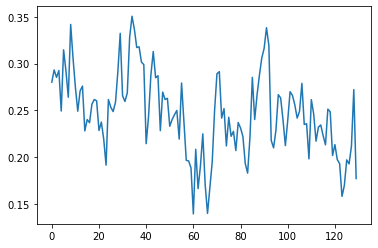

In [24]:
national_df["neg_share"].plot()

In [25]:
with open("C:\\Users\\rahul\\Complete thesis data\\Models\\national_data_restricted_terms.pkl", "wb") as f:
    pickle.dump(national_df, f)

In [26]:
#checking out target variable "daily negative share" for autocorrelation

In [31]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf

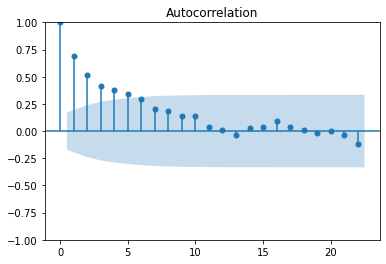

In [29]:
acf_plot = plot_acf(national_df["neg_share"].values)

C:\Users\rahul\miniconda3\envs\thesis\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


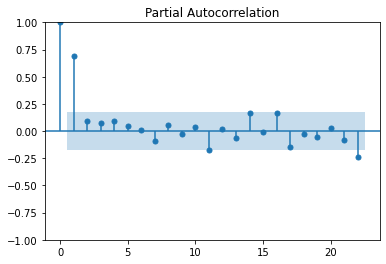

In [30]:
pacf_plot = plot_pacf(national_df["neg_share"].values)

In [ ]:
#conducting unit root test to check if series is stationary

In [24]:
#The ACF has a gradual decline to 0 after a few lags and the PACF drops off immediately to 0. This indicates an AR(1)
#process most likely. However, we still run a Grid Search on other (p, d, q) combinations to check if there are other
#model combinations which give us a lower AIC, instead of trying multiple models manually. We also make sure that the 
#coefficients of the AR/MA parameters are statistically significant and only consider those models in our final analysis.

In [31]:
#creating dummy variables for our intervention and other events that we feel might have an outsized effect on the variable

In [33]:
def make_covid_dummy(x):
    if x >= "2020-03-25":
        return 1
    else:
        return 0

In [34]:
def make_shaheen_bagh_dummy(x):
    if x <= "2020-03-24":
        return 1
    else:
        return 0

In [35]:
def make_delhi_riots_dummy(x):
    if x >= "2020-02-23" and x <= "2020-02-29":
        return 1
    else:
        return 0

In [42]:
def make_lockdown_days(x):
    if x >= "2020-03-25" and int(x.rpartition("-")[0][-1:]) == 3:
        days = int(x.rpartition("-")[2]) - int("2020-03-25".rpartition("-")[2])
        return days
    elif x >= "2020-03-25" and int(x.rpartition("-")[0][-1:]) == 4:
        days = 31 + int(x.rpartition("-")[2]) - int("2020-03-25".rpartition("-")[2])
        return days
    elif x >= "2020-03-25" and int(x.rpartition("-")[0][-1:]) == 5:
        days = 61 + int(x.rpartition("-")[2]) - int("2020-03-25".rpartition("-")[2])
        return days
    else:
        return 0

In [43]:
national_df["covid_lockdown"] = national_df["date"].apply(make_covid_dummy)
national_df["shaheen_bagh"] = national_df["date"].apply(make_shaheen_bagh_dummy)
national_df["delhi_riots"] = national_df["date"].apply(make_delhi_riots_dummy)
national_df["lockdown_days"] = national_df["date"].apply(make_lockdown_days)

In [68]:
national_df

total_tweets  negative_tweets  neg_share  covid_lockdown  \
date                                                                   
2020-01-22          1471              412   0.280082               0   
2020-01-23          1491              437   0.293092               0   
2020-01-24          1364              389   0.285191               0   
2020-01-25          1535              449   0.292508               0   
2020-01-26          1854              462   0.249191               0   
2020-01-27          1570              494   0.314650               0   
2020-01-28          1397              408   0.292054               0   
2020-01-29          1326              350   0.263952               0   
2020-01-30          1489              509   0.341840               0   
2020-01-31          1364              417   0.305718               0   
2020-02-01          1074              295   0.274674               0   
2020-02-02          1374              342   0.248908               0   
2020-02-03          1404              380   0.270655               0   
2020-02-04          1287              355   0.275835               0   
2020-02-05          1119              255   0.227882               0   
2020-02-06          1504              361   0.240027               0   
2020-02-07          1255              297   0.236653               0   
2020-02-08          1170              300   0.256410               0   
2020-02-09          1308              342   0.261468               0   
2020-02-10          1192              310   0.260067               0   
2020-02-11          1305              298   0.228352               0   
2020-02-12          1142              271   0.237303               0   
2020-02-13           903              198   0.219269               0   
2020-02-14          1119              214   0.191242               0   
2020-02-15           834              218   0.261391               0   
2020-02-16           928              235   0.253233               0   
2020-02-17          1046              260   0.248566               0   
2020-02-18          1238              320   0.258481               0   
2020-02-19          1129              329   0.291408               0   
2020-02-20          1261              419   0.332276               0   
2020-02-21          1364              362   0.265396               0   
2020-02-22          1253              325   0.259377               0   
2020-02-23          1333              358   0.268567               0   
2020-02-24          2197              721   0.328175               0   
2020-02-25          3052             1070   0.350590               0   
2020-02-26          2890              973   0.336678               0   
2020-02-27          2699              856   0.317155               0   
2020-02-28          2372              754   0.317875               0   
2020-02-29          1937              584   0.301497               0   
2020-03-01          1777              531   0.298818               0   
2020-03-02          2133              457   0.214252               0   
2020-03-03          1548              376   0.242894               0   
2020-03-04          1143              329   0.287839               0   
2020-03-05          1138              356   0.312830               0   
2020-03-06          1215              346   0.284774               0   
2020-03-07          1415              406   0.286926               0   
2020-03-08          1188              271   0.228114               0   
2020-03-09           876              236   0.269406               0   
2020-03-10          1021              267   0.261508               0   
2020-03-11           765              201   0.262745               0   
2020-03-12           962              224   0.232848               0   
2020-03-13           829              199   0.240048               0   
2020-03-14          1003              246   0.245264               0   
2020-03-15          1021              255   0.249755

In [65]:
national_df.set_index(national_df["date"], inplace = True)

In [67]:
national_df.drop(columns = ["date"], inplace = True)

In [69]:
with open("C:\\Users\\rahul\\Complete thesis data\\Models\\daily_neg_share_with_dummies.pkl", "wb") as f:
    pickle.dump(national_df, f)

In [70]:
#running Grid Search to find SARIMA hyperparameters that give us the lowest AIC and statistically significant AR/MA parameters

In [2]:
with open("C:\\Users\\rahul\\Complete thesis data\\Models\\daily_neg_share_with_dummies.pkl", "rb") as f:
    data = pickle.load(f)

In [3]:
pd.set_option("display.max_row", None)

In [4]:
data

total_tweets  negative_tweets  neg_share  covid_lockdown  \
date                                                                   
2020-01-22          1471              412   0.280082               0   
2020-01-23          1491              437   0.293092               0   
2020-01-24          1364              389   0.285191               0   
2020-01-25          1535              449   0.292508               0   
2020-01-26          1854              462   0.249191               0   
2020-01-27          1570              494   0.314650               0   
2020-01-28          1397              408   0.292054               0   
2020-01-29          1326              350   0.263952               0   
2020-01-30          1489              509   0.341840               0   
2020-01-31          1364              417   0.305718               0   
2020-02-01          1074              295   0.274674               0   
2020-02-02          1374              342   0.248908               0   
2020-02-03          1404              380   0.270655               0   
2020-02-04          1287              355   0.275835               0   
2020-02-05          1119              255   0.227882               0   
2020-02-06          1504              361   0.240027               0   
2020-02-07          1255              297   0.236653               0   
2020-02-08          1170              300   0.256410               0   
2020-02-09          1308              342   0.261468               0   
2020-02-10          1192              310   0.260067               0   
2020-02-11          1305              298   0.228352               0   
2020-02-12          1142              271   0.237303               0   
2020-02-13           903              198   0.219269               0   
2020-02-14          1119              214   0.191242               0   
2020-02-15           834              218   0.261391               0   
2020-02-16           928              235   0.253233               0   
2020-02-17          1046              260   0.248566               0   
2020-02-18          1238              320   0.258481               0   
2020-02-19          1129              329   0.291408               0   
2020-02-20          1261              419   0.332276               0   
2020-02-21          1364              362   0.265396               0   
2020-02-22          1253              325   0.259377               0   
2020-02-23          1333              358   0.268567               0   
2020-02-24          2197              721   0.328175               0   
2020-02-25          3052             1070   0.350590               0   
2020-02-26          2890              973   0.336678               0   
2020-02-27          2699              856   0.317155               0   
2020-02-28          2372              754   0.317875               0   
2020-02-29          1937              584   0.301497               0   
2020-03-01          1777              531   0.298818               0   
2020-03-02          2133              457   0.214252               0   
2020-03-03          1548              376   0.242894               0   
2020-03-04          1143              329   0.287839               0   
2020-03-05          1138              356   0.312830               0   
2020-03-06          1215              346   0.284774               0   
2020-03-07          1415              406   0.286926               0   
2020-03-08          1188              271   0.228114               0   
2020-03-09           876              236   0.269406               0   
2020-03-10          1021              267   0.261508               0   
2020-03-11           765              201   0.262745               0   
2020-03-12           962              224   0.232848               0   
2020-03-13           829              199   0.240048               0   
2020-03-14          1003              246   0.245264               0   
2020-03-15          1021              255   0.249755

In [71]:
#Defining the grid we will use for the search

In [5]:
def sarima_configs(seasonal = [0, 7]):
    models = []
    p_params = [0, 1, 2, 3]
    d_params = [1]
    q_params = [0, 1, 2, 3]
    t_params = ["n", "c", "t", "ct"]
    P_params = [0, 1, 2, 3]
    D_params = [0]
    Q_params = [0, 1, 2, 3]
    m_params = seasonal
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    cfg = [(p, d, q), (P, D, Q, m), t]
                                    models.append(cfg)
    return models

In [6]:
cfg_list = sarima_configs()

In [7]:
cfg_list

[[(0, 1, 0), (0, 0, 0, 0), 'n'],
 [(0, 1, 0), (0, 0, 0, 7), 'n'],
 [(0, 1, 0), (0, 0, 1, 0), 'n'],
 [(0, 1, 0), (0, 0, 1, 7), 'n'],
 [(0, 1, 0), (0, 0, 2, 0), 'n'],
 [(0, 1, 0), (0, 0, 2, 7), 'n'],
 [(0, 1, 0), (0, 0, 3, 0), 'n'],
 [(0, 1, 0), (0, 0, 3, 7), 'n'],
 [(0, 1, 0), (1, 0, 0, 0), 'n'],
 [(0, 1, 0), (1, 0, 0, 7), 'n'],
 [(0, 1, 0), (1, 0, 1, 0), 'n'],
 [(0, 1, 0), (1, 0, 1, 7), 'n'],
 [(0, 1, 0), (1, 0, 2, 0), 'n'],
 [(0, 1, 0), (1, 0, 2, 7), 'n'],
 [(0, 1, 0), (1, 0, 3, 0), 'n'],
 [(0, 1, 0), (1, 0, 3, 7), 'n'],
 [(0, 1, 0), (2, 0, 0, 0), 'n'],
 [(0, 1, 0), (2, 0, 0, 7), 'n'],
 [(0, 1, 0), (2, 0, 1, 0), 'n'],
 [(0, 1, 0), (2, 0, 1, 7), 'n'],
 [(0, 1, 0), (2, 0, 2, 0), 'n'],
 [(0, 1, 0), (2, 0, 2, 7), 'n'],
 [(0, 1, 0), (2, 0, 3, 0), 'n'],
 [(0, 1, 0), (2, 0, 3, 7), 'n'],
 [(0, 1, 0), (3, 0, 0, 0), 'n'],
 [(0, 1, 0), (3, 0, 0, 7), 'n'],
 [(0, 1, 0), (3, 0, 1, 0), 'n'],
 [(0, 1, 0), (3, 0, 1, 7), 'n'],
 [(0, 1, 0), (3, 0, 2, 0), 'n'],
 [(0, 1, 0), (3, 0, 2, 7), 'n'],
 [(0, 1, 0

In [8]:
def split_dataset(some_data, n_test):
    return some_data.iloc[:-n_test, :], some_data.iloc[-n_test:, :]

In [9]:
train, test = split_dataset(data, n_test = 10)

In [10]:
train.shape, test.shape

((120, 7), (10, 7))

In [19]:
#finding specification with lowest AIC for 4 exog parameters and d = 1

In [25]:
t = time()
rel_models = []

exog = np.column_stack([data["covid_lockdown"], data["shaheen_bagh"], data["delhi_riots"], data["lockdown_days"]])
with catch_warnings():
    filterwarnings("ignore")
    for cfg in cfg_list:
        try:
            order, sorder, trend = cfg
            model = SARIMAX(endog = data["neg_share"].values, order = order, seasonal_order = sorder, trend = trend, exog = exog)
            model_fit = model.fit(disp = False, method = "nm", maxiter = 1000)
            p_value_list = None
            if trend == "n":
                p_value_list = model_fit.pvalues[4:][:-1]
            elif trend == "c" or "t":
                p_value_list = model_fit.pvalues[5:][:-1]
                p_value_list = np.insert(p_value_list, 0, model_fit.pvalues[0])
            else:
                p_value_list = model_fit.pvalues[6:][:-1]
                p_value_list = np.insert(p_value_list, 0, model_fit.pvalues[:2])
            p_vals_mask = [p_val <= 0.055 for p_val in p_value_list]
            if sum(p_vals_mask) == len(p_vals_mask):
                rel_models.append((cfg, model_fit.aic))
                print("Model > [%s]%.3f"%(str(str(cfg)), model_fit.aic))
            else:
                pass
        except:
            pass
print("time taken: {} mins".format(round((time() - t)/60, 2)))

Model > [[(0, 1, 0), (0, 0, 0, 0), 'n']]-497.304
Model > [[(0, 1, 0), (0, 0, 0, 7), 'n']]-497.304
Model > [[(0, 1, 1), (0, 0, 0, 0), 'n']]-507.228
Model > [[(0, 1, 1), (0, 0, 0, 7), 'n']]-507.228
Model > [[(0, 1, 2), (0, 0, 0, 0), 'n']]-512.222
Model > [[(0, 1, 2), (0, 0, 0, 7), 'n']]-512.222
Model > [[(0, 1, 2), (2, 0, 1, 7), 'n']]-515.227
Model > [[(0, 1, 2), (0, 0, 0, 0), 't']]-515.150
Model > [[(0, 1, 2), (0, 0, 0, 7), 't']]-515.150
Model > [[(0, 1, 2), (1, 0, 1, 7), 't']]-512.225
Model > [[(1, 1, 0), (0, 0, 0, 0), 'n']]-501.584
Model > [[(1, 1, 0), (0, 0, 0, 7), 'n']]-501.584
Model > [[(1, 1, 1), (0, 0, 0, 0), 'n']]-514.148
Model > [[(1, 1, 1), (0, 0, 0, 7), 'n']]-514.148
Model > [[(1, 1, 3), (0, 0, 0, 0), 'n']]-514.313
Model > [[(1, 1, 3), (0, 0, 0, 7), 'n']]-514.313
Model > [[(1, 1, 3), (1, 0, 1, 7), 'n']]-512.608
Model > [[(1, 1, 3), (0, 0, 0, 0), 't']]-517.661
Model > [[(1, 1, 3), (0, 0, 0, 7), 't']]-517.661
Model > [[(3, 1, 0), (0, 0, 0, 0), 'n']]-506.998
Model > [[(3, 1, 0),

In [26]:
rel_models.sort(key = lambda tup: tup[1])

In [27]:
rel_models

[([(1, 1, 3), (0, 0, 0, 0), 't'], -517.6609017775168),
 ([(1, 1, 3), (0, 0, 0, 7), 't'], -517.6609017775168),
 ([(0, 1, 2), (2, 0, 1, 7), 'n'], -515.2267319271709),
 ([(0, 1, 2), (0, 0, 0, 0), 't'], -515.1500578996335),
 ([(0, 1, 2), (0, 0, 0, 7), 't'], -515.1500578996335),
 ([(1, 1, 3), (0, 0, 0, 0), 'n'], -514.3127222033215),
 ([(1, 1, 3), (0, 0, 0, 7), 'n'], -514.3127222033215),
 ([(1, 1, 1), (0, 0, 0, 0), 'n'], -514.1478195923769),
 ([(1, 1, 1), (0, 0, 0, 7), 'n'], -514.1478195923769),
 ([(1, 1, 3), (1, 0, 1, 7), 'n'], -512.6077745747264),
 ([(0, 1, 2), (1, 0, 1, 7), 't'], -512.2250122760867),
 ([(0, 1, 2), (0, 0, 0, 0), 'n'], -512.2222778771458),
 ([(0, 1, 2), (0, 0, 0, 7), 'n'], -512.2222778771458),
 ([(0, 1, 1), (0, 0, 0, 0), 'n'], -507.228176273901),
 ([(0, 1, 1), (0, 0, 0, 7), 'n'], -507.228176273901),
 ([(3, 1, 0), (0, 0, 0, 0), 'n'], -506.9984717231853),
 ([(3, 1, 0), (0, 0, 0, 7), 'n'], -506.9984717231853),
 ([(1, 1, 0), (0, 0, 0, 0), 'n'], -501.5836315266049),
 ([(1, 1, 0)

In [46]:
with open("C:\\Users\\rahul\\Complete thesis data\\Models\\restricted search 1 exog sarima hyperparameters.pkl", "wb") as f:
    pickle.dump(rel_models, f)

In [43]:
order, sorder, trend = [(0, 1, 2), (0, 0, 0, 0), 't']
exog = np.column_stack([data["covid_lockdown"], data["shaheen_bagh"], data["delhi_riots"], data["lockdown_days"]])
model = SARIMAX(endog = data["neg_share"].values, order = order, seasonal_order = sorder, trend = trend, exog = exog)
model_fit = model.fit(disp = False, method = "nm", maxiter = 1000)
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  130
Model:               SARIMAX(0, 1, 2)   Log Likelihood                 265.575
Date:                Wed, 29 Jun 2022   AIC                           -515.150
Time:                        18:36:22   BIC                           -492.272
Sample:                             0   HQIC                          -505.854
                                - 130                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift      -6.847e-05   2.59e-05     -2.641      0.008      -0.000   -1.77e-05
x1             0.2075      0.014     14.407      0.000       0.179       0.236
x2             0.1873      0.014     13.004      0.000       0.159       0.216
x3             0.0340      0.017      2.016      0.044       0.001       0.067
x4             0.0066      0.003      2.435      0.015       0.001       0.012
ma.L1         -0.4555      0.086     -5.294      0.000      -0.624      -0.287
ma.L2         -0.3001      0.091     -3.284      0.001      -0.479      -0.121
sigma2         0.0009      0.000      6.914      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.21   Jarque-Bera (JB):                 1.01
Prob(Q):                              0.65   Prob(JB):                         0.60
Heteroskedasticity (H):               0.95   Skew:                             0.16
Prob(H) (two-sided):                  0.88   Kurtosis:                         2.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.39e+19. Standard errors may be unstable.
"""

In [44]:
model_fit.mle_retvals

{'fopt': -2.0428848380755134,
 'iterations': 682,
 'fcalls': 989,
 'warnflag': 0,
 'converged': True}

In [47]:
#We select the ARMA models with the lowest AIC for all of our 4 specifications. We will use each of these models to 
#predict the next 10 days of "neg-share" and calculate the MAPe(Mean Absolute Percentage Error) over these 10 forecasts.
#The model that gives us the lowest MAPE out of these 4 is what we decide to go for as our final mdodel.

In [45]:
class mape_validation:
    
    def __init__(self, some_data, n_test,cfg_list, endog):
        self.data = some_data
        self.n_test = n_test
        self.cfg_list = cfg_list
        self.endog = endog
        self.mape_result = self.model_search()
        
     
    @staticmethod
    def split_data(_data, n_test):
        return _data.iloc[:-n_test, :], _data.iloc[-n_test:, :]
    
    @staticmethod
    def measure_mape(actual, predicted):
        return mean_absolute_percentage_error(actual, predicted)
    
    @staticmethod
    def sarima_forecast(history, config, exog_train, exog_test):
        order, sorder, trend = config
        model = SARIMAX(history, order = order, seasonal_order = sorder, trend = trend, exog = exog_train)
        model_fit = model.fit(disp = False, method = "nm", maxiter = 1000)
        y_hat = model_fit.predict(len(history), len(history), exog = exog_test)
        return y_hat[0]
    

    def walk_forward_validation(self, train_data, test_data, endog, cfg):
        predictions = []
        history = [x for x in train_data[endog].values]
        exog_train = np.column_stack([train_data["covid_lockdown"], train_data["shaheen_bagh"], train_data["delhi_riots"], train_data["lockdown_days"]])
        for i in range(len(test_data[endog].values)):
            exog_test = np.array([test_data["covid_lockdown"][i], test_data["shaheen_bagh"][i], test_data["delhi_riots"][i], test_data["lockdown_days"][i]])
            predicted = self.sarima_forecast(history, cfg, exog_train, exog_test)
            predictions.append(predicted)
            history.append(test_data[endog].values[i])
            exog_train = np.vstack([exog_train, exog_test])
        mape_error = self.measure_mape(test_data[endog].values, predictions)
        return mape_error
        
    
    def model_search(self):
        train, test = self.split_data(self.data, self.n_test)
        exog_train = np.column_stack([train["covid_lockdown"], train["shaheen_bagh"], train["delhi_riots"], train["lockdown_days"]])
        with catch_warnings():
            filterwarnings("ignore")
            for cfg in self.cfg_list:
                try:
                    order, sorder, trend = cfg
                    model = SARIMAX(endog = train[self.endog].values, order = order, seasonal_order = sorder, trend = trend, exog = exog_train)
                    model_fit = model.fit(disp = False, method = "nm", maxiter = 1000)
                    p_value_list = None
                    if trend == "n":
                        p_value_list = model_fit.pvalues[4:][:-1]
                    elif trend == "c" or "t" :
                        p_value_list = model_fit.pvalues[5:][:-1]
                        p_value_list = np.insert(p_value_list, 0, model_fit.pvalues[0])
                    else:
                        p_value_list = model_fit.pvalues[6][:-1]
                        p_value_list = np.insert(p_value_list, 0, model_fit.pvalues[:2])
                    p_vals_mask = [p_val <= 0.055 for p_val in p_value_list]
                    if sum(p_vals_mask) == len(p_vals_mask):
                        mape = self.walk_forward_validation(train, test, self.endog, cfg)
                        print("Model > [%s]%.3f"%(str(cfg), mape))
                    else:
                        pass
                except:
                    pass
        return (str(cfg), mape)

In [117]:
#Both the specifications with dummy variables for "covid-lockdown" and "shaheen-bagh" and just for "covid-lockdown"
#give the same MAPE of 0.145
#We choose the specification with both dummies, because it represents the actual events on the ground much better.

In [118]:
#As a sanity check, we utilise a naive average forecasting method to validate our results. In this method, the value
#of a variable today is simply the average of the past values until that day

In [114]:
class naive_average_forecast_error:
    
    def __init__(self, some_data,n_test, endog):
        self.data = some_data
        self.n_test = n_test
        self.endog = endog
        self.mape_error = self.walk_forward_validation()
        
    @staticmethod
    def split_data(_data, n_test):
        return _data.iloc[:-n_test, :], _data.iloc[-n_test:, :]
    
    @staticmethod
    def measure_mape(actual, predicted):
        return mean_absolute_percentage_error(actual, predicted)
    
    def walk_forward_validation(self):
        predictions = []
        train, test = self.split_data(self.data, self.n_test)
        history = np.array([x for x in train[self.endog].values])
        for i in range(len(test[self.endog].values)):
            predicted = np.mean(history, axis = 0)
            predictions.append(predicted)
            history = np.hstack([history, np.array(predicted)])
        mape_error = self.measure_mape(test[self.endog].values, np.array(predictions))
        return mape_error

In [115]:
average_check = naive_average_forecast_error(data, n_test = 10, endog = "neg_share")

In [116]:
average_check.mape_error

0.3073451982425618

In [25]:
train = data.iloc[:-10, :]
test = data.iloc[-10:, :]

In [26]:
train.shape, test.shape

((120, 7), (10, 7))

In [133]:
#validating with running arima without dummies to check mape and AIC

In [52]:
class arima_forecast_error:
    
    def __init__(self, some_data, n_test, cfg, endog):
        self.data = some_data
        self.n_test = n_test
        self.cfg = cfg
        self.endog = endog
        self.mape_error = self.walk_forward_validation()
        
    @staticmethod
    def split_data(_data, n_test):
        return _data.iloc[:-n_test, :], _data.iloc[-n_test:, :]
    
    @staticmethod
    def measure_mape(actual, predicted):
        return mean_absolute_percentage_error(actual, predicted)
    
    @staticmethod
    def sarima_forecast(history, config):
        order, sorder, trend = config
        model = SARIMAX(endog = history, order = order, seasonal_order = sorder, trend = trend)
        model_fit = model.fit(disp = False, method = "nm", maxiter = 1000)
        y_hat = model_fit.predict(len(history), len(history))
        return y_hat[0]
    
    def walk_forward_validation(self):
        predictions = []
        train, test = self.split_data(self.data, self.n_test)
        history = np.array([x for x in train[self.endog].values])
        for i in range(len(test[self.endog].values)):
            predicted = self.sarima_forecast(history, self.cfg)
            predictions.append(predicted)
            history = np.hstack([history, np.array(predicted)])
        mape_error = self.measure_mape(test[self.endog].values, np.array(predictions))
        return mape_error

In [59]:
class arima_aic:
    
    def __init__(self, some_data, cfg, endog):
        self.cfg = cfg
        self.data = some_data
        self.endog = endog
        self.aic = self.calculate_aic()
        
    def calculate_aic(self):
        order, sorder, trend = self.cfg
        model = SARIMAX(endog = self.data[self.endog].values, order = order, seasonal_order = sorder, trend = trend)
        model_fit = model.fit(disp = False, method = "nm", maxiter = 1000)
        print("Model > [%s]%.3f"%(str(cfg), model_fit.aic))
        return (str(self.cfg), model_fit.aic)

In [53]:
n_test = 10
cfg = [(0, 1, 2), (0, 0, 0, 0), 't']
endog = "neg_share"

In [54]:
simple_arima_check = arima_forecast_error(data, n_test, cfg, endog)

In [55]:
simple_arima_check.mape_error

0.15775608747659467

In [60]:
simple_arima_aic = arima_aic(data, cfg, endog)

Model > [[(0, 1, 2), (0, 0, 0, 0), 't']]-516.169


In [199]:
#Finding best model specifications by minimizing mape

In [46]:
class mape_hyperparameter_search:
    
    def __init__(self, some_data, n_test,cfg_list, endog):
        self.data = some_data
        self.n_test = n_test
        self.cfg_list = cfg_list
        self.endog = endog
        self.rel_models = self.model_search()
        self.save_output = self.save_output()
        
     
    @staticmethod
    def split_data(_data, n_test):
        return _data.iloc[:-n_test, :], _data.iloc[-n_test:, :]
    
    @staticmethod
    def measure_mape(actual, predicted):
        return mean_absolute_percentage_error(actual, predicted)
    
    @staticmethod
    def sarima_forecast(history, config, exog_train, exog_test):
        order, sorder, trend = config
        model = SARIMAX(history, order = order, seasonal_order = sorder, trend = trend, exog = exog_train)
        model_fit = model.fit(disp = False, method = "nm", maxiter = 1000)
        y_hat = model_fit.predict(len(history), len(history), exog = exog_test)
        return y_hat[0]
    

    def walk_forward_validation(self, train_data, test_data, endog, cfg):
        predictions = []
        history = [x for x in train_data[endog].values]
        exog_train = np.column_stack([train_data["covid_lockdown"], train_data["shaheen_bagh"], train_data["delhi_riots"], train_data["lockdown_days"]])
        for i in range(len(test_data[endog].values)):
            exog_test = np.array([test_data["covid_lockdown"][i], test_data["shaheen_bagh"][i], test_data["delhi_riots"][i], test_data["lockdown_days"][i]])
            predicted = self.sarima_forecast(history, cfg, exog_train, exog_test)
            predictions.append(predicted)
            history.append(test_data[endog].values[i])
            exog_train = np.vstack([exog_train, exog_test])
        mape = self.measure_mape(test_data[endog].values, predictions)
        return mape
        
    
    def model_search(self):
        rel_models = []
        train, test = self.split_data(self.data, self.n_test)
        exog_train = np.column_stack([train["covid_lockdown"], train["shaheen_bagh"], train["delhi_riots"], train["lockdown_days"]])
        with catch_warnings():
            filterwarnings("ignore")
            for cfg in self.cfg_list:
                try:
                    order, sorder, trend = cfg
                    model = SARIMAX(endog = train[self.endog].values, order = order, seasonal_order = sorder, trend = trend, exog = exog_train)
                    model_fit = model.fit(disp = False, method = "nm", maxiter = 1000)
                    p_value_list = None
                    if trend == "n":
                        p_value_list = model_fit.pvalues[4:][:-1]
                    elif trend == "c" or "t" :
                        p_value_list = model_fit.pvalues[5:][:-1]
                        p_value_list = np.insert(p_value_list, 0, model_fit.pvalues[0])
                    else:
                        p_value_list = model_fit.pvalues[6:][:-1]
                        p_value_list = np.insert(p_value_list, 0, model_fit.pvalues[:2])
                    p_vals_mask = [p_val <= 0.055 for p_val in p_value_list]
                    if p_value_list is not None and sum(p_vals_mask) == len(p_vals_mask):
                        mape = self.walk_forward_validation(train, test, self.endog, cfg)
                        rel_models.append((cfg, mape))
                        print("Model > [%s]%.3f"%(str(cfg), mape))
                    else:
                        pass
                except:
                    pass
        return rel_models
    
    def save_output(self):
        with open("C:\\Users\\rahul\\Complete thesis data\\Models\\mape for restricted arima 4 exog.pkl", "wb") as f:
            pickle.dump(self.rel_models, f)

In [47]:
def sarima_configs(seasonal = [0, 7]):
    models = []
    p_params = [0, 1, 2, 3]
    d_params = [1]
    q_params = [0, 1, 2, 3]
    t_params = ["n", "c", "t", "ct"]
    P_params = [0, 1, 2, 3]
    D_params = [0]
    Q_params = [0, 1, 2, 3]
    m_params = seasonal
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    cfg = [(p, d, q), (P, D, Q, m), t]
                                    models.append(cfg)
    return models

In [48]:
cfg_list = sarima_configs()
endog = "neg_share"
n_test = 10

In [49]:
t = time()
four_exog_search = mape_hyperparameter_search(data, n_test, cfg_list, endog)
print("time taken: {} mins".format(round((time() - t)/60, 2)))

Model > [[(0, 1, 0), (0, 0, 0, 0), 'n']]0.148
Model > [[(0, 1, 0), (0, 0, 0, 7), 'n']]0.148
Model > [[(0, 1, 1), (0, 0, 0, 0), 'n']]0.139
Model > [[(0, 1, 1), (0, 0, 0, 7), 'n']]0.139
Model > [[(0, 1, 2), (0, 0, 0, 0), 'n']]0.138
Model > [[(0, 1, 2), (0, 0, 0, 7), 'n']]0.138
Model > [[(0, 1, 2), (2, 0, 1, 7), 'n']]0.139
Model > [[(0, 1, 2), (0, 0, 0, 0), 't']]0.131
Model > [[(0, 1, 2), (0, 0, 0, 7), 't']]0.131
Model > [[(0, 1, 2), (2, 0, 2, 7), 't']]0.143
Model > [[(1, 1, 0), (0, 0, 0, 0), 'n']]0.134
Model > [[(1, 1, 0), (0, 0, 0, 7), 'n']]0.134
Model > [[(1, 1, 3), (0, 0, 0, 0), 'n']]0.143
Model > [[(1, 1, 3), (0, 0, 0, 7), 'n']]0.143
Model > [[(1, 1, 3), (0, 0, 0, 0), 't']]0.136
Model > [[(1, 1, 3), (0, 0, 0, 7), 't']]0.136
Model > [[(3, 1, 0), (0, 0, 0, 0), 'n']]0.142
Model > [[(3, 1, 0), (0, 0, 0, 7), 'n']]0.142
time taken: 27.68 mins


In [50]:
four_exog_search.rel_models.sort(key = lambda tup: tup[1])

In [51]:
four_exog_search.rel_models

[([(0, 1, 2), (0, 0, 0, 0), 't'], 0.1312353640893763),
 ([(0, 1, 2), (0, 0, 0, 7), 't'], 0.1312353640893763),
 ([(1, 1, 0), (0, 0, 0, 0), 'n'], 0.13360928271822806),
 ([(1, 1, 0), (0, 0, 0, 7), 'n'], 0.13360928271822806),
 ([(1, 1, 3), (0, 0, 0, 0), 't'], 0.13570598915492837),
 ([(1, 1, 3), (0, 0, 0, 7), 't'], 0.13570598915492837),
 ([(0, 1, 2), (0, 0, 0, 0), 'n'], 0.1381280535320557),
 ([(0, 1, 2), (0, 0, 0, 7), 'n'], 0.1381280535320557),
 ([(0, 1, 1), (0, 0, 0, 0), 'n'], 0.13884444170542004),
 ([(0, 1, 1), (0, 0, 0, 7), 'n'], 0.13884444170542004),
 ([(0, 1, 2), (2, 0, 1, 7), 'n'], 0.1394927074824867),
 ([(3, 1, 0), (0, 0, 0, 0), 'n'], 0.14241476155061897),
 ([(3, 1, 0), (0, 0, 0, 7), 'n'], 0.14241476155061897),
 ([(0, 1, 2), (2, 0, 2, 7), 't'], 0.14330318686147042),
 ([(1, 1, 3), (0, 0, 0, 0), 'n'], 0.14340435432556511),
 ([(1, 1, 3), (0, 0, 0, 7), 'n'], 0.14340435432556511),
 ([(0, 1, 0), (0, 0, 0, 0), 'n'], 0.14751645575297961),
 ([(0, 1, 0), (0, 0, 0, 7), 'n'], 0.14751645575297961

In [24]:
order, sorder, trend = [(0, 1, 2), (0, 1, 2, 7), 't']
exog = np.column_stack([train["covid_lockdown"], train["shaheen_bagh"], train["delhi_riots"], train["lockdown_days"]])
model = SARIMAX(endog = train["neg_share"].values, order = order, seasonal_order = sorder, trend = trend, exog = exog)
model_fit = model.fit(disp = False, method = "nm", maxiter = 1000)
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  120
Model:             SARIMAX(0, 1, 2)x(0, 1, 2, 7)   Log Likelihood                 230.667
Date:                           Wed, 29 Jun 2022   AIC                           -441.334
Time:                                   14:10:34   BIC                           -414.149
Sample:                                        0   HQIC                          -430.304
                                           - 120                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift      -1.162e-05   5.25e-06     -2.215      0.027   -2.19e-05   -1.34e-06
x1             1.3308      0.014     92.694      0.000       1.303       1.359
x2             1.3223      0.014     92.098      0.000       1.294       1.350
x3             0.0374      0.017      2.260      0.024       0.005       0.070
x4             0.0081      0.003      2.708      0.007       0.002       0.014
ma.L1         -0.3648      0.085     -4.311      0.000      -0.531      -0.199
ma.L2         -0.3519      0.094     -3.728      0.000      -0.537      -0.167
ma.S.L7       -1.3093      0.026    -49.735      0.000      -1.361      -1.258
ma.S.L14       0.3094      0.085      3.629      0.000       0.142       0.477
sigma2         0.0008      0.000      4.808      0.000       0.000       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                 1.43
Prob(Q):                              0.77   Prob(JB):                         0.49
Heteroskedasticity (H):               0.70   Skew:                            -0.26
Prob(H) (two-sided):                  0.28   Kurtosis:                         2.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.19e+17. Standard errors may be unstable.
"""

In [19]:
model_fit.mle_retvals

{'fopt': -2.099521503703216,
 'iterations': 2124,
 'fcalls': 2940,
 'warnflag': 0,
 'converged': True}

In [64]:
#finding model without dummies by minimizing MAPE and AIC

In [62]:
class mape_hyperparameter_search:
    
    def __init__(self, some_data, n_test,cfg_list, endog):
        self.data = some_data
        self.n_test = n_test
        self.cfg_list = cfg_list
        self.endog = endog
        self.rel_models = self.model_search()
        self.save_output = self.save_output()
        
     
    @staticmethod
    def split_data(_data, n_test):
        return _data.iloc[:-n_test, :], _data.iloc[-n_test:, :]
    
    @staticmethod
    def measure_mape(actual, predicted):
        return mean_absolute_percentage_error(actual, predicted)
    
    @staticmethod
    def sarima_forecast(history, config):
        order, sorder, trend = config
        model = SARIMAX(history, order = order, seasonal_order = sorder, trend = trend)
        model_fit = model.fit(disp = False, method = "nm", maxiter = 1000)
        y_hat = model_fit.predict(len(history), len(history))
        return y_hat[0]
    

    def walk_forward_validation(self, train_data, test_data, endog, cfg):
        predictions = []
        history = [x for x in train_data[endog].values]
        for i in range(len(test_data[endog].values)):
            predicted = self.sarima_forecast(history, cfg)
            predictions.append(predicted)
            history.append(test_data[endog].values[i])
        mape = self.measure_mape(test_data[endog].values, predictions)
        return mape
        
    
    def model_search(self):
        rel_models = []
        train, test = self.split_data(self.data, self.n_test)
        with catch_warnings():
            filterwarnings("ignore")
            for cfg in self.cfg_list:
                try:
                    order, sorder, trend = cfg
                    model = SARIMAX(endog = train[self.endog].values, order = order, seasonal_order = sorder, trend = trend)
                    model_fit = model.fit(disp = False, method = "nm", maxiter = 1000)
                    p_value_list = None
                    if trend == "n":
                        p_value_list = model_fit.pvalues[:-1]
                    elif trend == "c" or "t" :
                        p_value_list = model_fit.pvalues[:-1]
                    else:
                        p_value_list = model_fit.pvalues[:-1]
                    p_vals_mask = [p_val <= 0.055 for p_val in p_value_list]
                    if sum(p_vals_mask) == len(p_vals_mask):
                        mape = self.walk_forward_validation(train, test, self.endog, cfg)
                        rel_models.append((cfg, mape))
                        print("Model > [%s]%.3f"%(str(cfg), mape))
                    else:
                        pass
                except:
                    pass
        return rel_models
    
    def save_output(self):
        with open("C:\\Users\\rahul\\Complete thesis data\\Models\\mape for restricted arima no exog.pkl", "wb") as f:
            pickle.dump(self.rel_models, f)

In [69]:
def sarima_configs(seasonal = [0, 7]):
    models = []
    p_params = [0, 1, 2, 3]
    d_params = [0, 1]
    q_params = [0, 1, 2, 3]
    t_params = ["n", "c", "t", "ct"]
    P_params = [0, 1, 2, 3]
    D_params = [0, 1]
    Q_params = [0, 1, 2, 3]
    m_params = seasonal
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    cfg = [(p, d, q), (P, D, Q, m), t]
                                    models.append(cfg)
    return models

In [70]:
cfg_list = sarima_configs()
endog = "neg_share"
n_test = 10

In [71]:
t = time()
no_exog_search = mape_hyperparameter_search(data, n_test, cfg_list, endog)
print("time taken: {} mins".format(round((time() - t)/60, 2)))

Model > [[(0, 0, 0), (0, 0, 0, 0), 'n']]1.000
Model > [[(0, 0, 0), (0, 0, 0, 7), 'n']]1.000
Model > [[(0, 0, 0), (0, 0, 1, 7), 'n']]0.397
Model > [[(0, 0, 0), (0, 0, 2, 7), 'n']]0.437
Model > [[(0, 0, 0), (0, 0, 3, 7), 'n']]0.205
Model > [[(0, 0, 0), (0, 1, 0, 7), 'n']]0.194
Model > [[(0, 0, 0), (0, 1, 1, 7), 'n']]0.269
Model > [[(0, 0, 0), (1, 0, 0, 7), 'n']]0.175
Model > [[(0, 0, 0), (1, 0, 1, 7), 'n']]0.266
Model > [[(0, 0, 0), (1, 1, 0, 7), 'n']]0.212
Model > [[(0, 0, 0), (2, 0, 0, 7), 'n']]0.198
Model > [[(0, 0, 0), (2, 1, 0, 7), 'n']]0.233
Model > [[(0, 0, 0), (3, 0, 0, 7), 'n']]0.222
Model > [[(0, 0, 0), (3, 0, 3, 7), 'n']]0.266
Model > [[(0, 0, 0), (0, 0, 0, 0), 'c']]0.300
Model > [[(0, 0, 0), (0, 0, 0, 7), 'c']]0.300
Model > [[(0, 0, 0), (0, 0, 1, 7), 'c']]0.282
Model > [[(0, 0, 0), (1, 0, 0, 7), 'c']]0.279
Model > [[(0, 0, 0), (0, 0, 0, 0), 't']]0.861
Model > [[(0, 0, 0), (0, 0, 0, 7), 't']]0.861
Model > [[(0, 0, 0), (0, 0, 1, 7), 't']]0.594
Model > [[(0, 0, 0), (0, 0, 2, 7),

In [72]:
no_exog_search.rel_models.sort(key = lambda tup: tup[1])

In [73]:
no_exog_search.rel_models

[([(3, 1, 2), (0, 1, 1, 7), 'n'], 0.114628812842936),
 ([(2, 0, 1), (1, 0, 1, 7), 'n'], 0.11888653463229568),
 ([(3, 0, 3), (3, 1, 3, 7), 'n'], 0.12381962326489901),
 ([(3, 1, 1), (0, 1, 1, 7), 'n'], 0.1243177934830277),
 ([(1, 0, 1), (0, 0, 0, 0), 'n'], 0.1318747044547511),
 ([(1, 0, 1), (0, 0, 0, 7), 'n'], 0.1318747044547511),
 ([(1, 0, 2), (0, 0, 0, 0), 'n'], 0.13232885791799293),
 ([(1, 0, 2), (0, 0, 0, 7), 'n'], 0.13232885791799293),
 ([(0, 0, 2), (1, 0, 0, 7), 'n'], 0.13287629709930576),
 ([(0, 1, 2), (0, 0, 0, 0), 'n'], 0.13354944450917686),
 ([(0, 1, 2), (0, 0, 0, 7), 'n'], 0.13354944450917686),
 ([(0, 1, 1), (0, 0, 0, 0), 'n'], 0.13374156324652253),
 ([(0, 1, 1), (0, 0, 0, 7), 'n'], 0.13374156324652253),
 ([(1, 1, 1), (2, 0, 2, 7), 'n'], 0.13535455467387475),
 ([(1, 1, 3), (1, 1, 0, 7), 'n'], 0.13625184961817688),
 ([(1, 1, 3), (0, 1, 1, 7), 'n'], 0.13644624701759203),
 ([(1, 1, 3), (0, 0, 0, 0), 'n'], 0.13787283521050298),
 ([(1, 1, 3), (0, 0, 0, 7), 'n'], 0.13787283521050298

In [74]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  130
Model:               SARIMAX(0, 1, 2)   Log Likelihood                 265.575
Date:                Thu, 30 Jun 2022   AIC                           -515.150
Time:                        00:51:56   BIC                           -492.272
Sample:                             0   HQIC                          -505.854
                                - 130                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift      -6.847e-05   2.59e-05     -2.641      0.008      -0.000   -1.77e-05
x1             0.2075      0.014     14.407      0.000       0.179       0.236
x2             0.1873      0.014     13.004      0.000       0.159       0.216
x3             0.0340      0.017      2.016      0.044       0.001       0.067
x4             0.0066      0.003      2.435      0.015       0.001       0.012
ma.L1         -0.4555      0.086     -5.294      0.000      -0.624      -0.287
ma.L2         -0.3001      0.091     -3.284      0.001      -0.479      -0.121
sigma2         0.0009      0.000      6.914      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.21   Jarque-Bera (JB):                 1.01
Prob(Q):                              0.65   Prob(JB):                         0.60
Heteroskedasticity (H):               0.95   Skew:                             0.16
Prob(H) (two-sided):                  0.88   Kurtosis:                         2.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.39e+19. Standard errors may be unstable.
"""

In [76]:
resid = model_fit.resid

In [77]:
resid

array([ 0.09286532,  0.01307878, -0.00455082,  0.00908235, -0.04073885,
        0.05178316, -0.01173858, -0.01779112,  0.06715497, -0.01079962,
       -0.01529194, -0.03512836,  0.00210416, -0.00347954, -0.0479451 ,
       -0.00966633, -0.02104573,  0.00844526,  0.00382243,  0.00417363,
       -0.02729815, -0.0007905 , -0.02507773, -0.03811028,  0.04691085,
        0.00348388,  0.01277571,  0.01862816,  0.04716167,  0.06992272,
       -0.0188282 ,  0.00850935, -0.02439427,  0.05330981,  0.04170367,
        0.02347502,  0.00614649,  0.01309733, -0.00596667,  0.03520476,
       -0.06758329,  0.01123104,  0.03265714,  0.04617857,  0.00578815,
        0.02172563, -0.04402988,  0.03097504, -0.00371516,  0.01219387,
       -0.02203439,  0.00431499,  0.00413006,  0.01129557, -0.02054156,
        0.05779028, -0.01658724, -0.02847072, -0.01460015, -0.01865015,
       -0.058     ,  0.04133389, -0.03643787,  0.00414278,  0.02317852,
       -0.04439399, -0.04636438, -0.00848882,  0.00764105,  0.05

In [78]:
sqr_resid = np.square(resid)

In [79]:
sqr_resid

array([8.62396811e-03, 1.71054380e-04, 2.07099523e-05, 8.24890747e-05,
       1.65965354e-03, 2.68149598e-03, 1.37794273e-04, 3.16524075e-04,
       4.50978966e-03, 1.16631762e-04, 2.33843530e-04, 1.23400193e-03,
       4.42750915e-06, 1.21072267e-05, 2.29873226e-03, 9.34378873e-05,
       4.42922554e-04, 7.13224957e-05, 1.46109387e-05, 1.74192226e-05,
       7.45188806e-04, 6.24895566e-07, 6.28892585e-04, 1.45239319e-03,
       2.20062794e-03, 1.21374428e-05, 1.63218645e-04, 3.47008276e-04,
       2.22422336e-03, 4.88918627e-03, 3.54500946e-04, 7.24090801e-05,
       5.95080581e-04, 2.84193599e-03, 1.73919619e-03, 5.51076653e-04,
       3.77793640e-05, 1.71540085e-04, 3.56011146e-05, 1.23937522e-03,
       4.56750105e-03, 1.26136189e-04, 1.06648893e-03, 2.13245996e-03,
       3.35026443e-05, 4.72002857e-04, 1.93862999e-03, 9.59453313e-04,
       1.38023906e-05, 1.48690488e-04, 4.85514547e-04, 1.86191726e-05,
       1.70574311e-05, 1.27589993e-04, 4.21955699e-04, 3.33971639e-03,
      

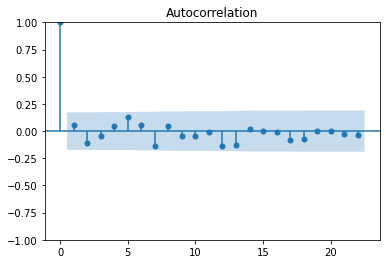

In [83]:
sq_resid_acf = plot_acf(sqr_resid)

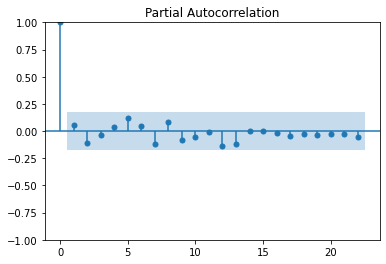

In [84]:
sq_resid_pacf = plot_pacf(sqr_resid, method = "ywm")

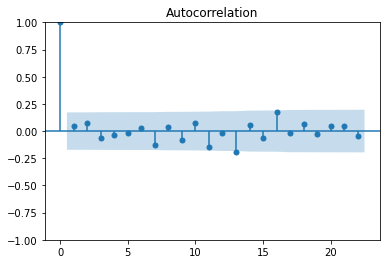

In [85]:
resid_acf = plot_acf(resid)

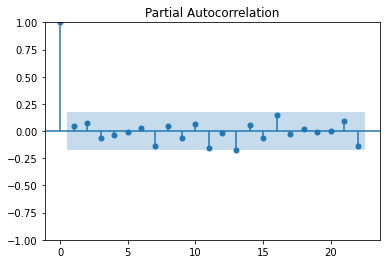

In [87]:
resid_pacf = plot_pacf(resid, method = "ywm")

In [2]:
check = ["muslim", "islam"]
sentence = "hindu muslim sikh isai"

In [4]:
if any(word in sentence for word in check):
     print(sentence)

hindu muslim sikh isai
